In [23]:
from pathlib import Path
import json
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd

In [24]:
all_bbv_info_file_path = Path("/scr/graphing/questions-n-graphs/data/all_bbv_info.json")
arm_stats_info_file_path = Path("/scr/graphing/questions-n-graphs/data/avaliable-arm-stats.json")
x86_stats_info_file_path = Path("/scr/graphing/questions-n-graphs/data/avaliable-x86-stats.json")

benchmarks = ["cg", "ep", "ft", "is", "lu", "mg", "sp"]

with open(all_bbv_info_file_path.as_posix()) as file:
    all_bbv_info = json.load(file)
with open(arm_stats_info_file_path.as_posix()) as file:
    all_arm_stats_info = json.load(file)
with open(x86_stats_info_file_path.as_posix()) as file:
    all_x86_stats_info = json.load(file)

all_stats = {"x86":all_x86_stats_info, "arm":all_arm_stats_info}

arm_avaliable_config = all_arm_stats_info.keys()
x86_avaliable_config = all_x86_stats_info.keys()

all_avaliable_config = {"x86":x86_avaliable_config, "arm":arm_avaliable_config}

In [25]:
for key, value in all_arm_stats_info.items():
    for rid, rdata in value.items():
        if "l2_controllers0-miss" not in rdata.keys():
            print(f"{key} doesn't have l2_controllers0-miss")
        elif "cores0-dtb-rmiss" not in rdata.keys() and "cores-dtb-rmiss" not in rdata.keys():
            print(f"{key} doesn't have dtb rmiss")
        elif "cores0-itb-miss" not in rdata.keys() and "cores-itb-miss" not in rdata.keys():
            print(f"{key} doesn't have itb rmiss")
        # elif "cores0-branch-miss" not in rdata.keys() and "cores-branch-miss" not in rdata.keys():
        #     print(f"{key} doesn't have branch rmiss")
        
        # Timing CPU doesn't have branch predictor information
        

In [26]:
for key, value in all_x86_stats_info.items():
    for rid, rdata in value.items():
        if "l2_controllers0-miss" not in rdata.keys():
            print(f"{key} doesn't have l2_controllers0-miss")
        elif "cores0-dtb-rmiss" not in rdata.keys() and "cores-dtb-rmiss" not in rdata.keys():
            print(f"{key} doesn't have dtb rmiss")
        elif "cores0-itb-miss" not in rdata.keys() and "cores-itb-miss" not in rdata.keys():
            print(f"{key} doesn't have itb rmiss")
        # elif "cores0-branch-miss" not in rdata.keys() and "cores-branch-miss" not in rdata.keys():
        #     print(f"{key} doesn't have branch rmiss")
        
        # Timing CPU doesn't have branch predictor information

In [27]:
print(len(x86_avaliable_config))

39


## Failed functions

In [28]:
def graph_bbv_freq(isa, thread, bench):
    bbv_freq = all_bbv_info[isa][thread][bench]["bbv-global"]
    regions = []
    bbf_global_graph = {}
    for rid, rdata in bbv_freq.items():
        regions.append(rid)
        for bb_id, freq in rdata.items():
            if bb_id in bbf_global_graph.keys():
                bbf_global_graph[bb_id].append(freq)
            else:
                bbf_global_graph[bb_id] = [freq]

    x = np.array(len(regions))
    width = 0.08
    multipiler = 0

    fig, ax = plt.subplots()


    for bb_id, freq in bbf_global_graph.items():
        offset = width * multipiler
        rects = ax.bar(x + offset, freq, width)
        multipiler += 1

    # ax.set_xticks(x + width, regions)
    ax.set_ylim([0.0, 0.2])
    width = 200
    height = 150
    fig.set_size_inches(width, height)

    plt.show()

    return bbf_global_graph

# this graph doesn't work out because the average frequency of the bb is lower than 0.025. 
# the visualization doesn't state the point

In [29]:
def show_highest_ten_bbf(isa, thread, bench):
    bbv_freq = all_bbv_info[isa][thread][bench]["bbv-global"]
    all_interested_bbid = set()
    for rid, rdata in bbv_freq.items():
        bb_id = rdata.keys()
        bbf = rdata.values()

        sorted_bb_id = [x for _,x in sorted(zip(bbf, bb_id), reverse=True)]

        for bb_id in sorted_bb_id[0:11]:
            all_interested_bbid.add(bb_id)

    all_interested_bbid = list(all_interested_bbid)
    all_interested_bbid = sorted(all_interested_bbid)
    num_colors = len(all_interested_bbid)
    cm = plt.get_cmap('gist_rainbow')

    graph_regional_freq = {}
    
    for rdata in bbv_freq.values():
        for bb_id in all_interested_bbid:
            if bb_id in graph_regional_freq.keys():
                if bb_id not in rdata.keys():
                    graph_regional_freq[bb_id].append(0.0)
                else:
                    graph_regional_freq[bb_id].append(rdata[bb_id])
            else:
                if bb_id not in rdata.keys():
                    graph_regional_freq[bb_id] = [0.0]
                else:
                    graph_regional_freq[bb_id] = [rdata[bb_id]]


    df = pd.DataFrame(graph_regional_freq, index=bbv_freq.keys())

    
    ax = df.plot(kind="bar", figsize=(40,25), color=[cm(1.*i/num_colors) for i in range(num_colors)])
    ax.set_title((f"{bench} most frequent BB whinin regions with {thread} threads"))
    plt.show()

    return graph_regional_freq

# it shows the bbv freq but since bbv is large, it's not a good visualization


# Util functions

In [30]:
def show_one_set_for_one_config(isa, config, graph_it=True):
    data = all_stats[isa][config]
    name = config.split('-')
    bench = name[0]
    core_type = name[1]
    core_num = name[2]
    l2_size = name[4]

    rid_list = data.keys()

    l2_misses = []
    l1i_misses = []
    l1d_read_misses = []
    l1d_write_misses = []
    branch_pred_misses = []
    runtime = []

    set_size = 6
    if core_type == "Timing":
        set_size = 5

    for rdata in data.values():
        local_l2_misses = 0
        local_l1i_misses = 0
        local_l1d_read_misses = 0
        local_l1d_write_misses = 0
        local_bench_pred_misses = 0
        for type, value in rdata.items():
            if "-dtb-rmiss" in type:
                local_l1d_read_misses += int(value)
            elif "-dtb-wmiss" in type:
                local_l1d_write_misses += int(value)
            elif "-itb-miss" in type:
                local_l1i_misses += int(value)
            elif "-l2-miss" in type:
                local_l2_misses += int(value)
            elif "-branch-miss" in type:
                local_bench_pred_misses += int(value)
            elif "runtime" == type:
                runtime.append(float(value))
        l2_misses.append(local_l2_misses)
        l1i_misses.append(local_l1i_misses)
        l1d_read_misses.append(local_l1d_read_misses)
        l1d_write_misses.append(local_l1d_write_misses)
        branch_pred_misses.append(local_bench_pred_misses)

    if graph_it:

        fig, axs = plt.subplots(set_size)

        fig.suptitle(f"{config} program behavior")

        fig_index = 0
        axs[fig_index].plot(rid_list,l2_misses)
        axs[fig_index].set_title("l2 misses")
        fig_index += 1
        axs[fig_index].plot(rid_list,l1i_misses)
        axs[fig_index].set_title("l1i misses")
        fig_index += 1
        axs[fig_index].plot(rid_list,l1d_read_misses)
        axs[fig_index].set_title("l1d read misses")
        fig_index += 1
        axs[fig_index].plot(rid_list,l1d_write_misses)
        axs[fig_index].set_title("l1d write misses")
        fig_index += 1
        if core_type != "Timing":
            axs[fig_index].plot(rid_list,branch_pred_misses)
            axs[fig_index].set_title("branch prediction misses")
            fig_index += 1
        axs[fig_index].plot(rid_list,runtime)
        axs[fig_index].set_title("runtime")
        width = 20
        height = 15
        fig.set_size_inches(width, height)

        for ax in axs.flat:
            ax.set(xlabel='region id')

        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()

        plt.show()
    
    return rid_list, l2_misses, l1i_misses, l1d_read_misses, l1d_write_misses, branch_pred_misses, runtime




In [31]:
def show_one_set_for_multiple_config(isa, bench, thread):
    configs = []
    for config in all_avaliable_config[isa]:
        name = config.split('-')
        if bench == name[0] and str(thread) == name[2]:
            configs.append(config)

    configs = sorted(configs)
    graph_data = {
        "l2 misses":[],
        "l1i misses":[],
        "l1d read misses":[],
        "l1d write misses":[],
        "branch prediction misses":[],
        "runtime":[]
    }
    rid_list = None
    for config in configs:
        rid_list, l2_misses, l1i_misses, l1d_read_misses, l1d_write_misses, branch_pred_misses, runtime = show_one_set_for_one_config(isa, config, False)
        graph_data["l2 misses"].append(l2_misses)
        graph_data["l1i misses"].append(l1i_misses)
        graph_data["l1d read misses"].append(l1d_read_misses)
        graph_data["l1d write misses"].append(l1d_write_misses)
        if len(branch_pred_misses)==0:
            branch_pred_misses = [0 for i in range(len(rid_list))]
        graph_data["branch prediction misses"].append(branch_pred_misses)
        graph_data["runtime"].append(runtime)

    set_size = 6
    
    fig, axs = plt.subplots(set_size)

    fig.suptitle(f"{bench} program behavior with {isa} and {thread} threads")

    fig_index = 0
    for type, value_list in graph_data.items():
        for index, value in enumerate(value_list):
            axs[fig_index].plot(rid_list,value,label=configs[index])
        axs[fig_index].set_title(type)
        axs[fig_index].legend(loc="upper right",bbox_to_anchor=(1.1, 1.05))
        fig_index += 1
    width = 20
    height = 15
    fig.set_size_inches(width, height)

    for ax in axs.flat:
        ax.set(xlabel='region id')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    plt.show()





In [48]:
def merge_every_4_regional_stats(list):
    new_list = []
    for i in range(int(len(list)/4)):
        new_list.append(sum(list[i*4:(i*4+4)]))
    index = int(len(list)/4)
    if index*4 < len(list):
        new_list.append(sum(list[index*4:]))
    return new_list

        
def show_one_set_for_multiple_config_merge_single_thread_stats_to_4_threads(isa, bench):
    thread = 1
    configs = []
    for config in all_avaliable_config[isa]:
        name = config.split('-')
        if bench == name[0] and str(thread) == name[2]:
            configs.append(config)

    configs = sorted(configs)
    graph_data = {
        "l2 misses":[],
        "l1i misses":[],
        "l1d read misses":[],
        "l1d write misses":[],
        "branch prediction misses":[],
        "runtime":[]
    }
    rid_list = None
    for config in configs:
        print(f"working on {config}")
        rid_list, l2_misses, l1i_misses, l1d_read_misses, l1d_write_misses, branch_pred_misses, runtime = show_one_set_for_one_config(isa, config, False)
        rid_list = list(rid_list)
        rid_list = rid_list[:int((len(rid_list)/4)+1)]
        l2_misses = merge_every_4_regional_stats(l2_misses)
        l1i_misses = merge_every_4_regional_stats(l1i_misses)
        l1d_read_misses = merge_every_4_regional_stats(l1d_read_misses)
        l1d_write_misses = merge_every_4_regional_stats(l1d_write_misses)
        branch_pred_misses = merge_every_4_regional_stats(branch_pred_misses)
        runtime = merge_every_4_regional_stats(runtime)
        if len(rid_list) > len(runtime):
            rid_list = [i for i in range(len(runtime))]
        graph_data["l2 misses"].append(l2_misses)
        graph_data["l1i misses"].append(l1i_misses)
        graph_data["l1d read misses"].append(l1d_read_misses)
        graph_data["l1d write misses"].append(l1d_write_misses)
        if len(branch_pred_misses)==0:
            branch_pred_misses = [0 for i in range(len(rid_list))]
        graph_data["branch prediction misses"].append(branch_pred_misses)
        graph_data["runtime"].append(runtime)

    set_size = 6
    
    fig, axs = plt.subplots(set_size)

    fig.suptitle(f"{bench} program behavior with {isa} and {thread} threads but merge 4 regions into 1")

    fig_index = 0
    for type, value_list in graph_data.items():
        for index, value in enumerate(value_list):
            axs[fig_index].plot(rid_list,value,label=configs[index])
        axs[fig_index].set_title(type)
        axs[fig_index].legend(loc="upper right",bbox_to_anchor=(1.1, 1.05))
        fig_index += 1
    width = 20
    height = 15
    fig.set_size_inches(width, height)

    for ax in axs.flat:
        ax.set(xlabel='region id')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    plt.show()

<!-- ## Question: Does BBV related to regional runtime in multithread application? -->

<!-- ### Hypothesis 1: For different configurations of the same multithread workload, their regional behavior are related to the BBV -->

In [40]:
# 4 thread only
# for arm, every benchmark was ran with 6 different configurations
# for x86, every benchmark was ran with 4 different configurations

### all arm 4 thread stats

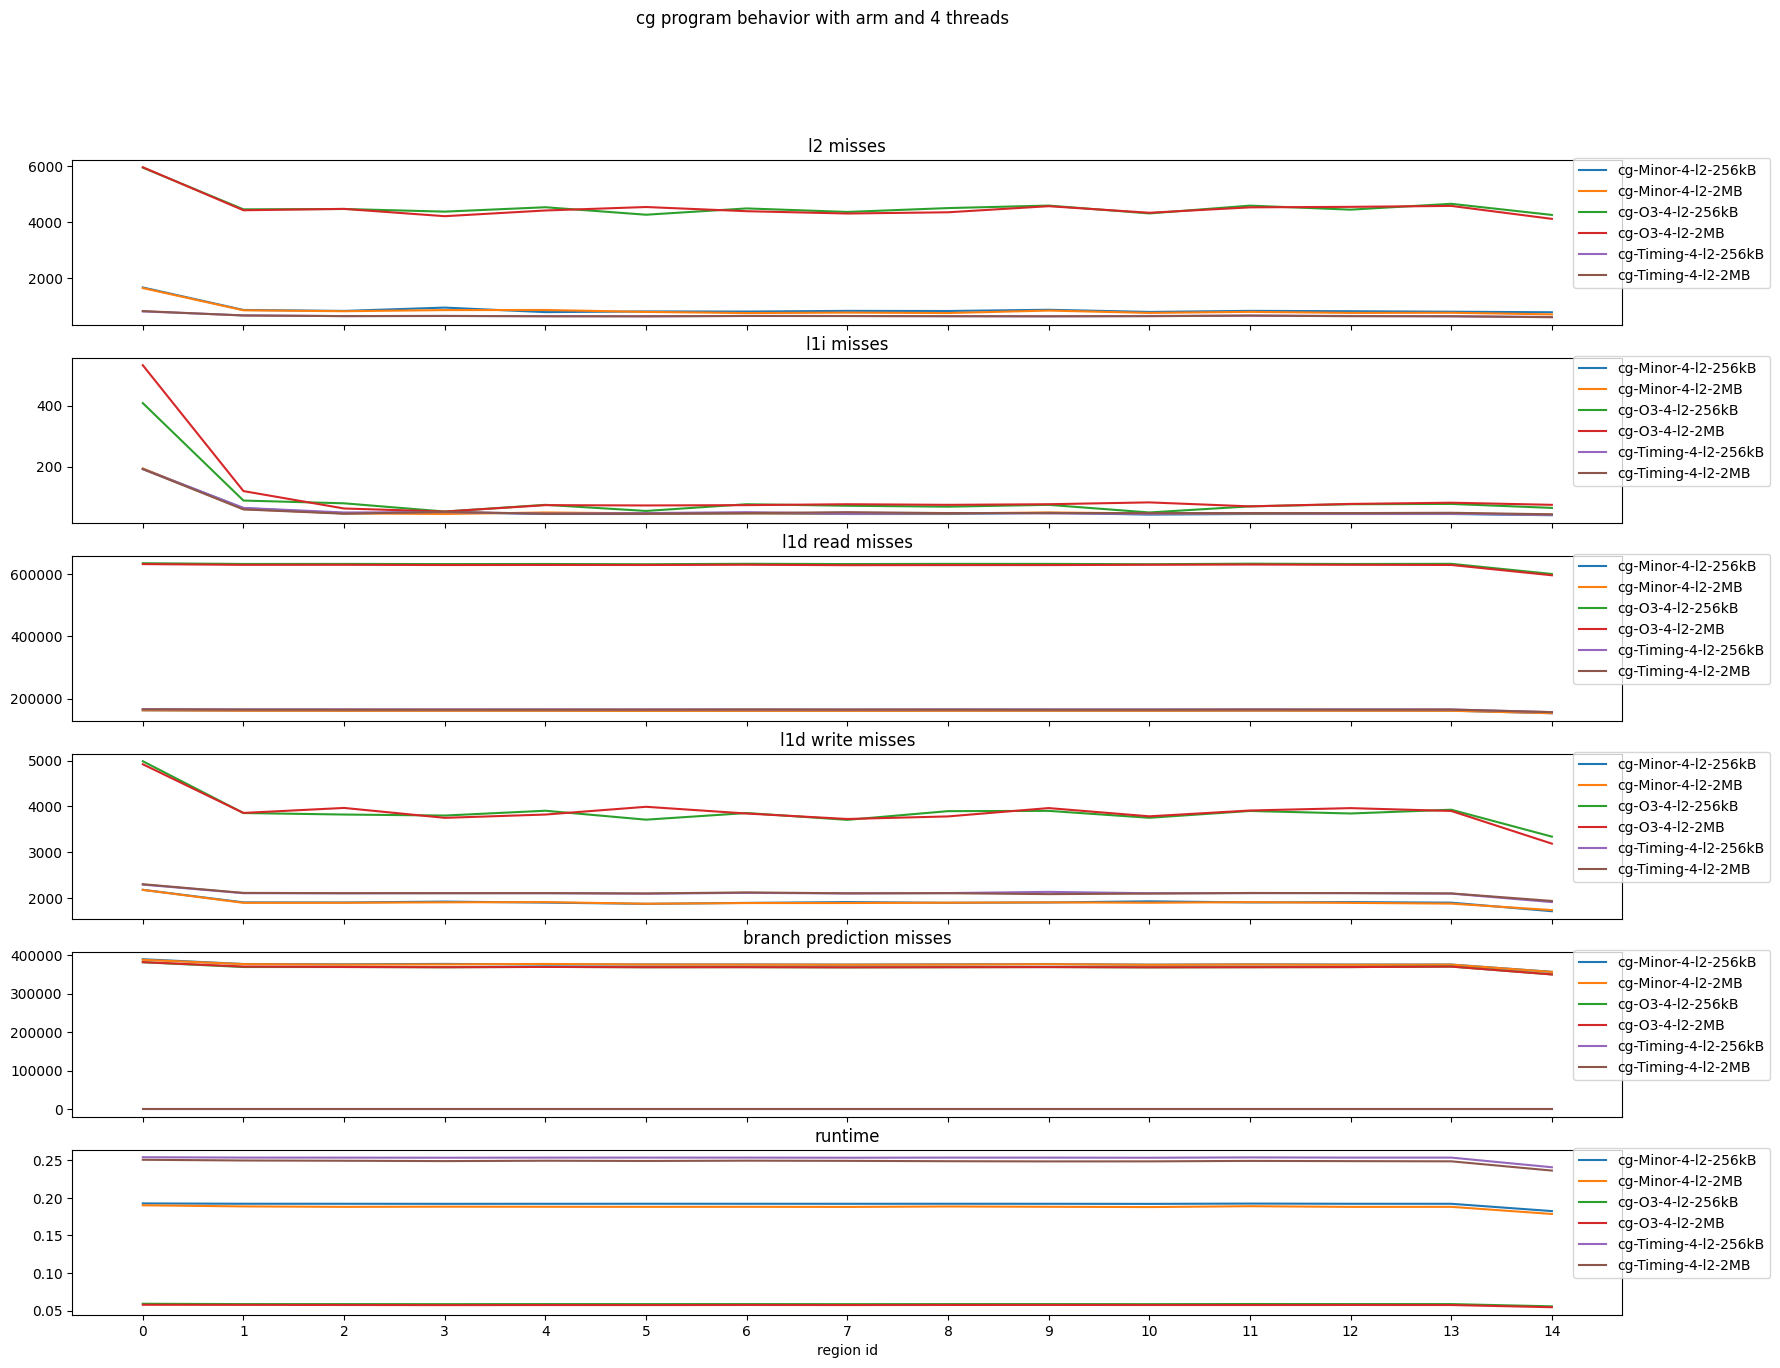

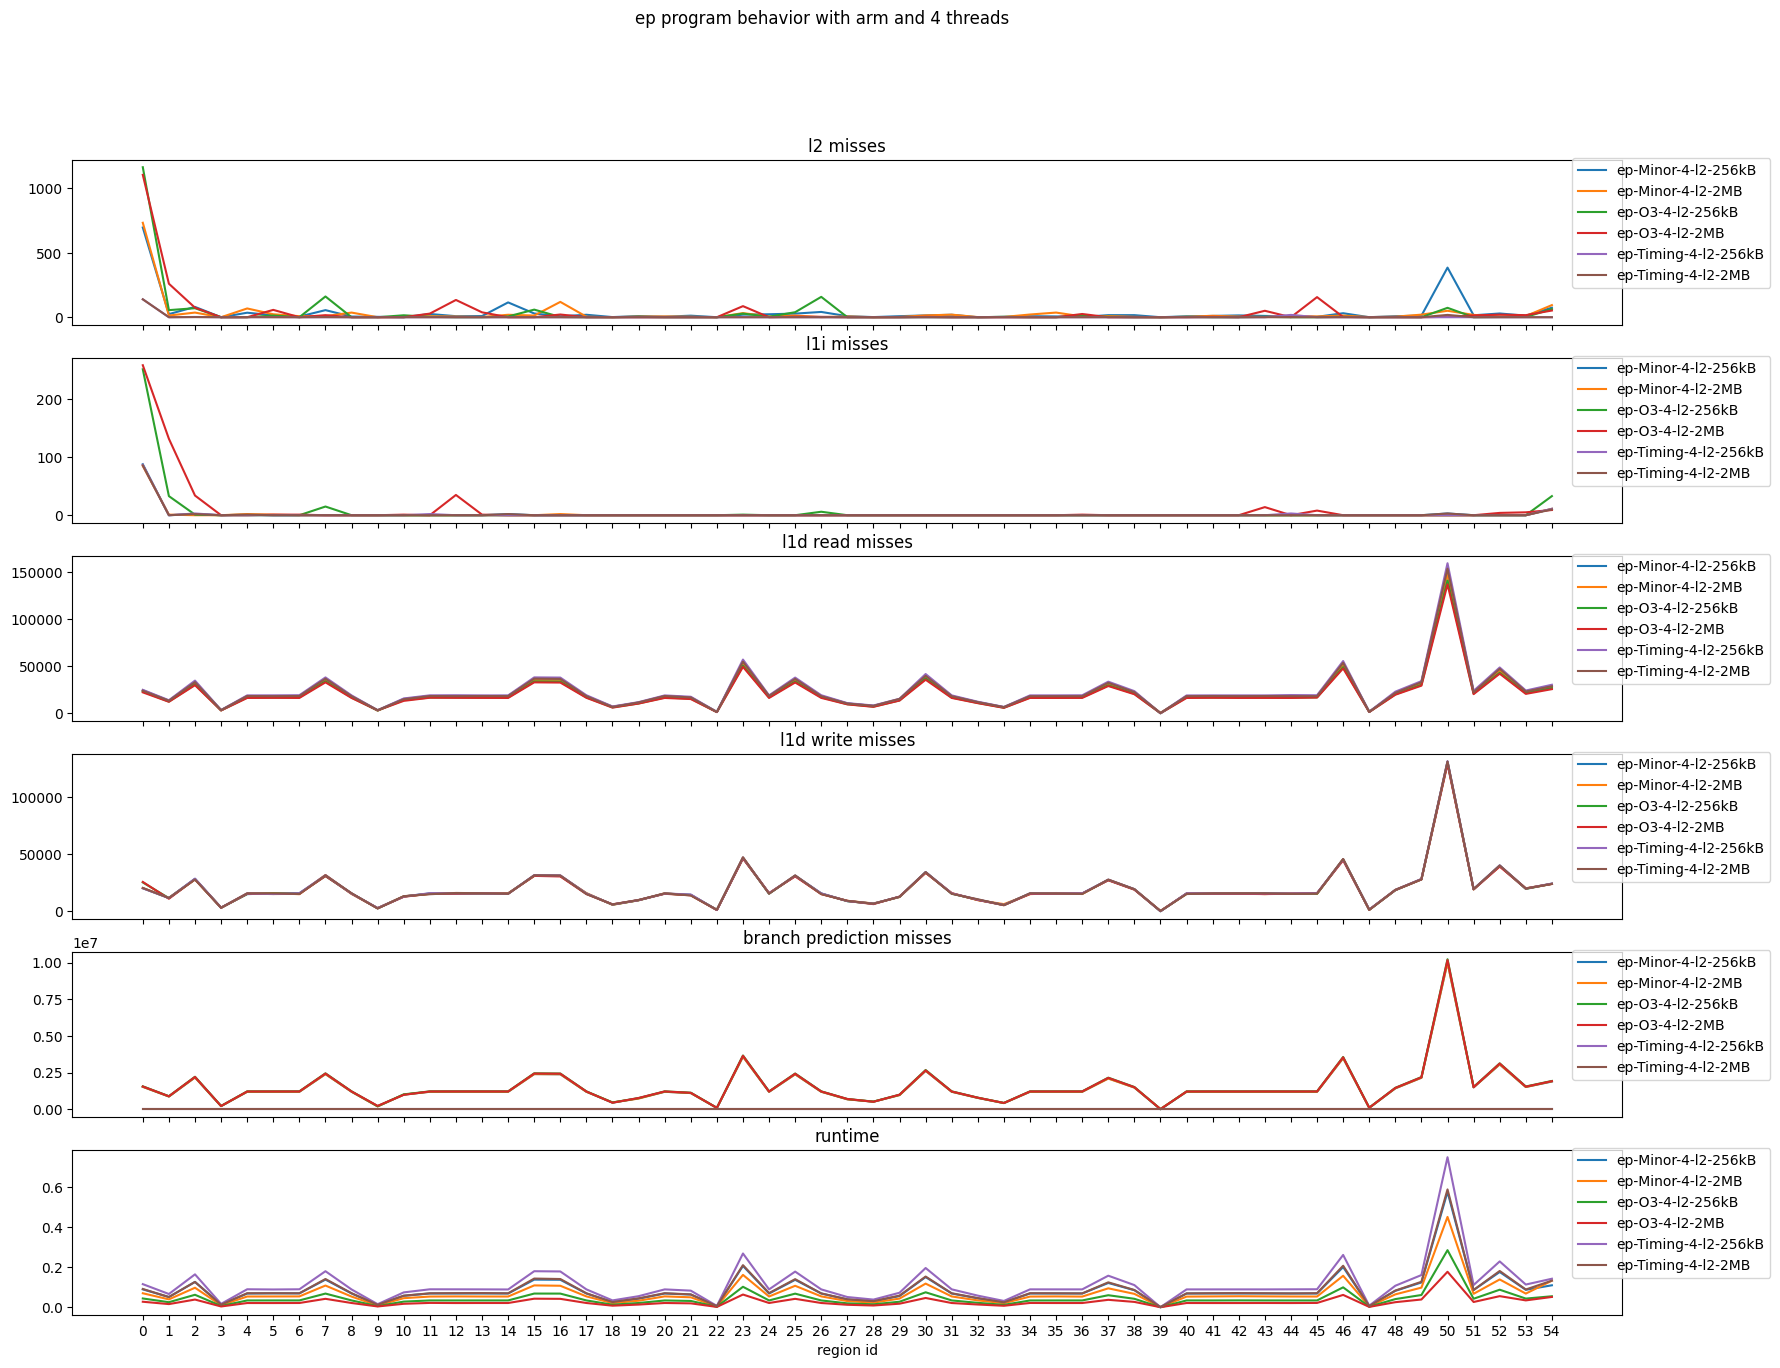

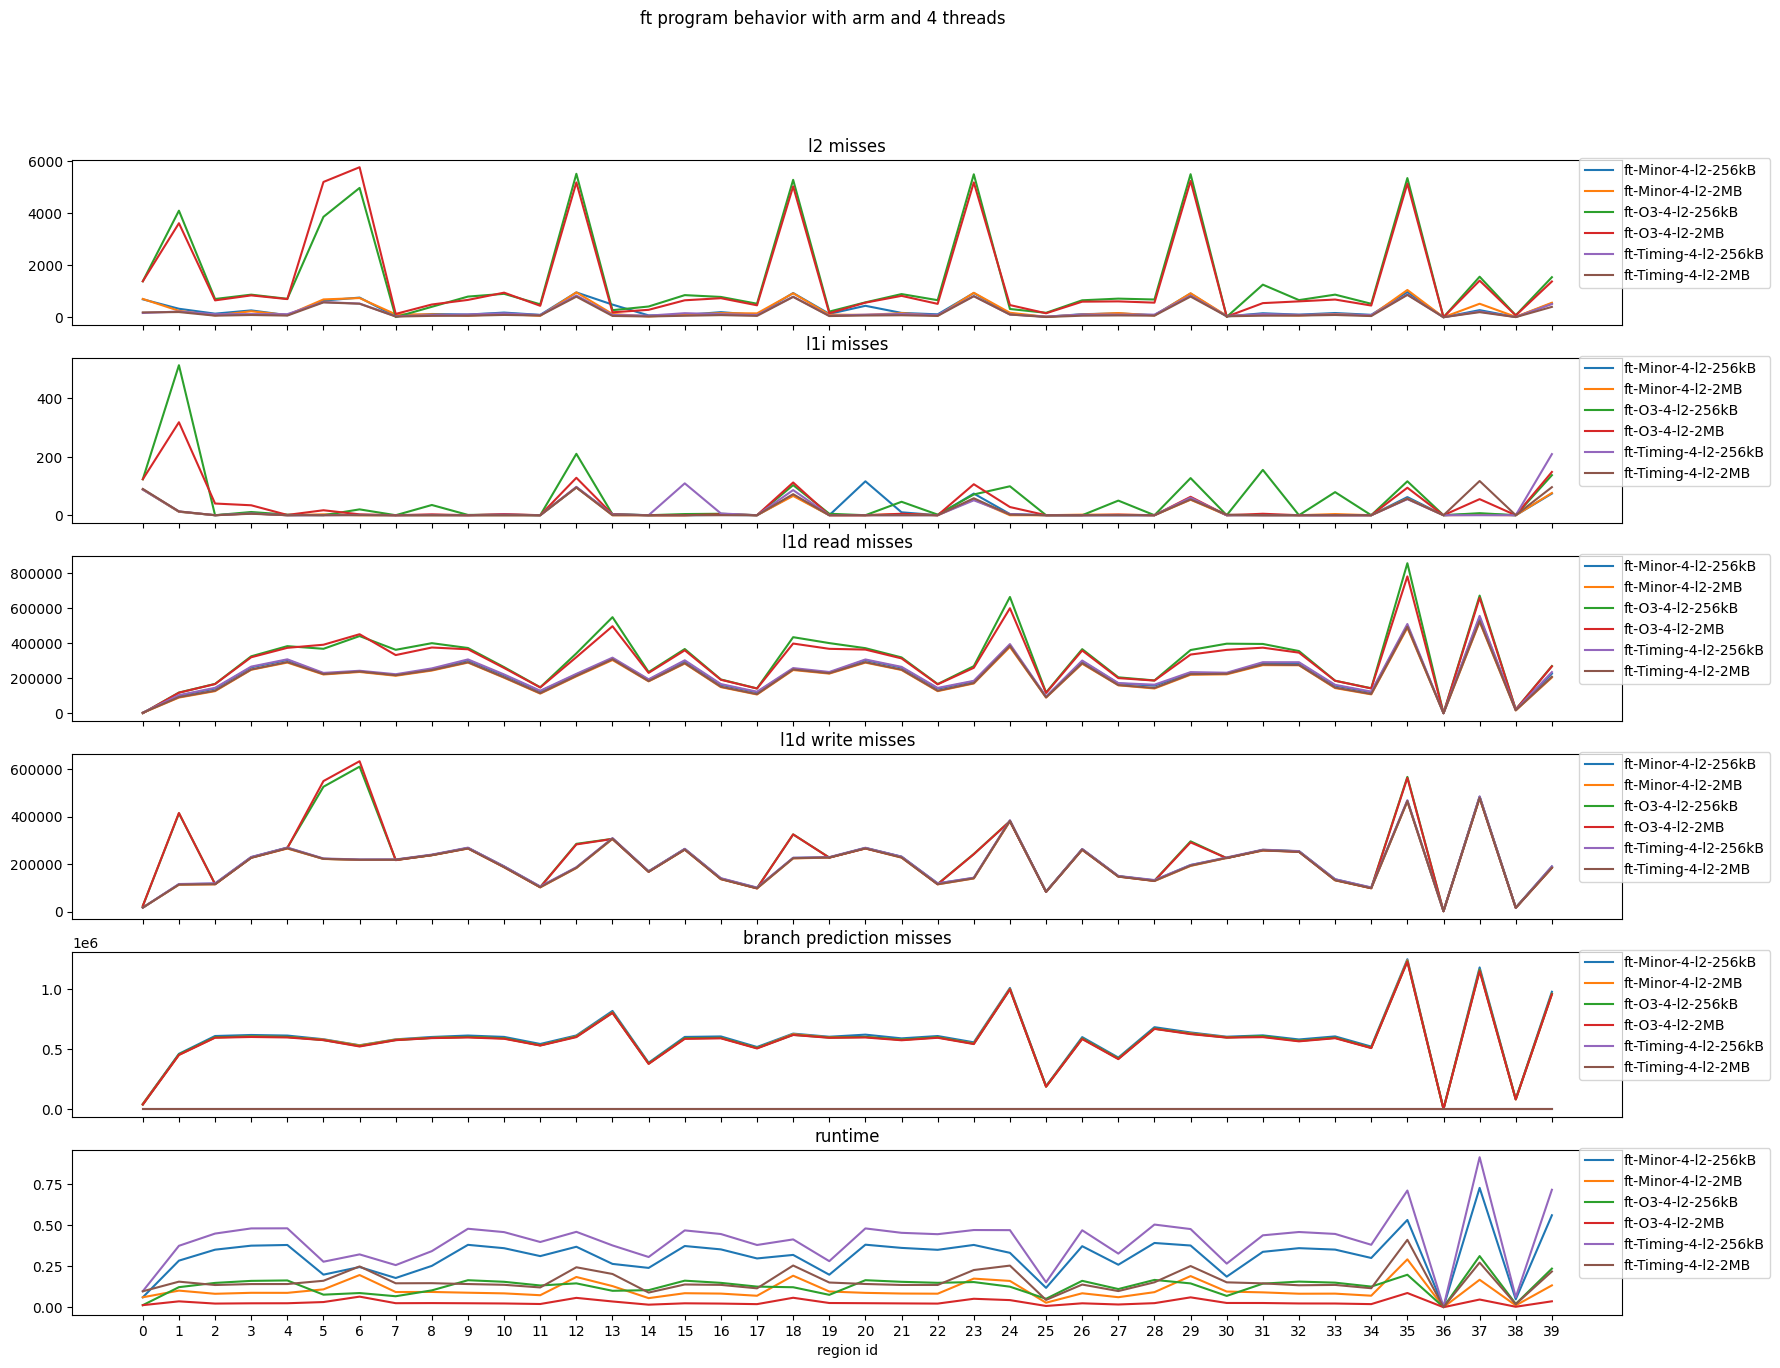

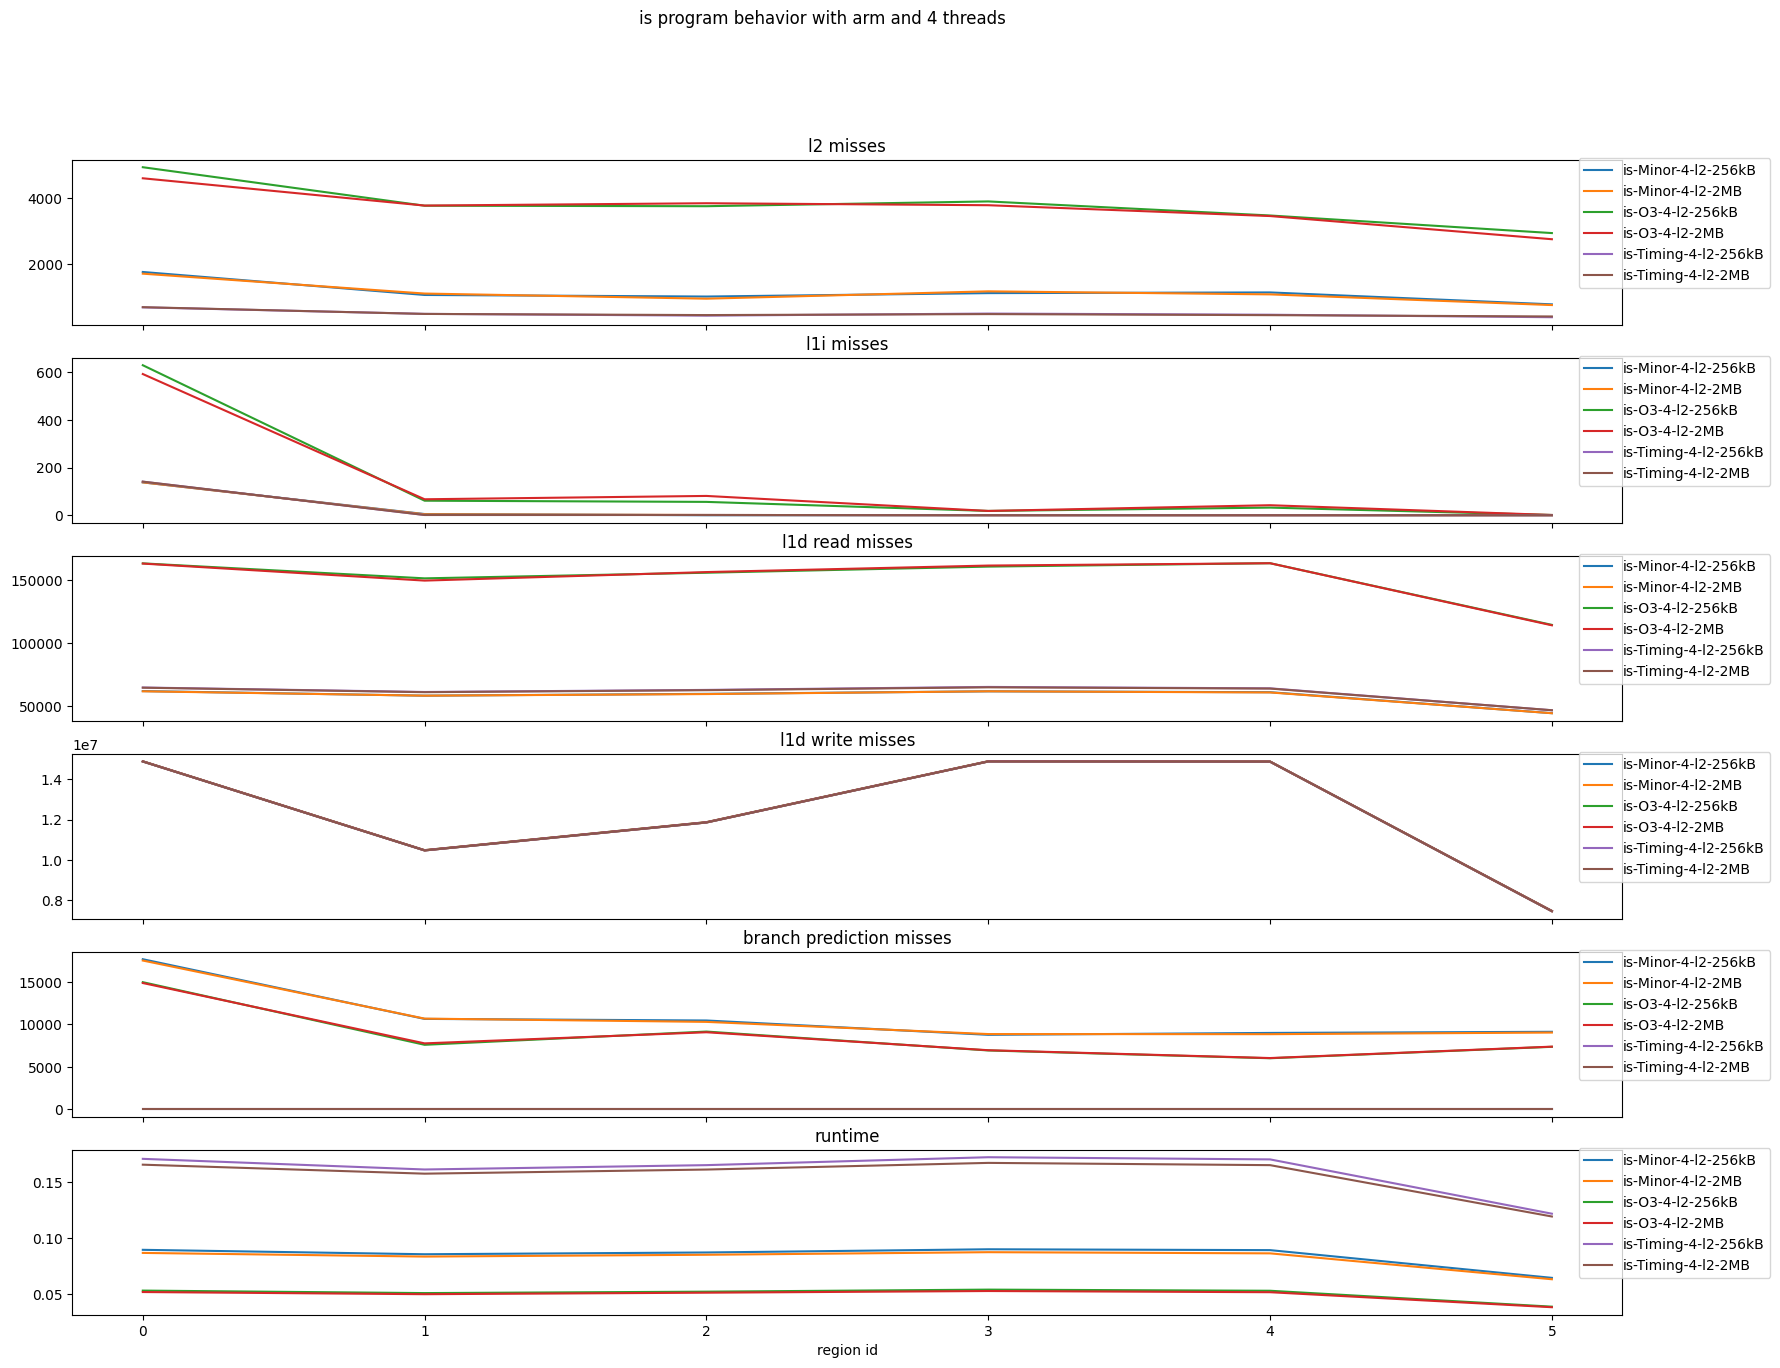

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


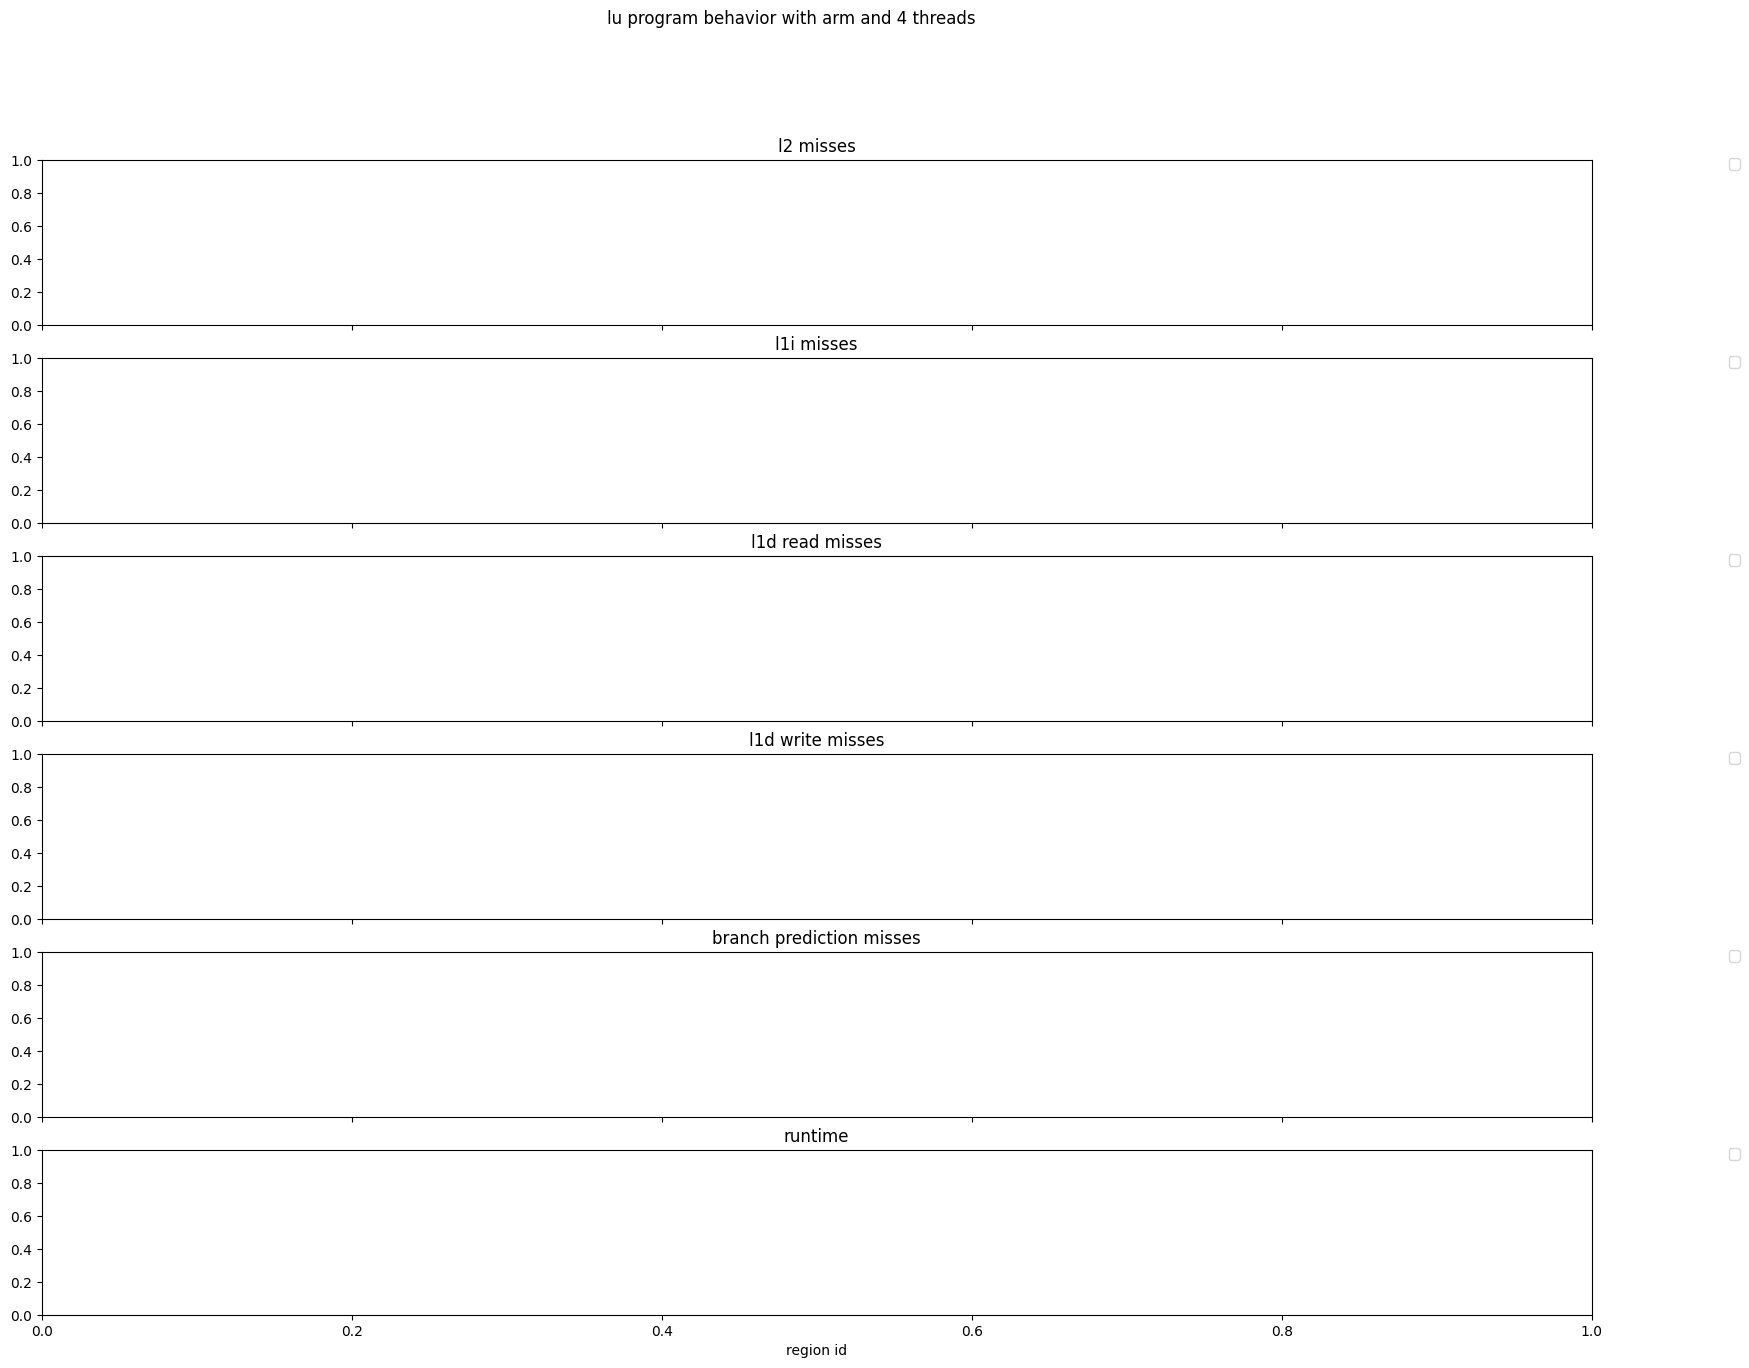

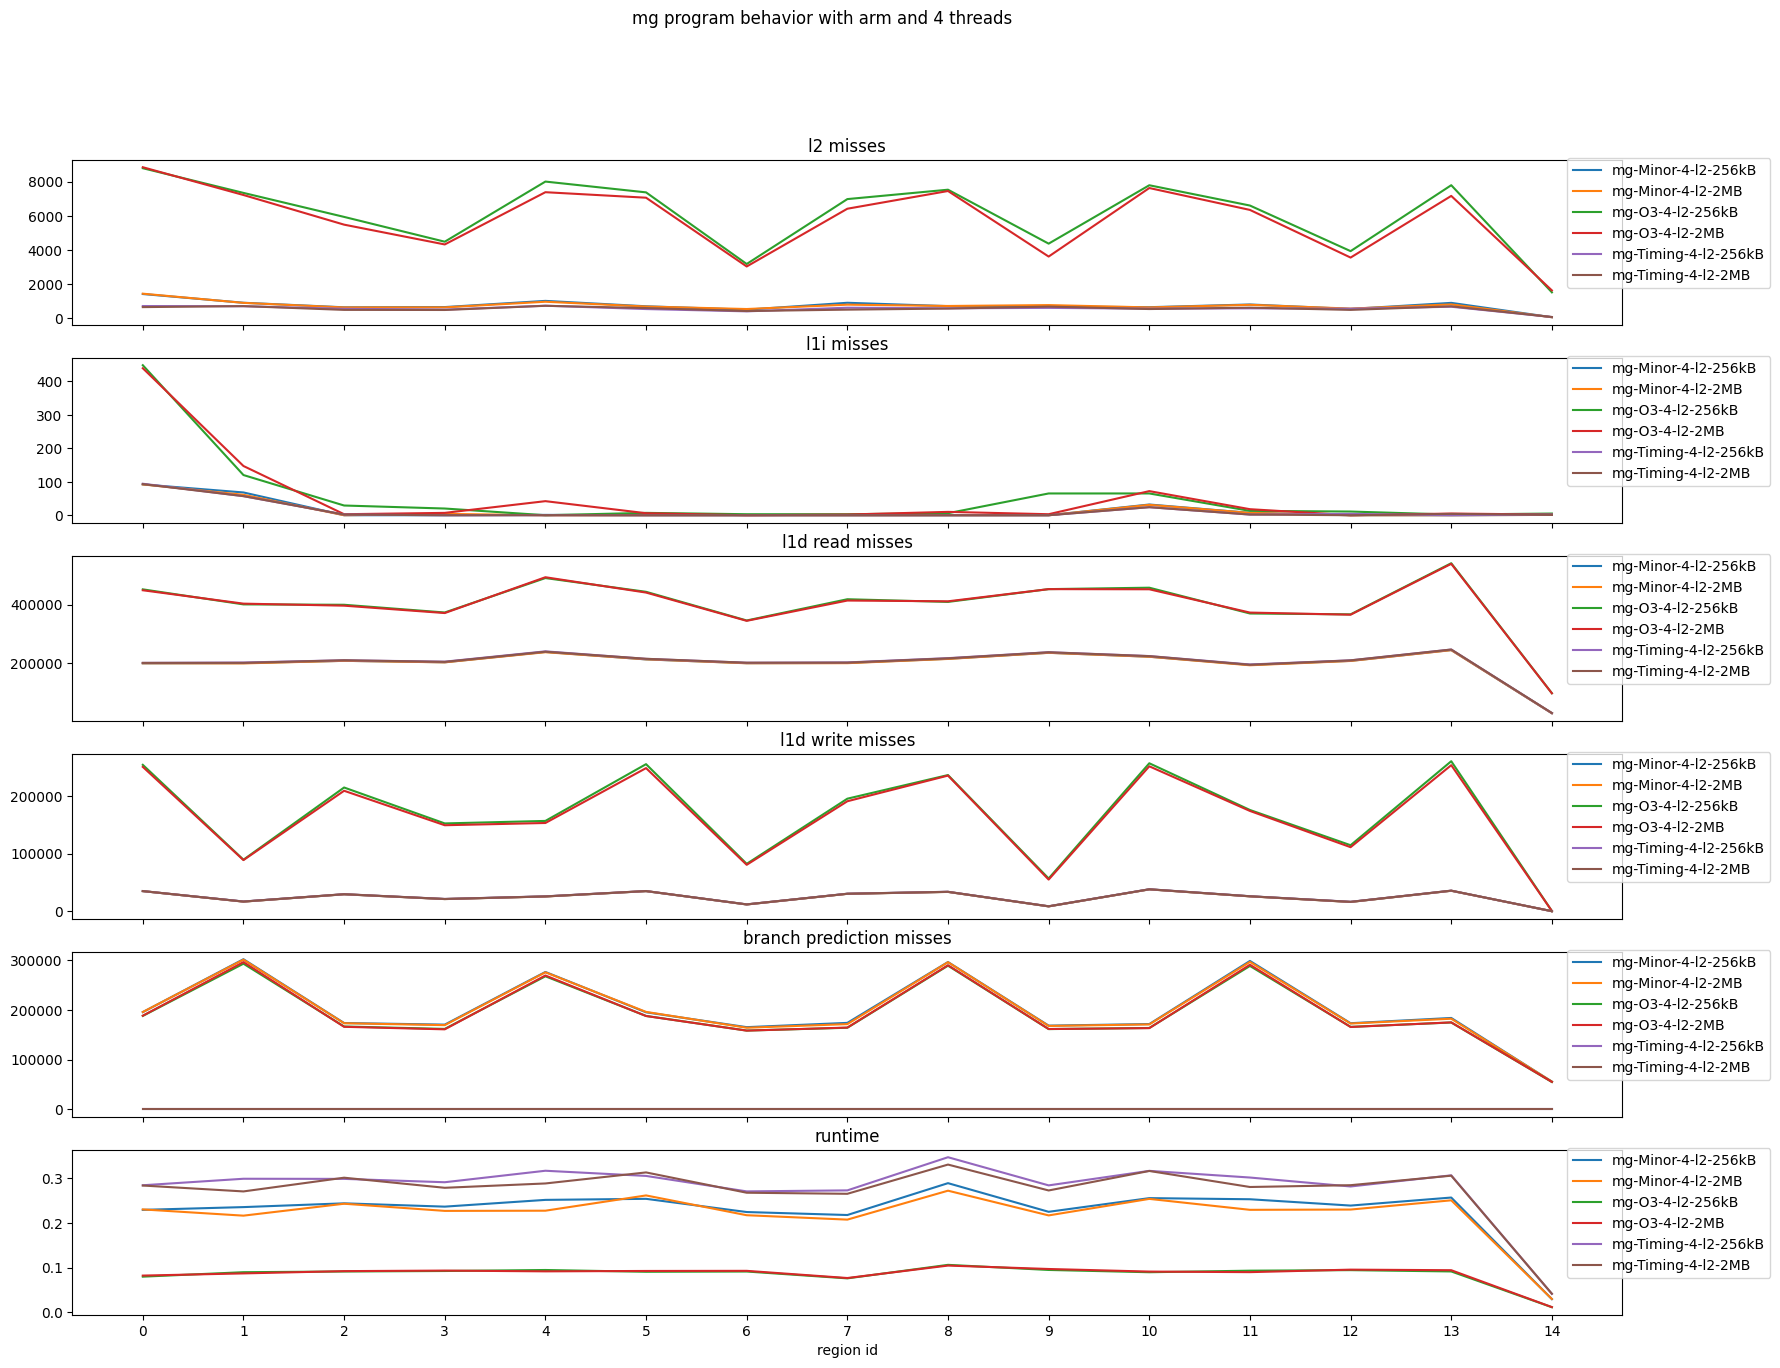

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


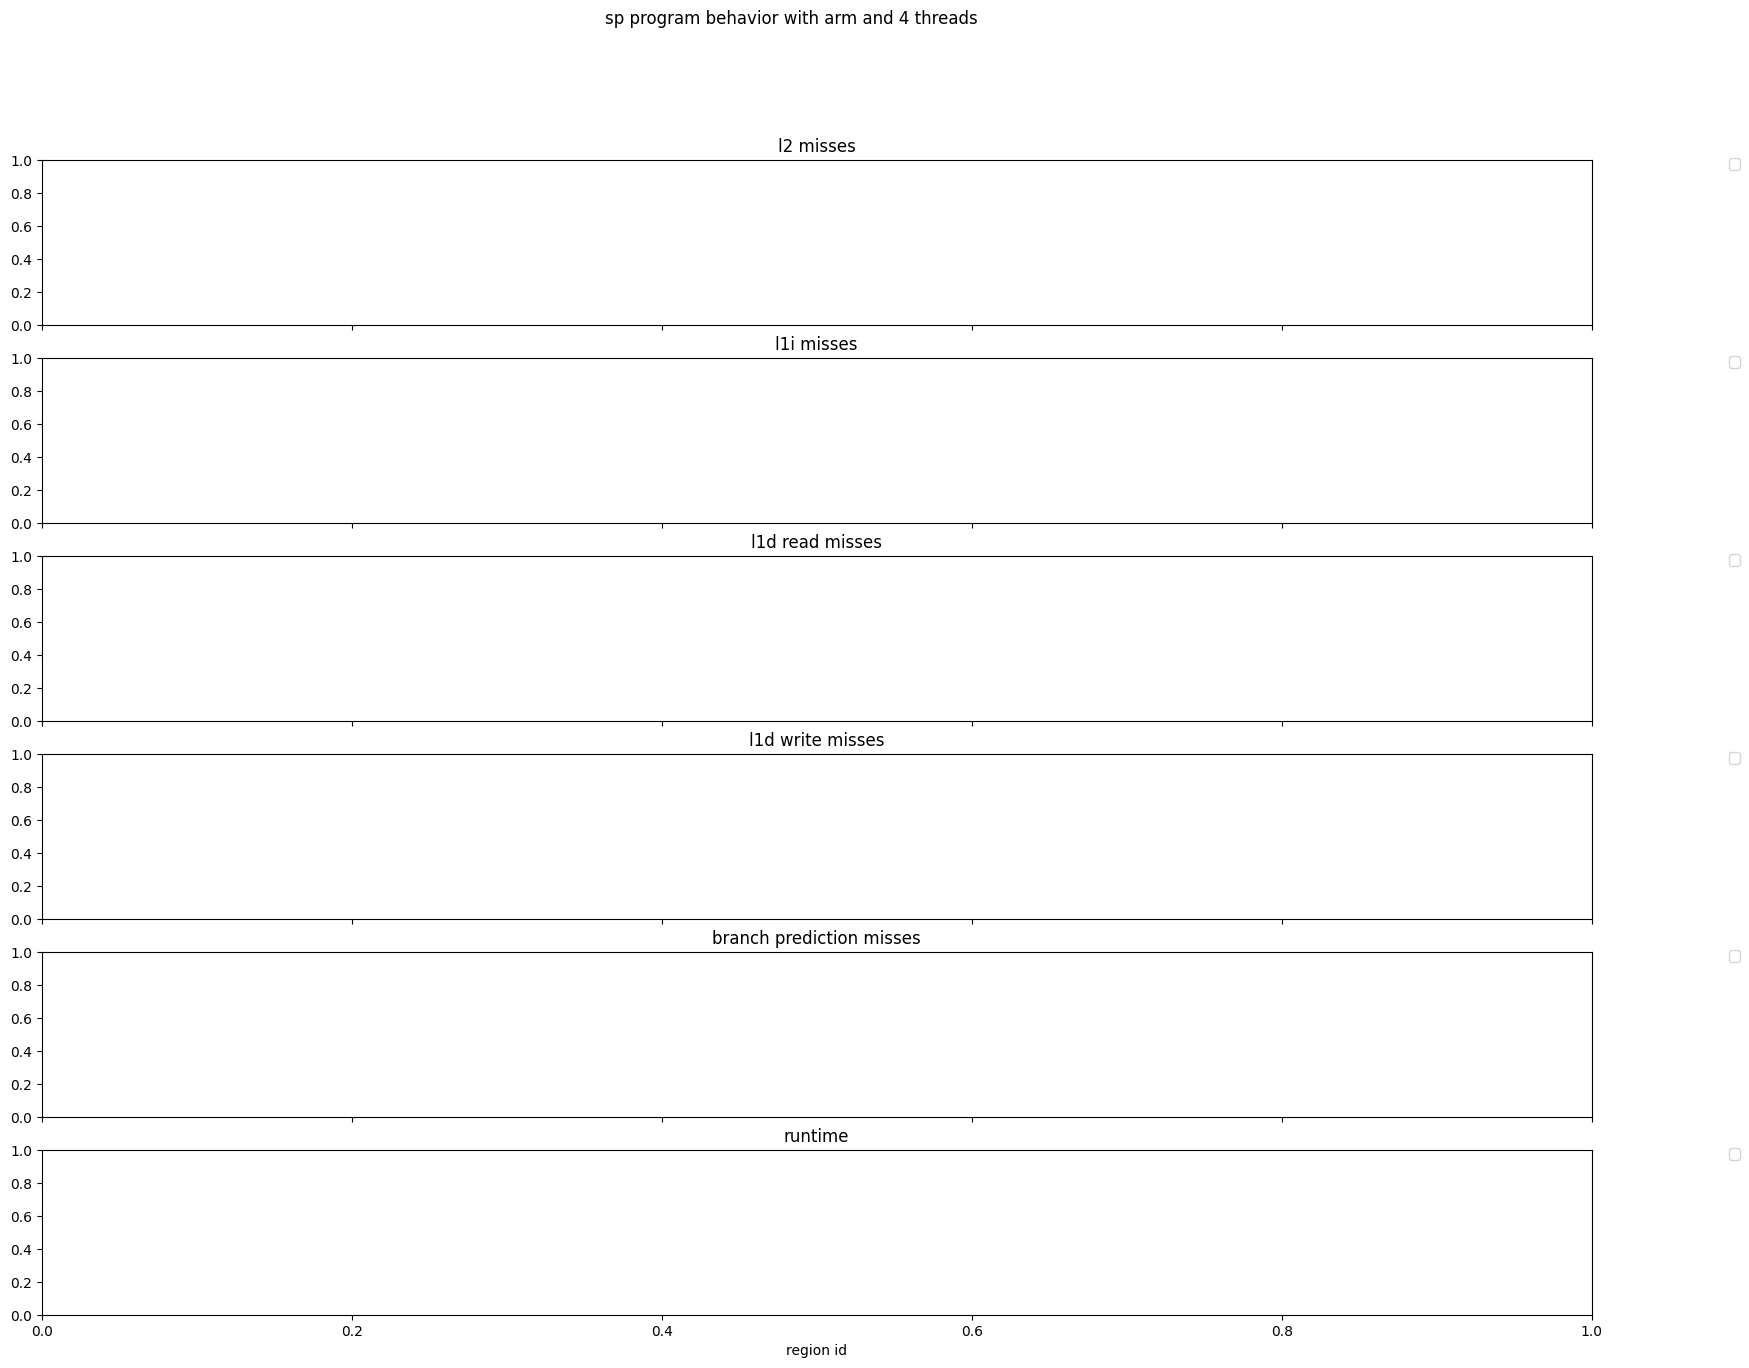

In [41]:
for bench in benchmarks:
    show_one_set_for_multiple_config("arm",bench,"4")

### all arm 1 thread stats

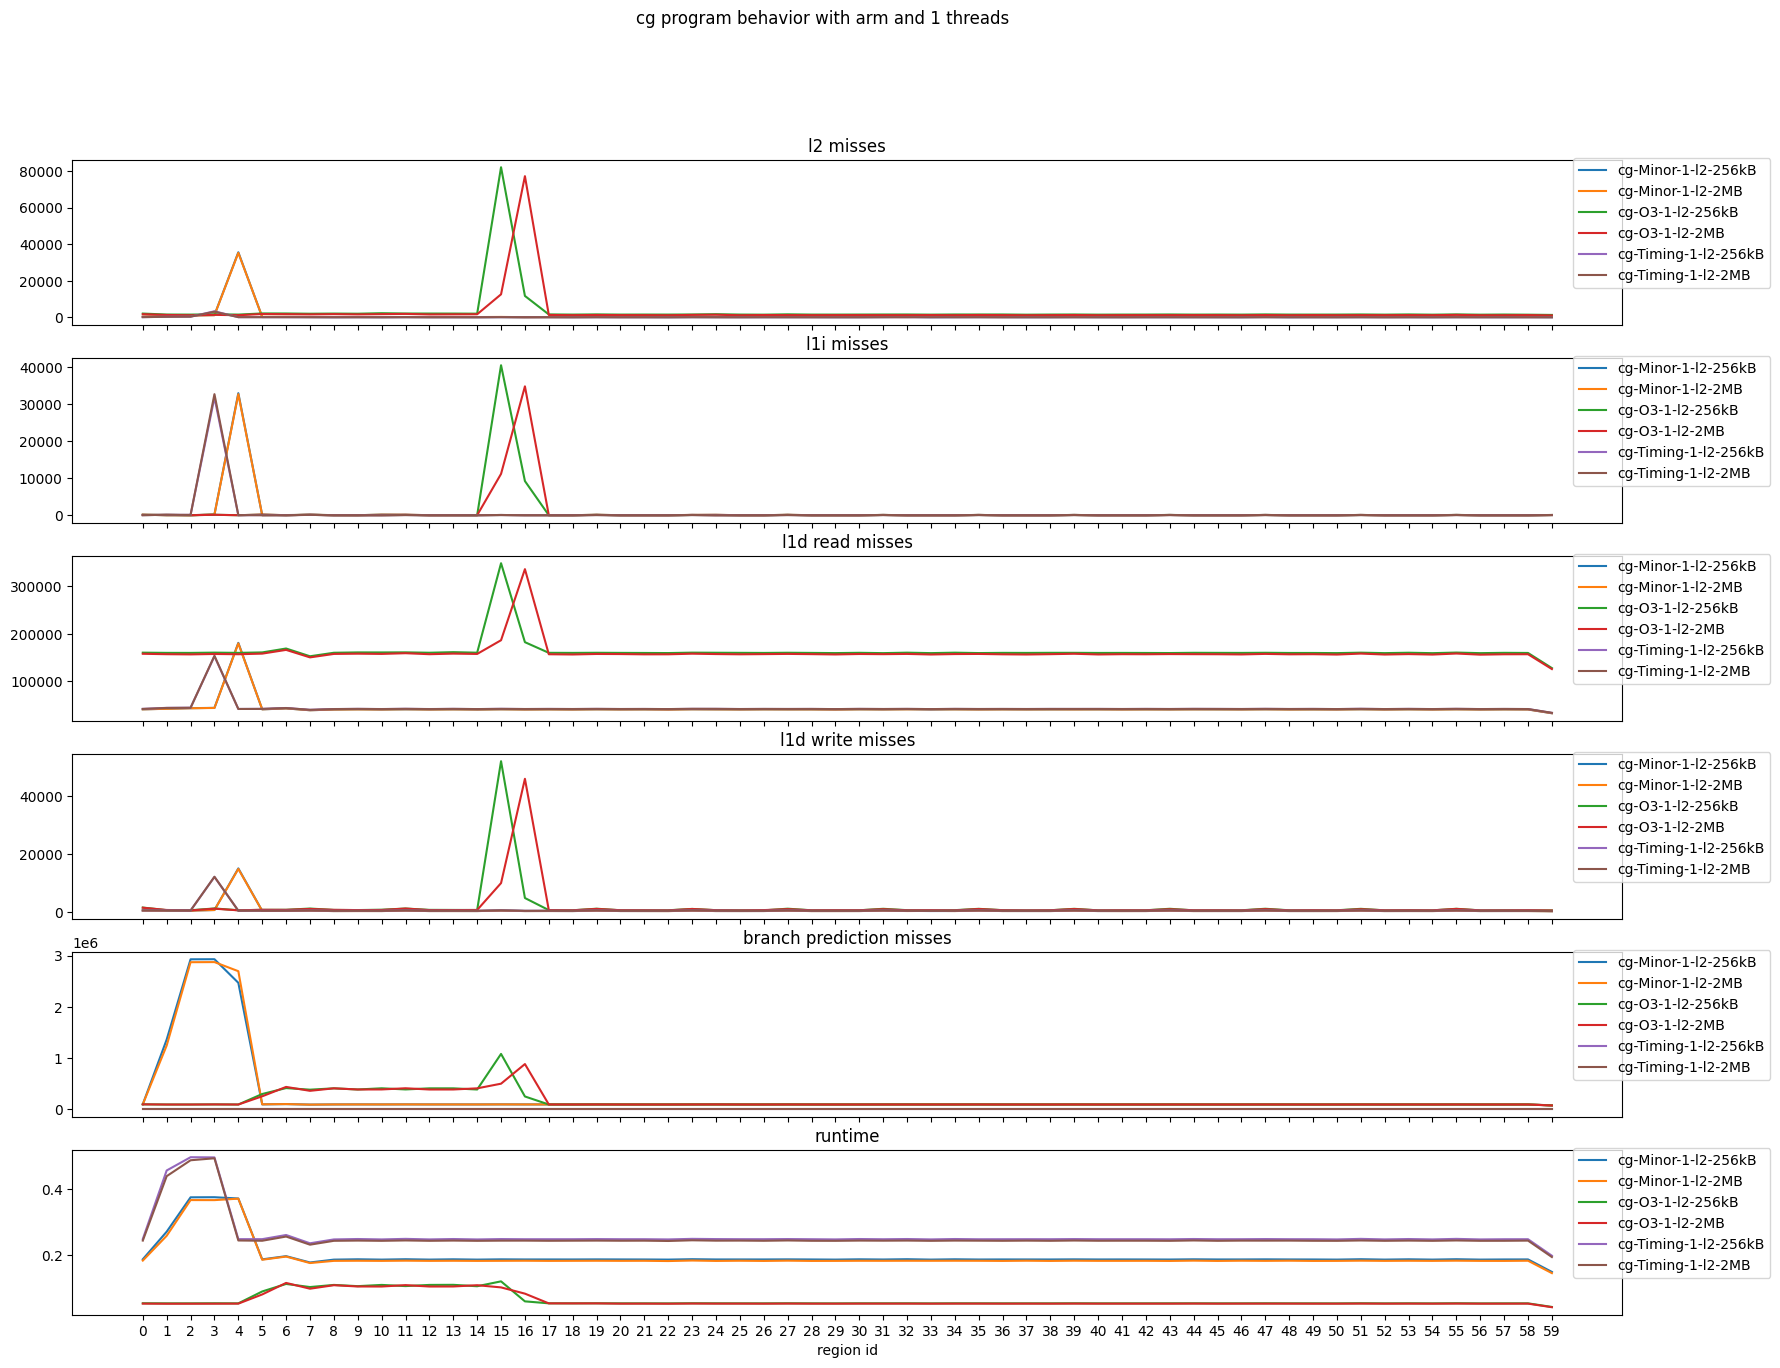

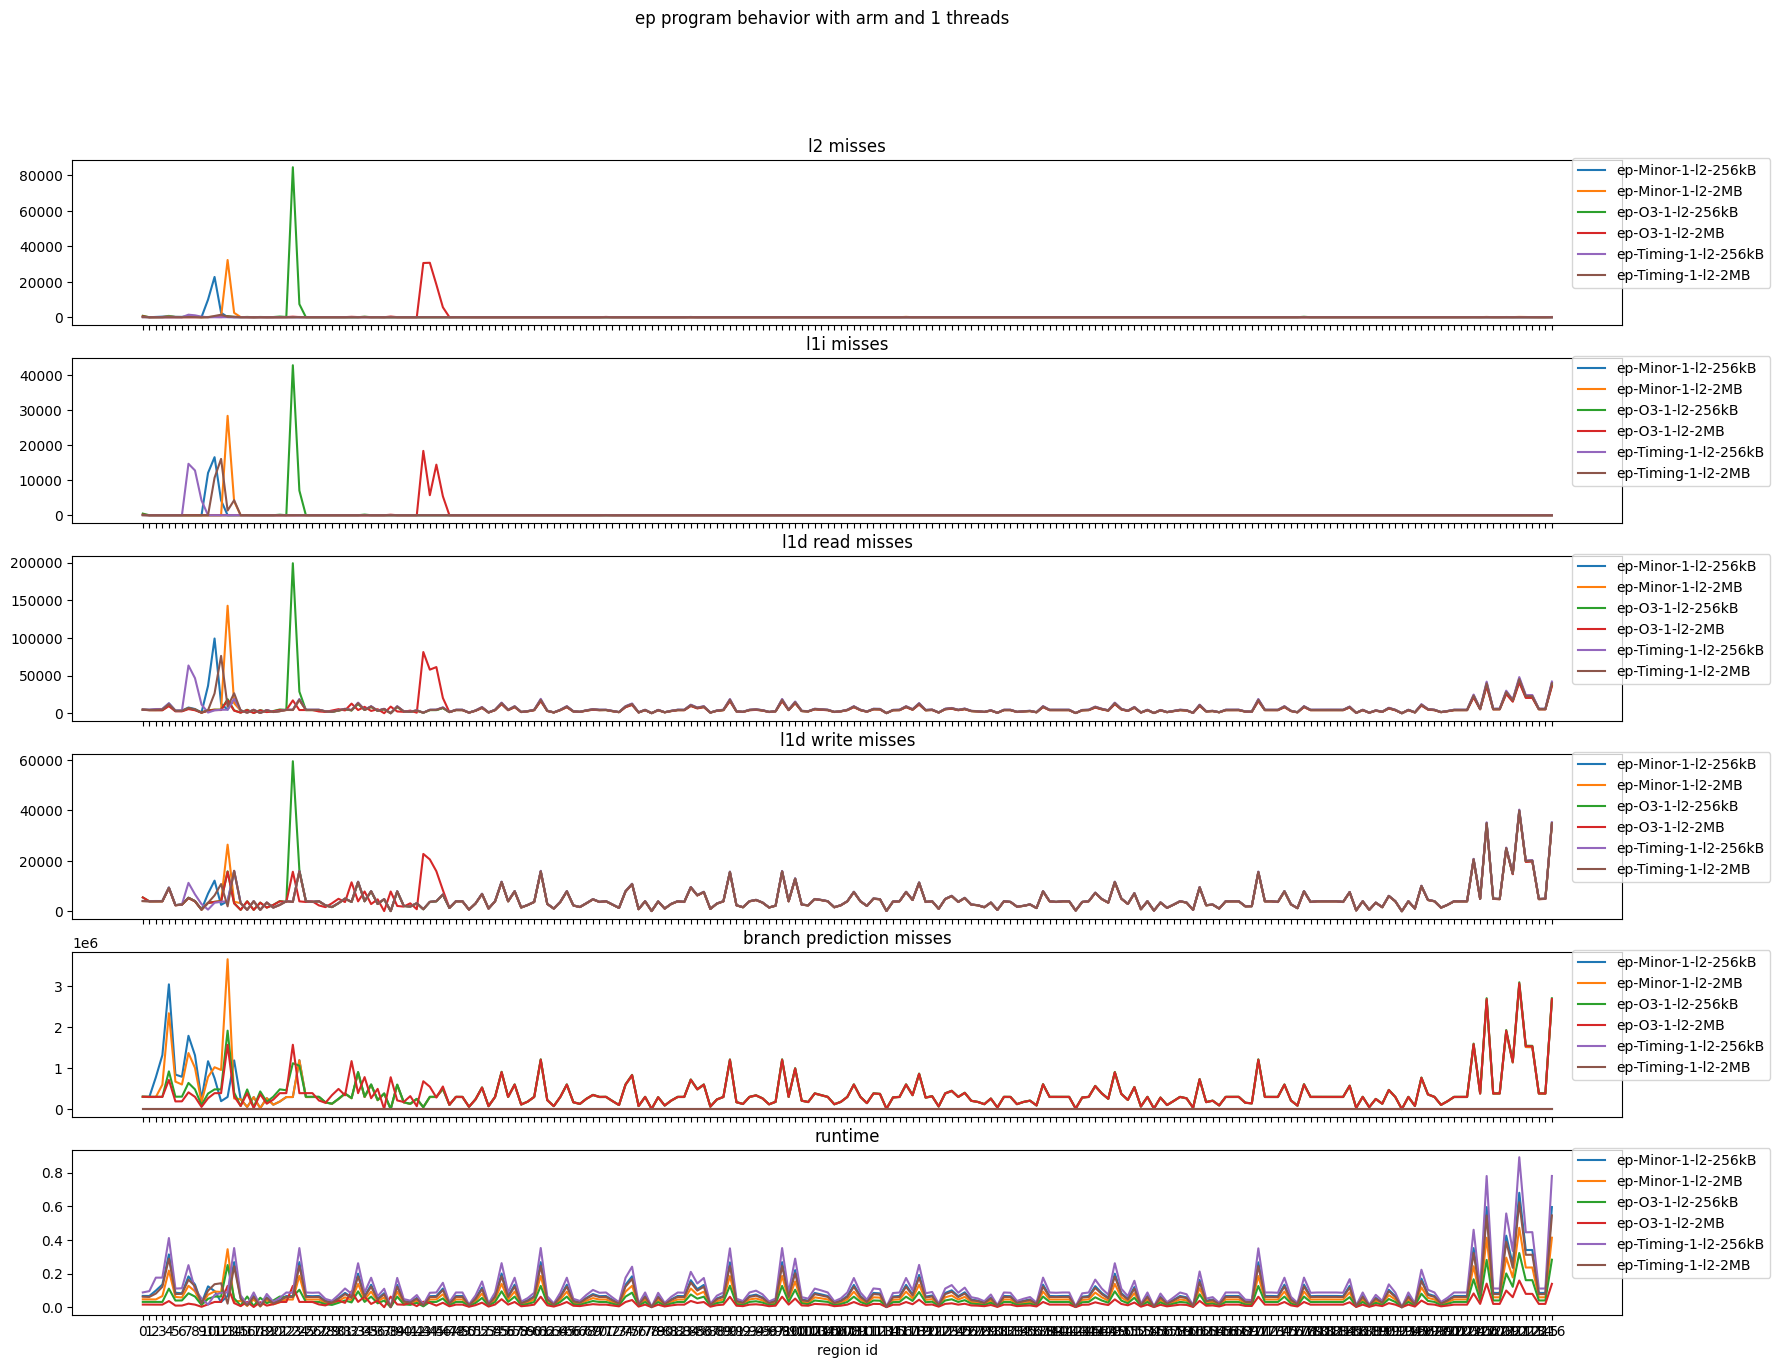

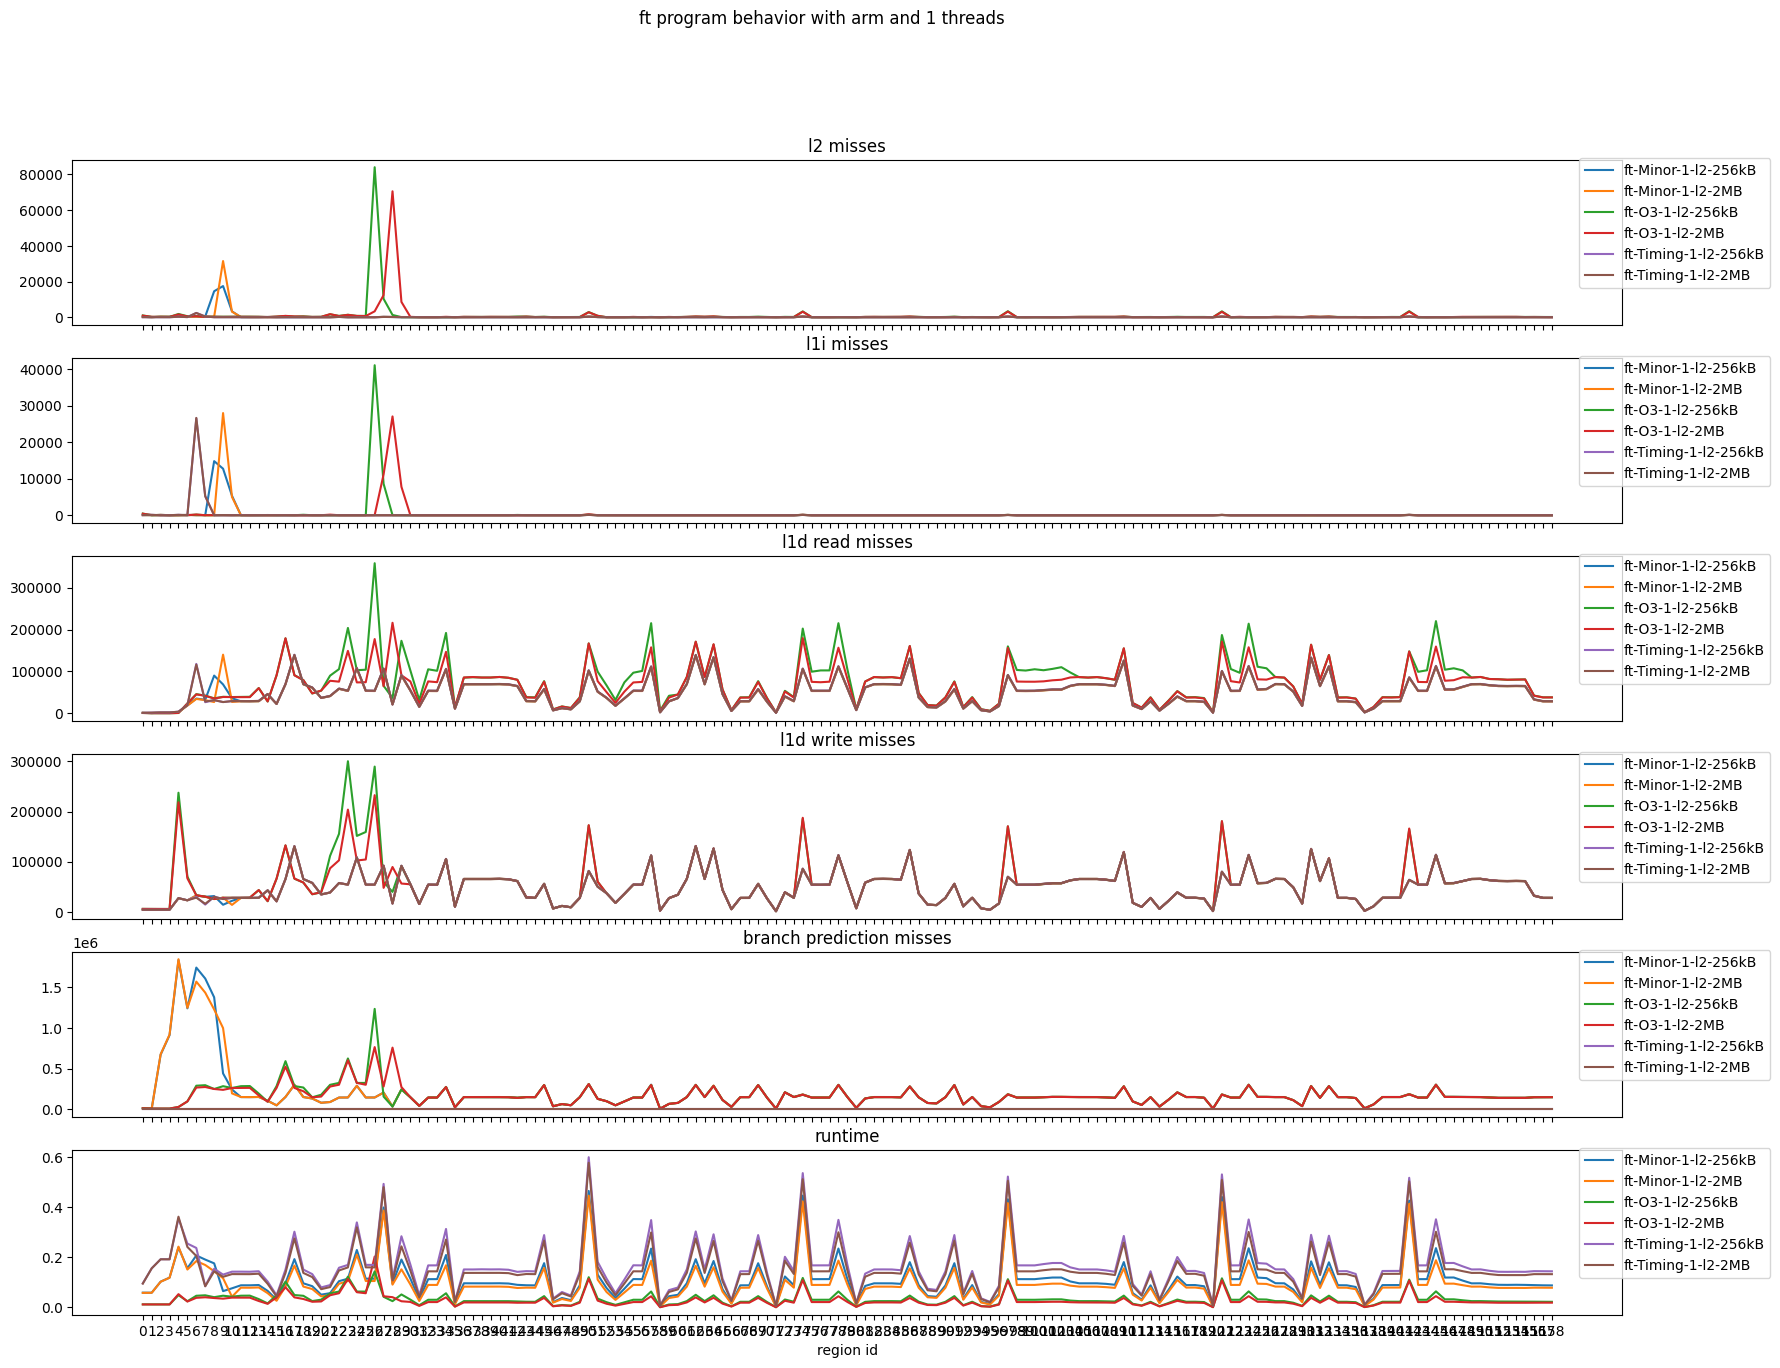

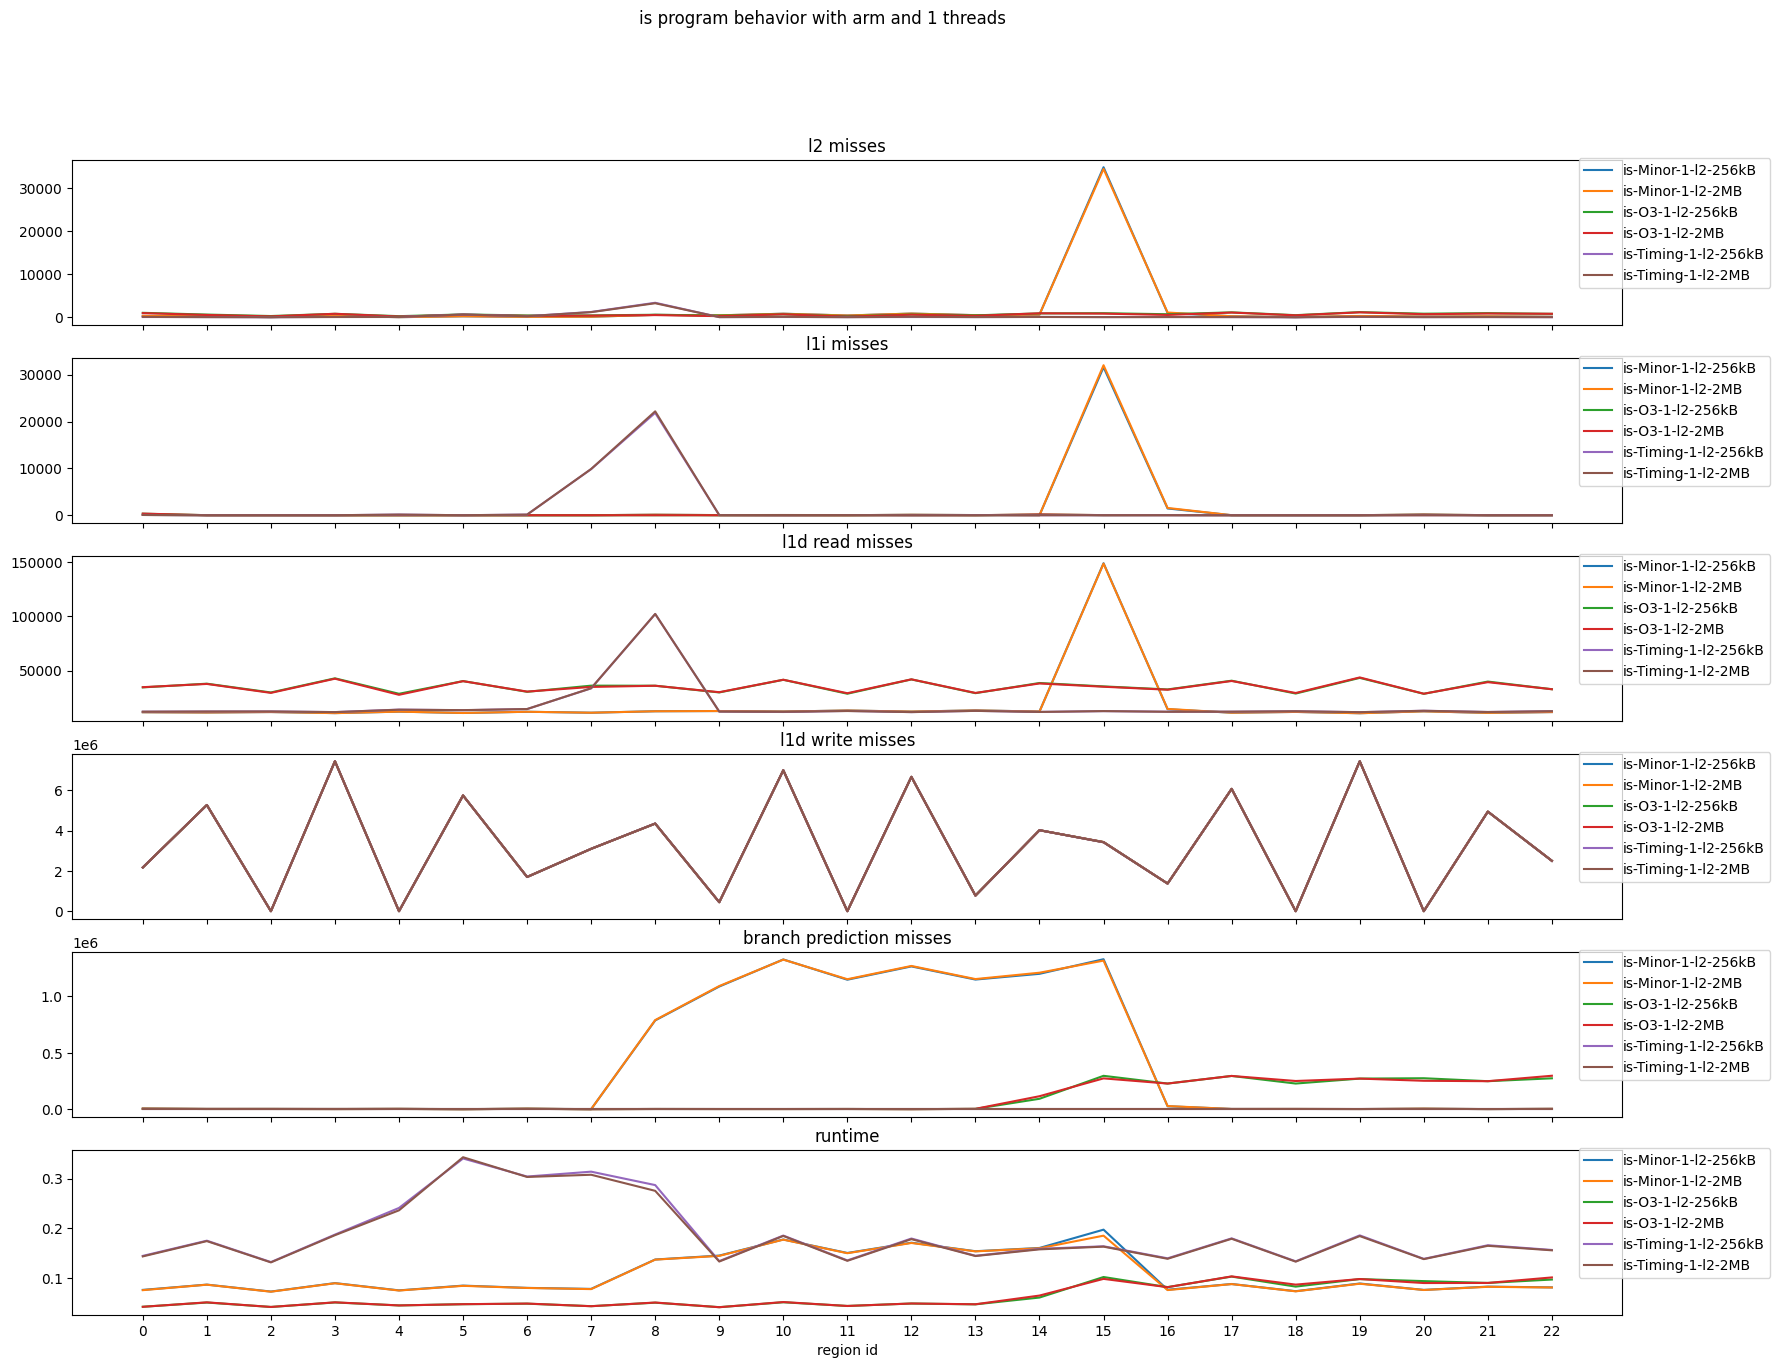

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


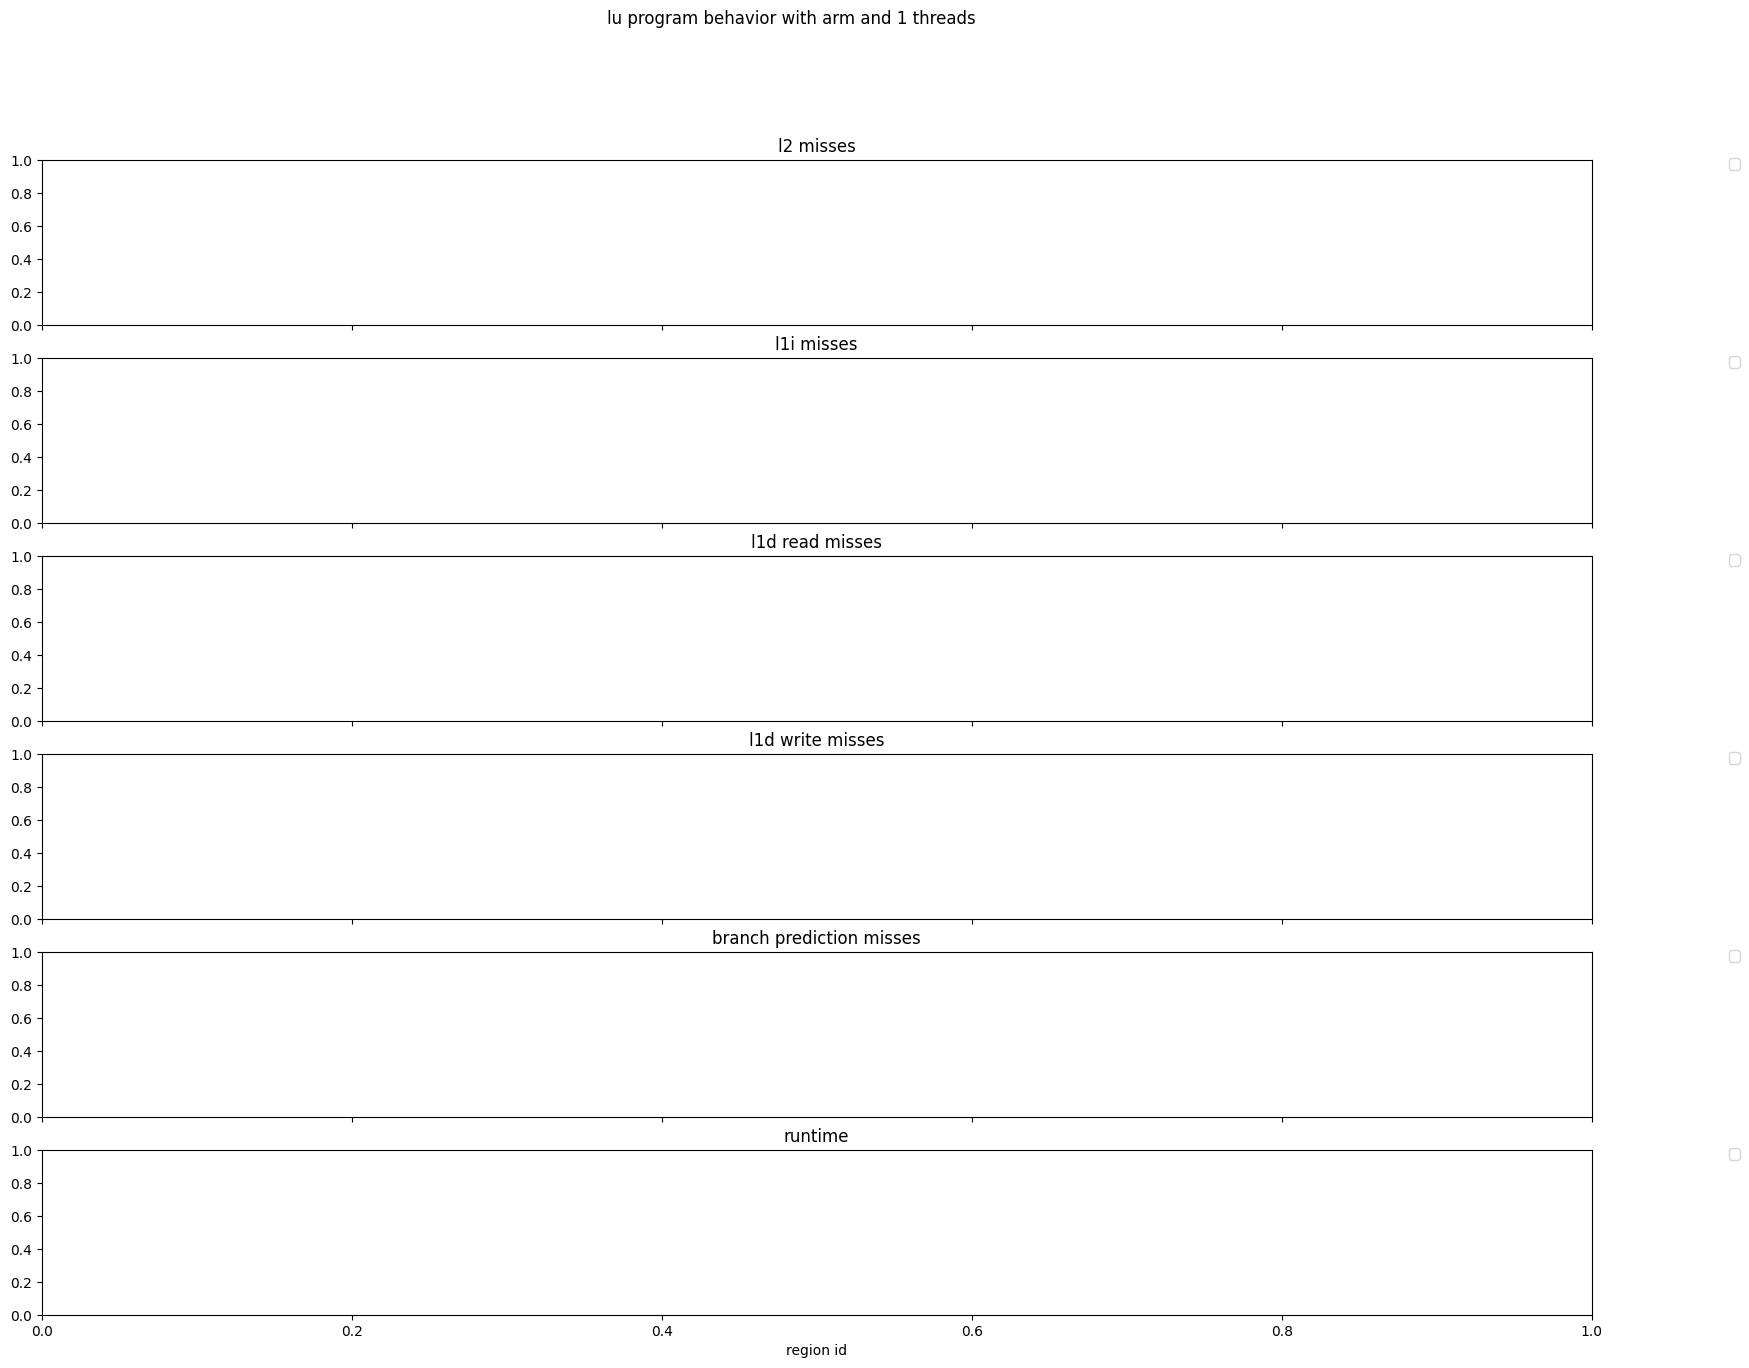

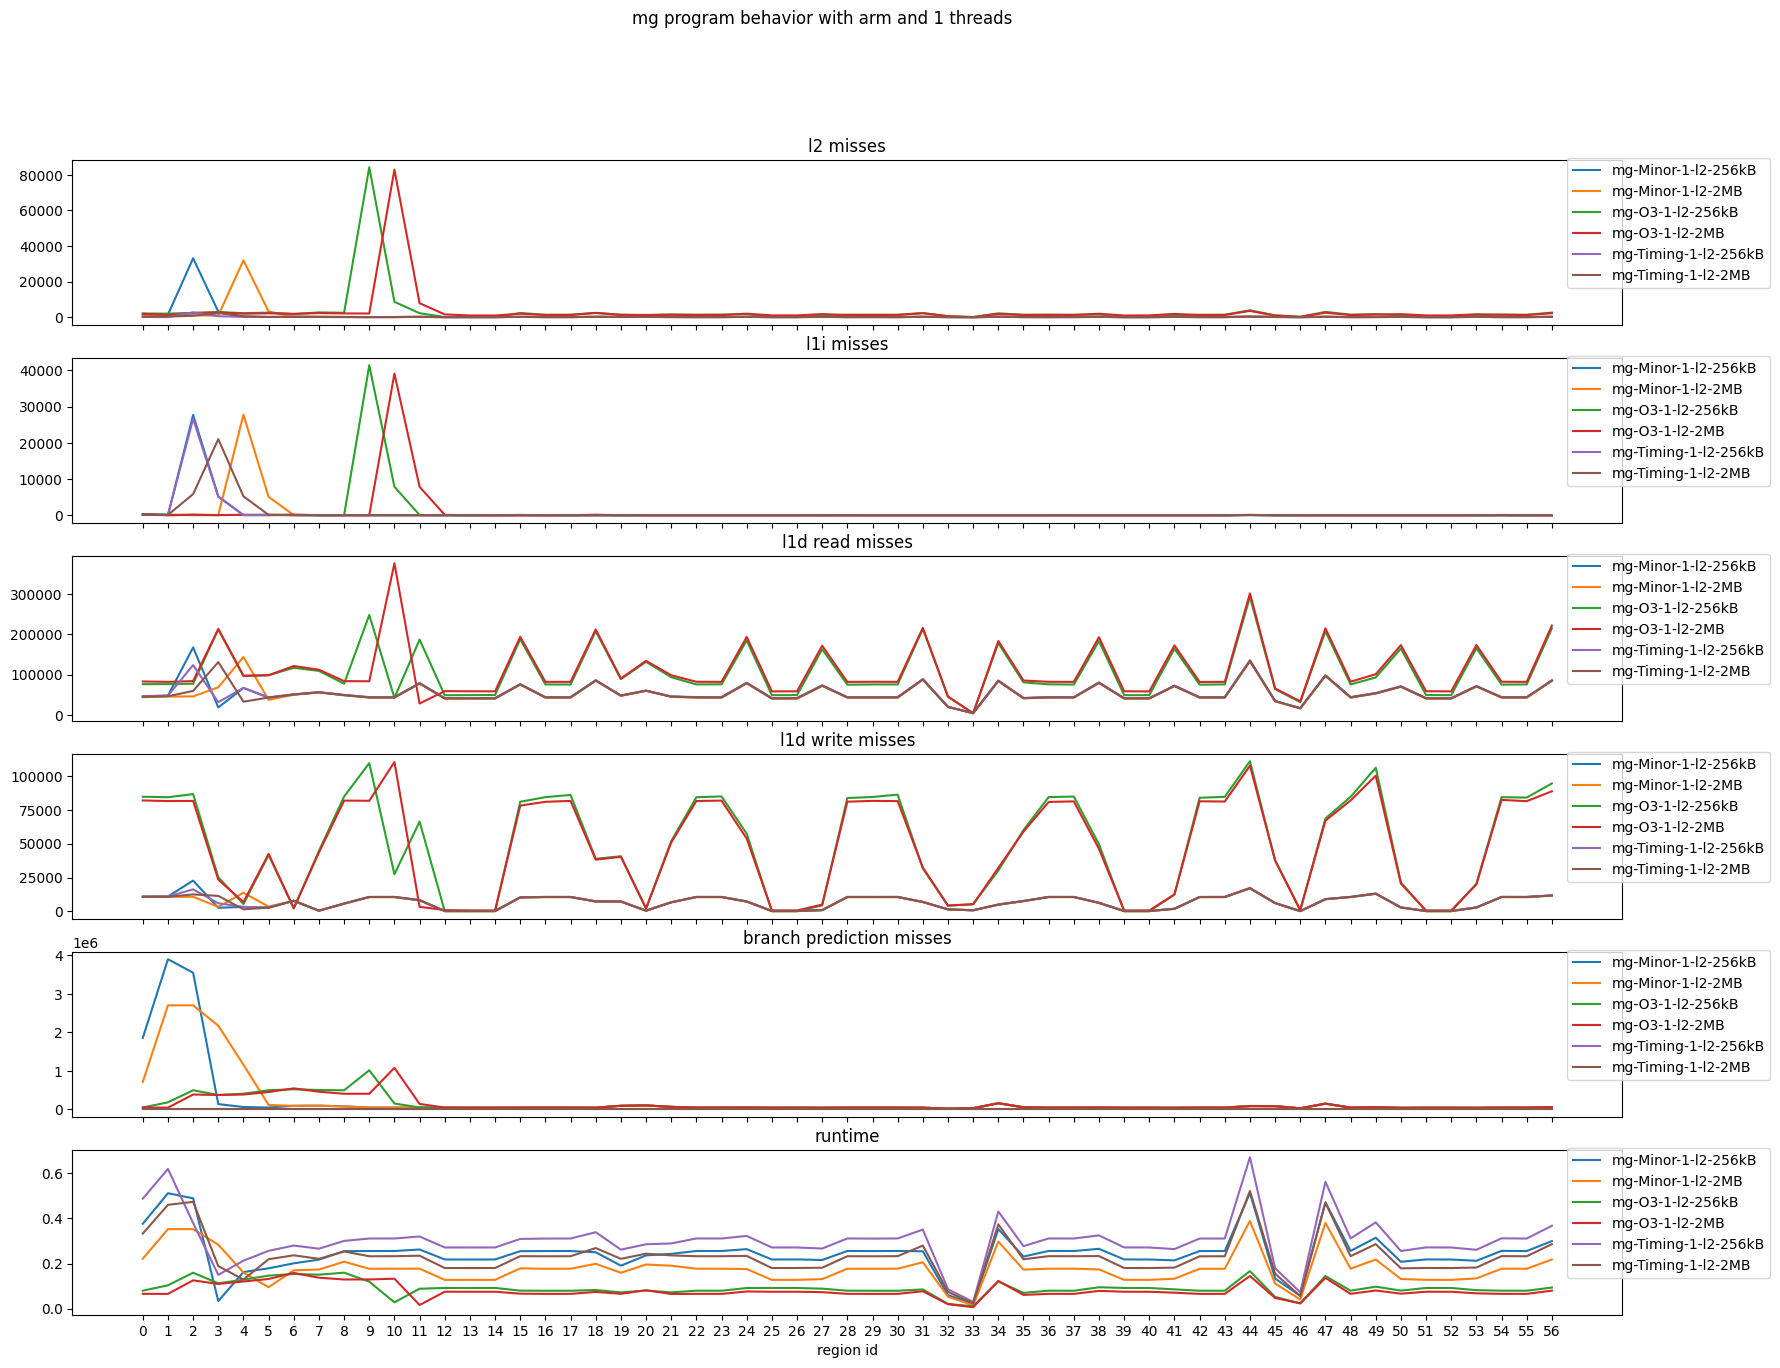

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


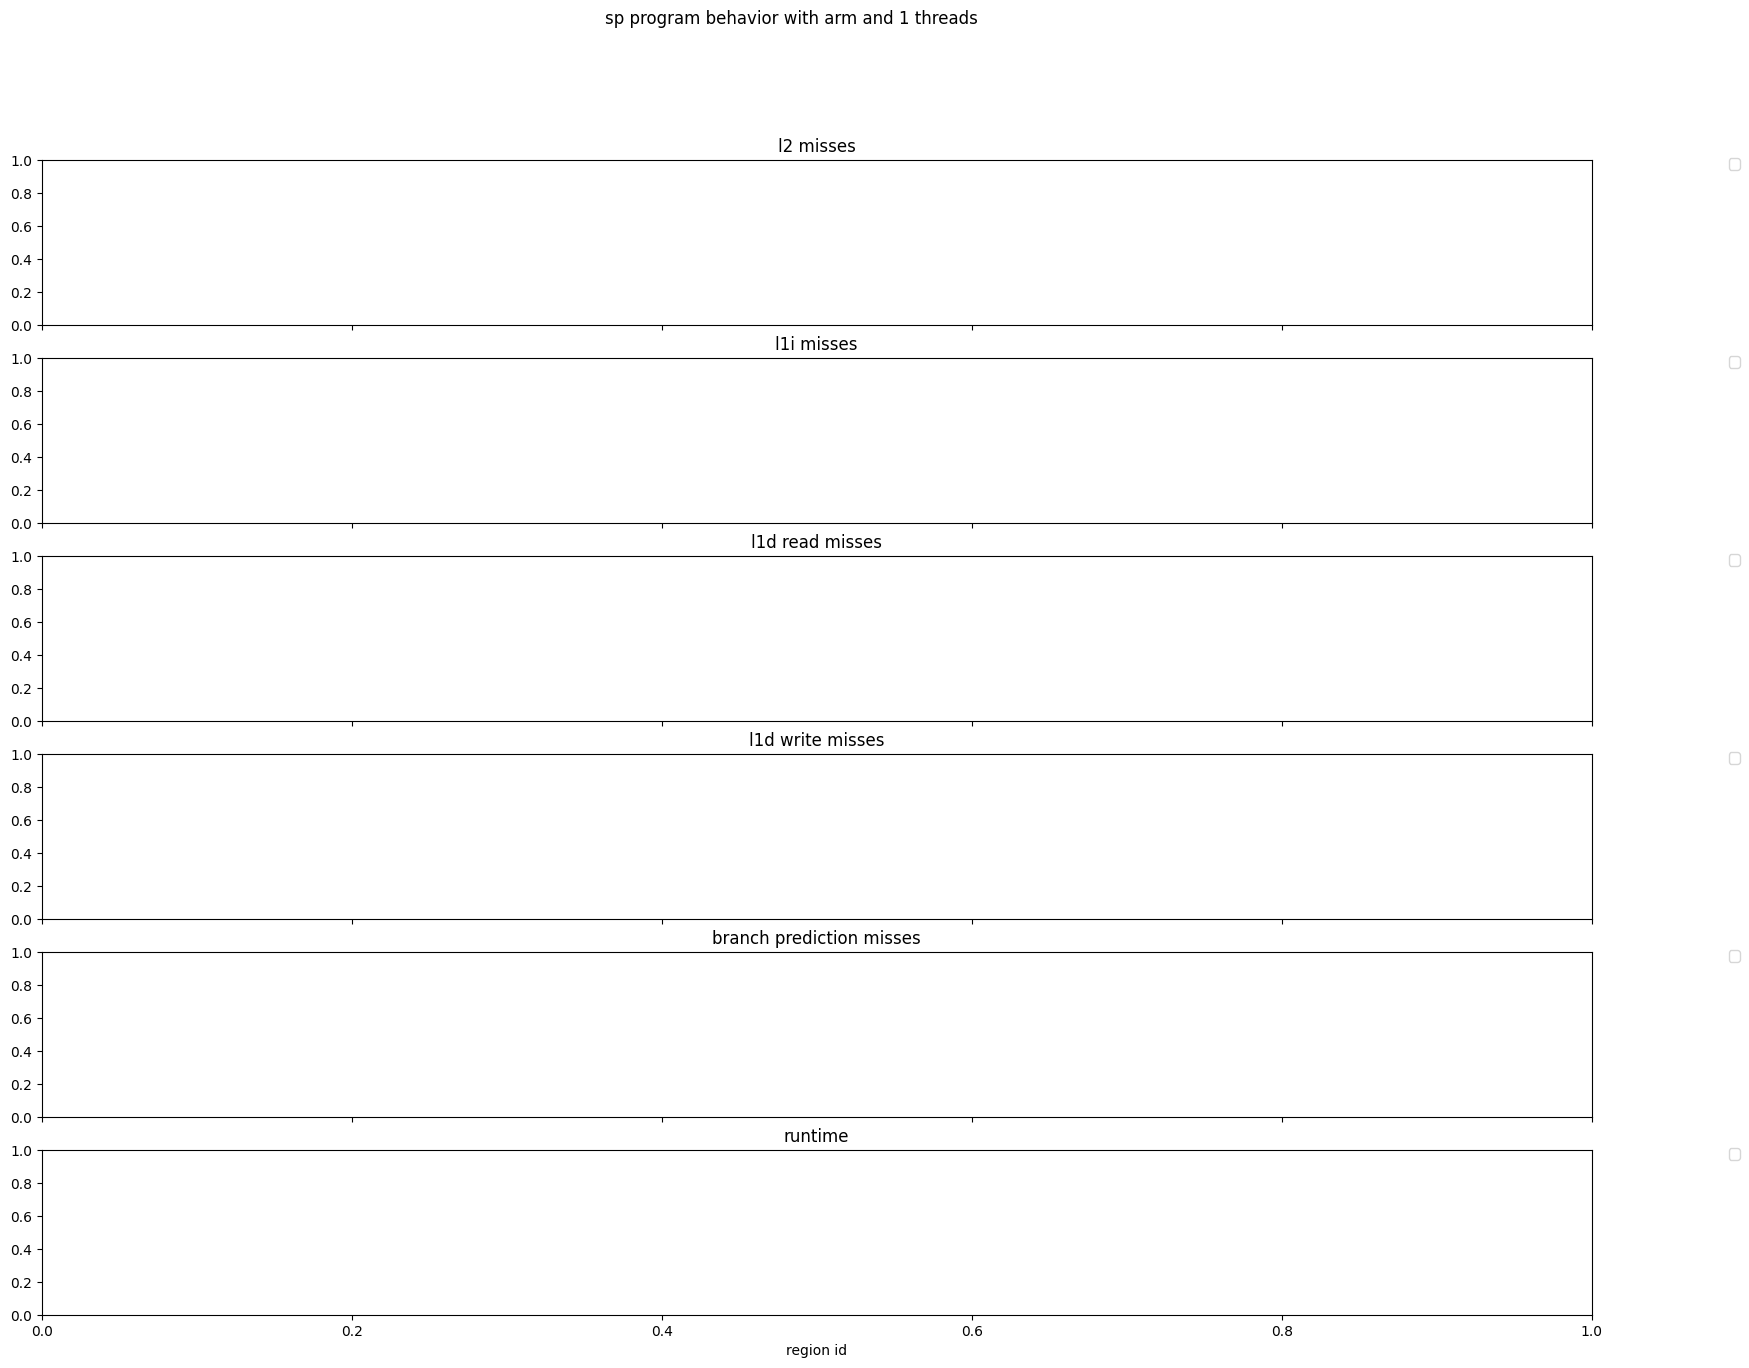

In [42]:
for bench in benchmarks:
    show_one_set_for_multiple_config("arm",bench,"1")

### all bbf for highest frequent bb (arm 4 threads)

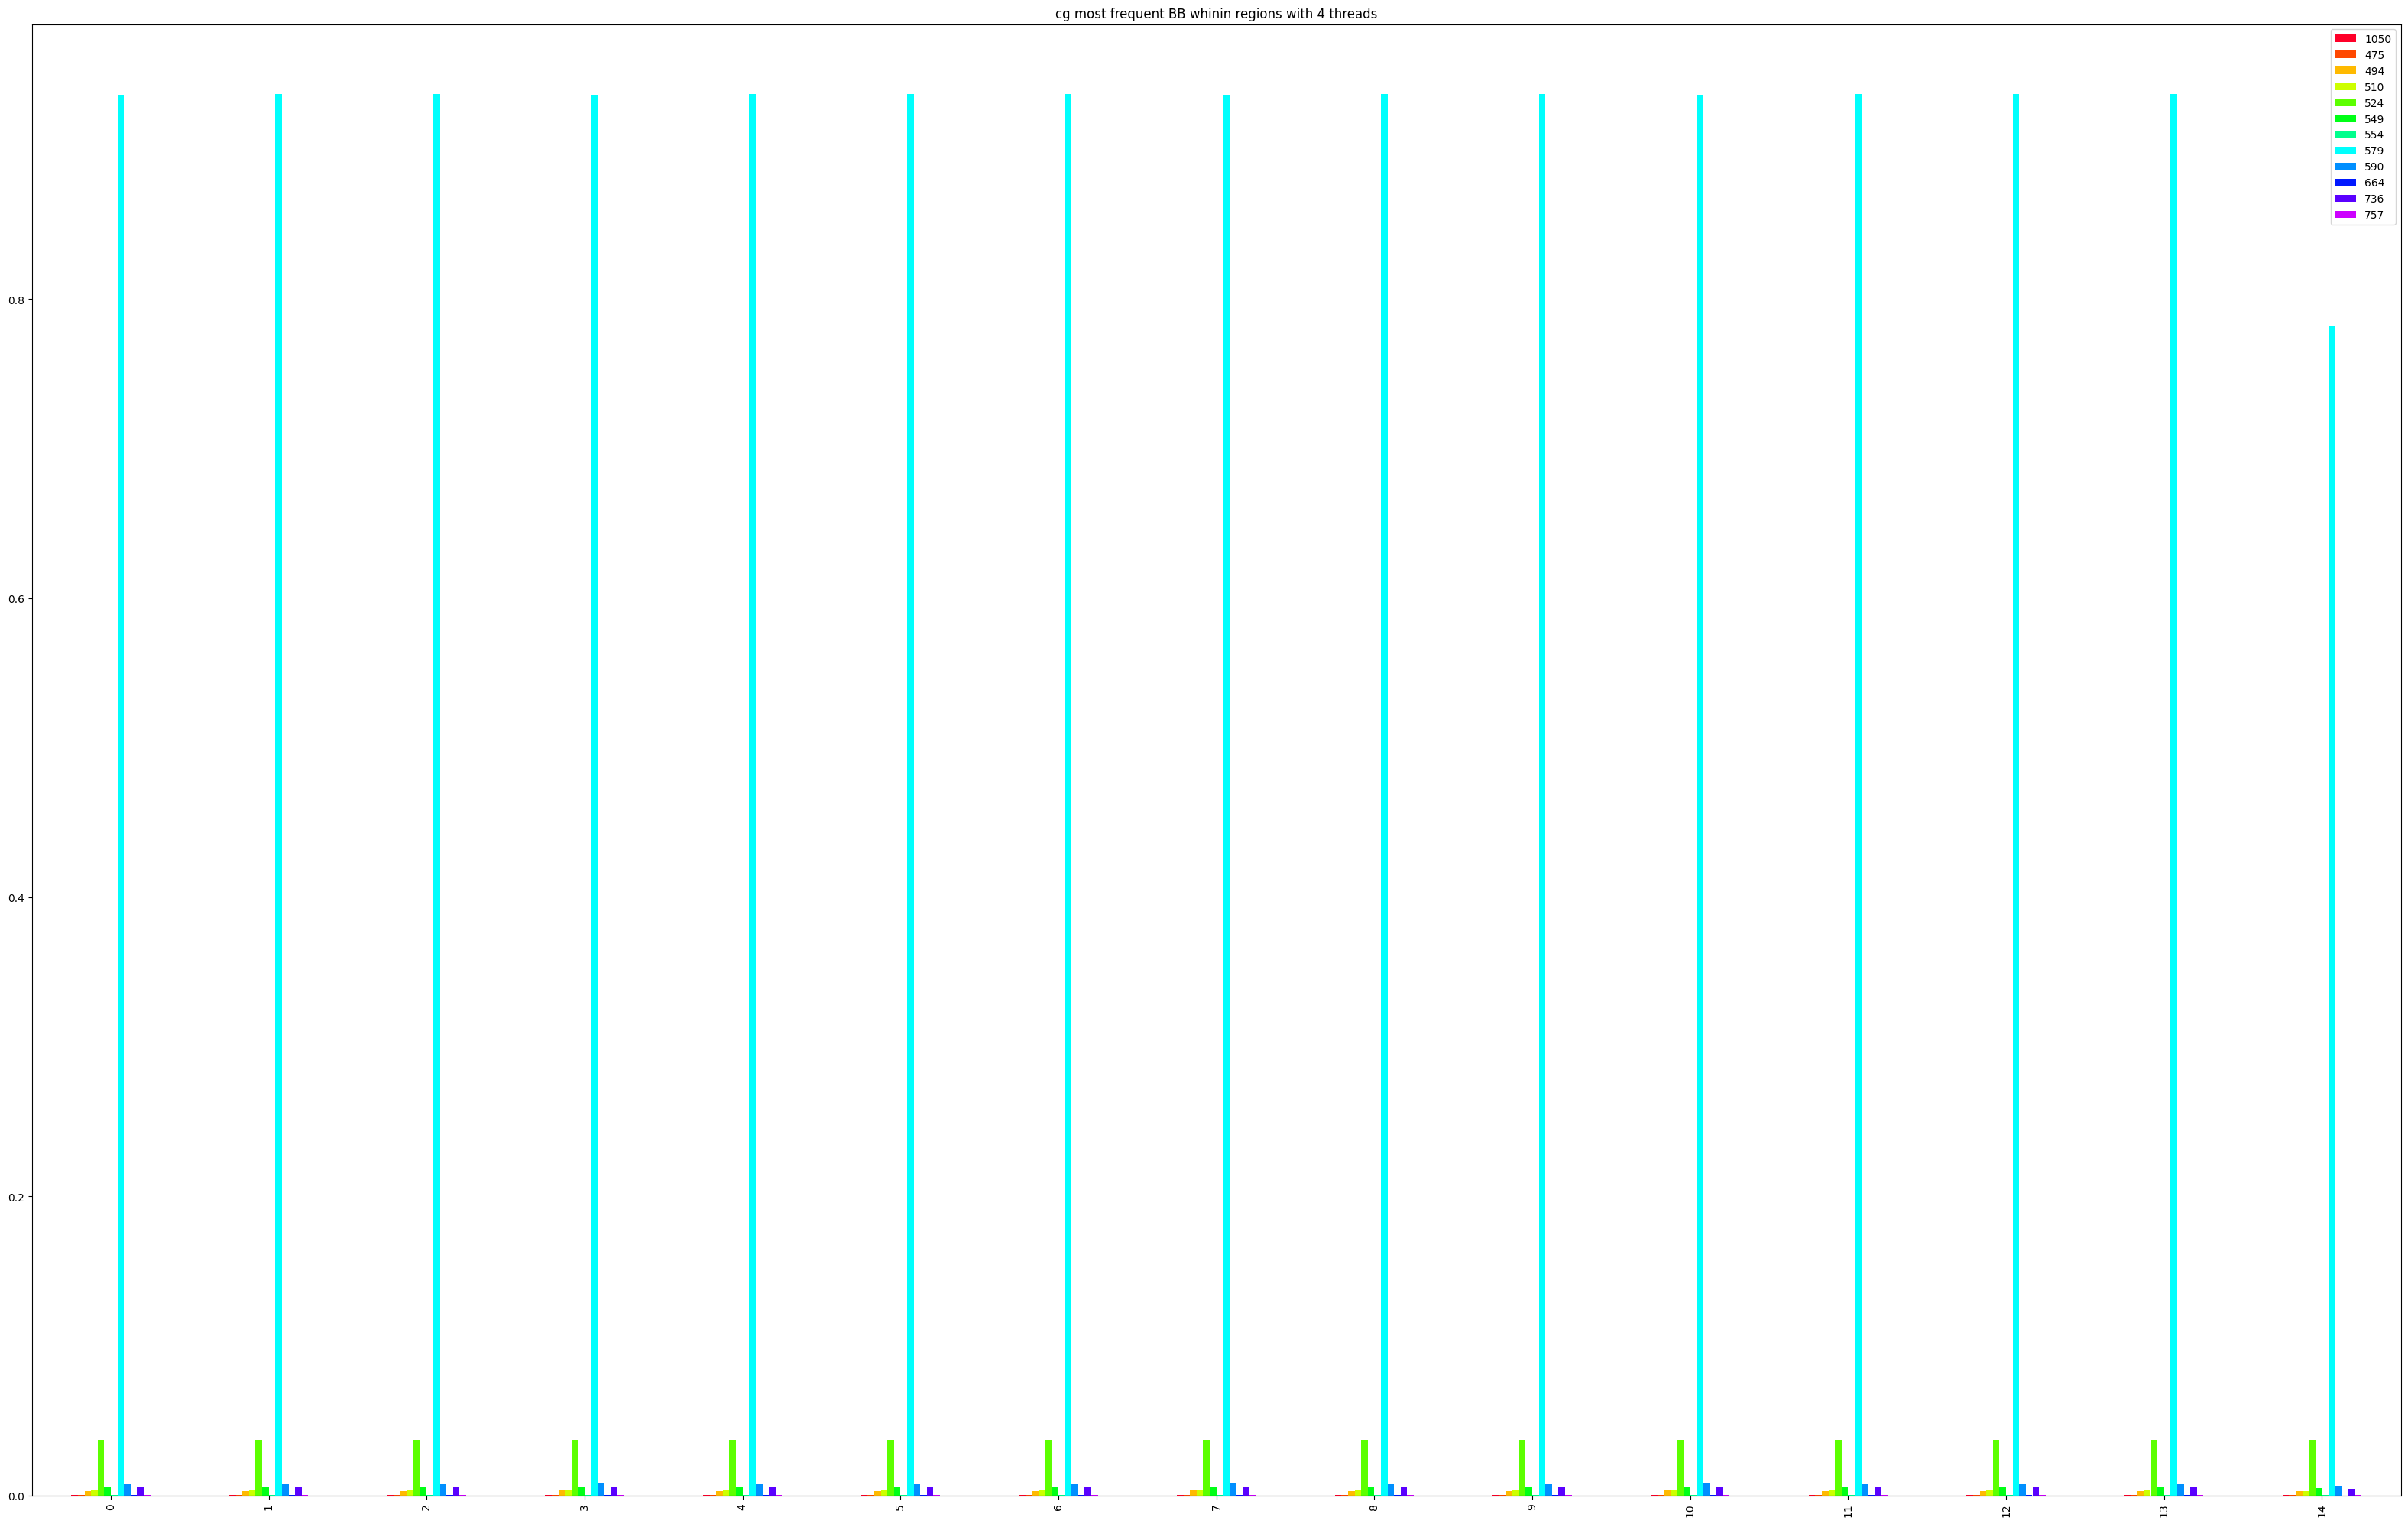

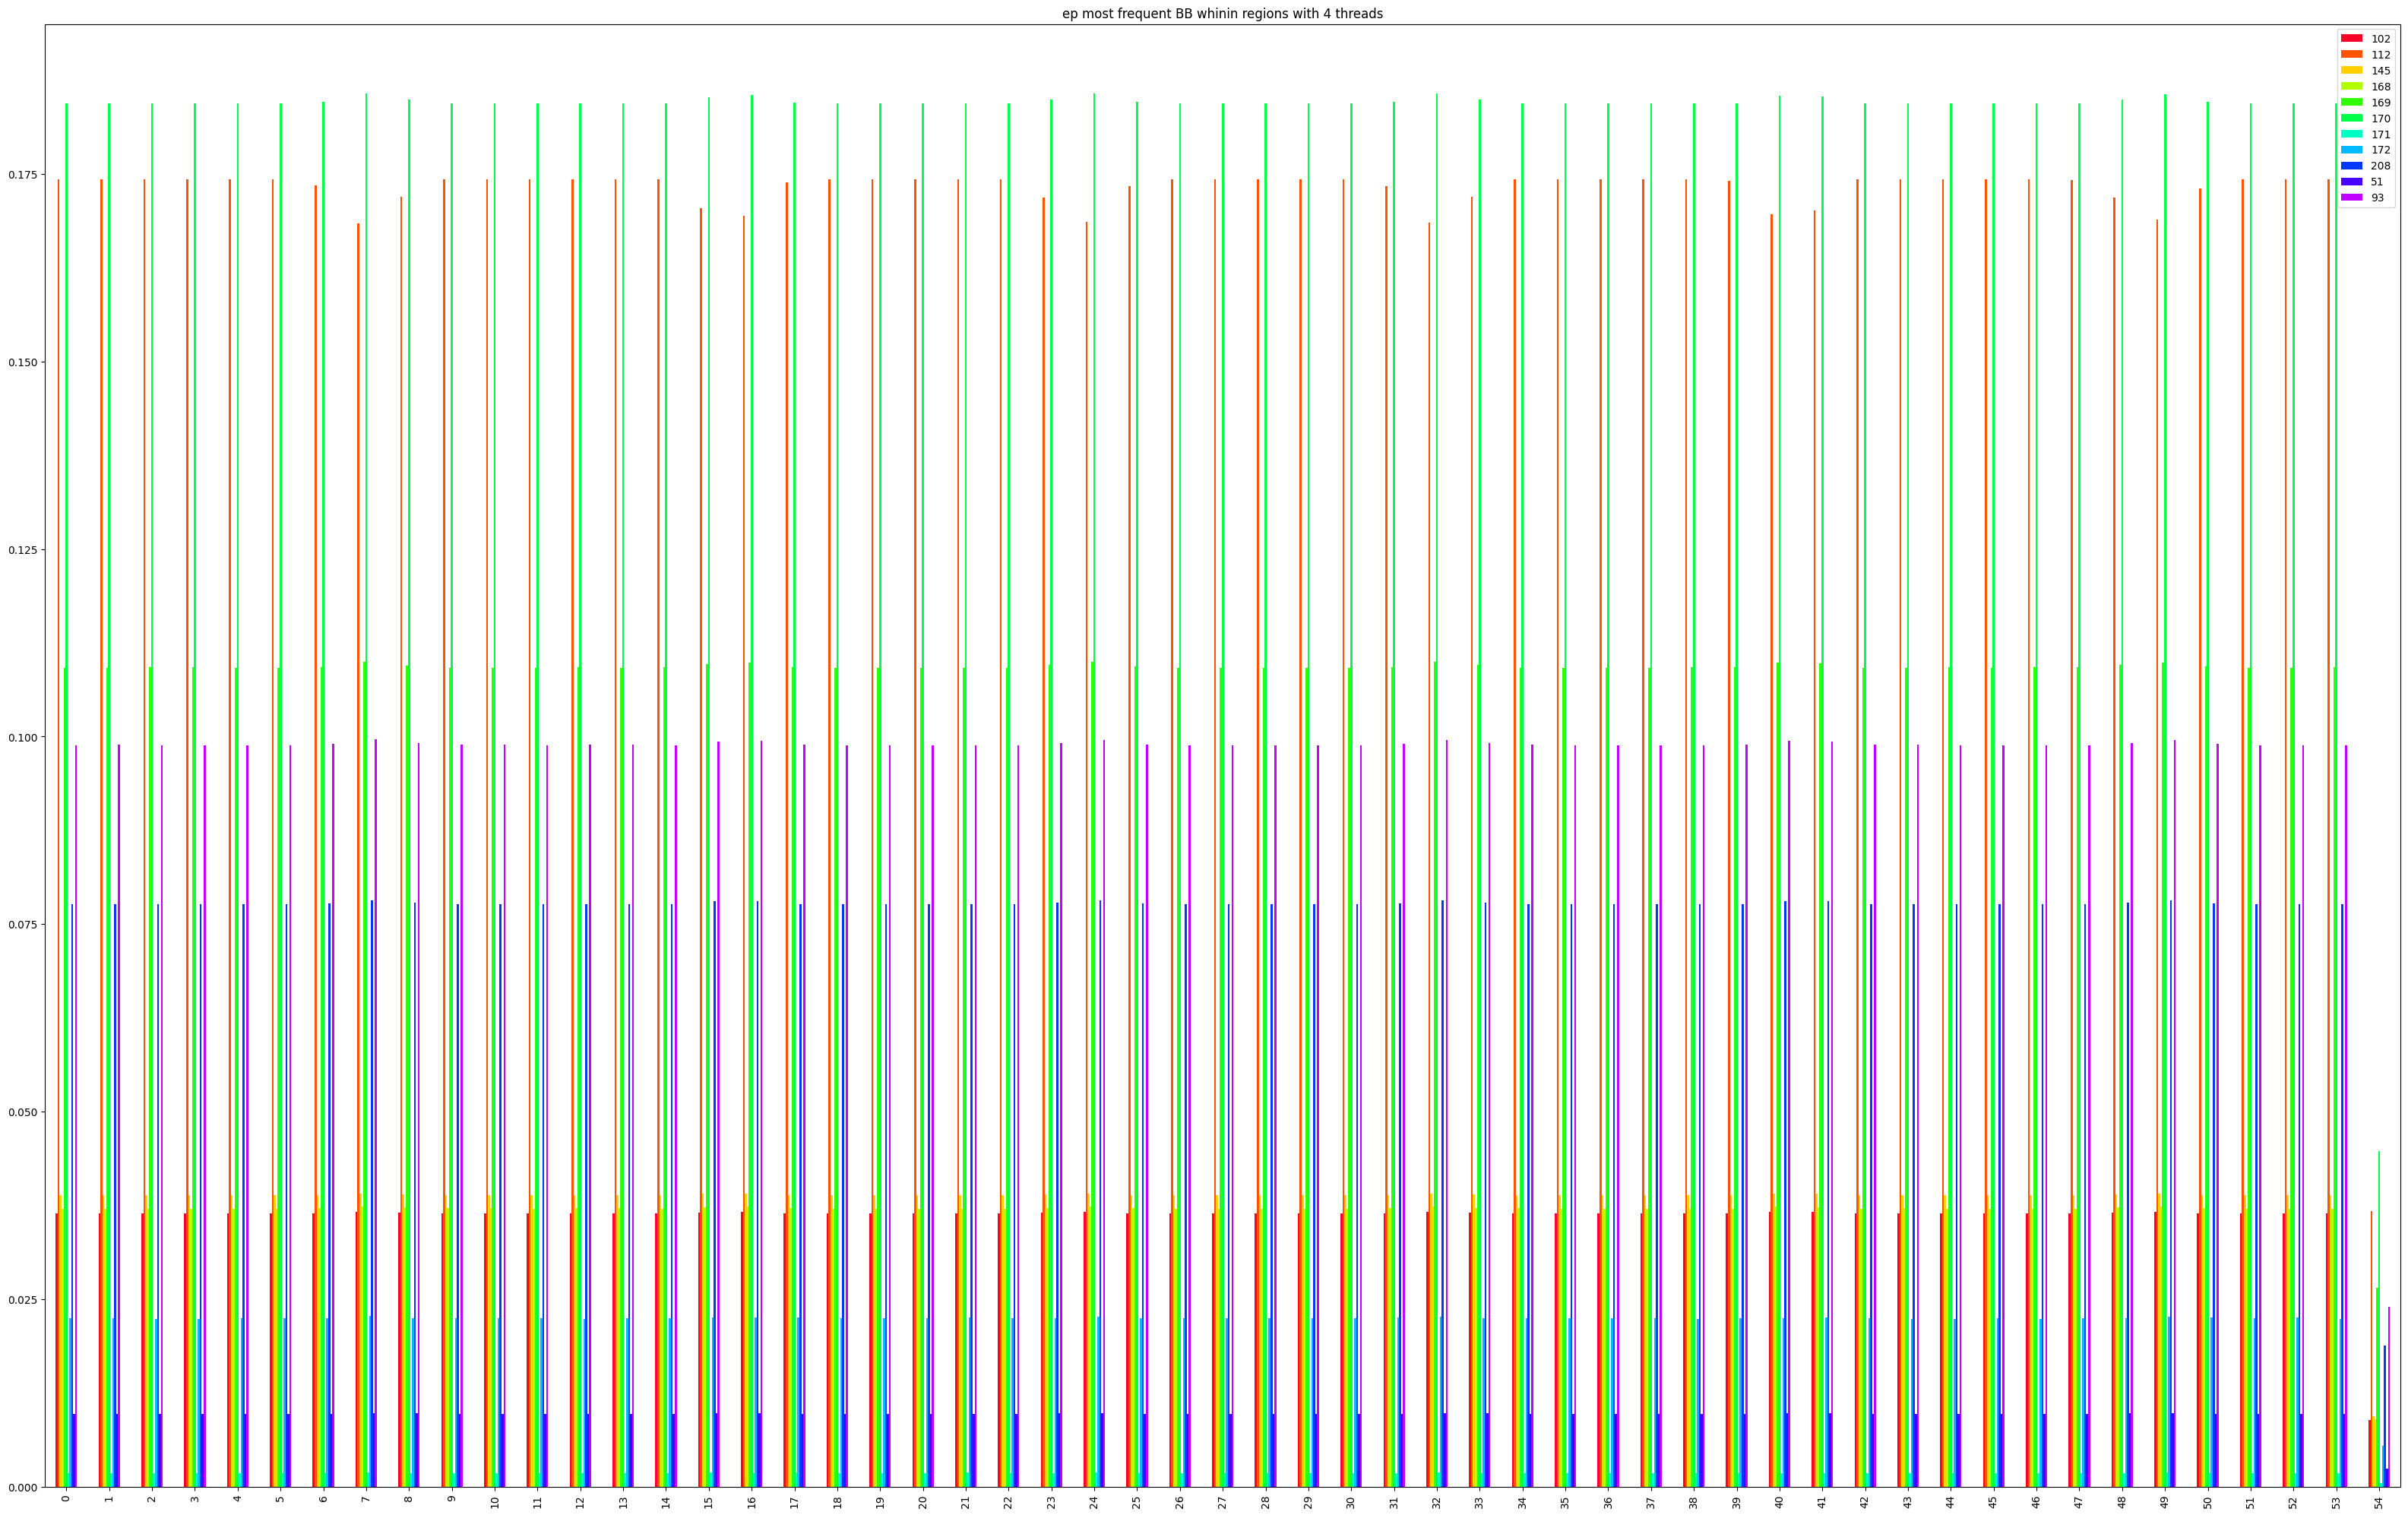

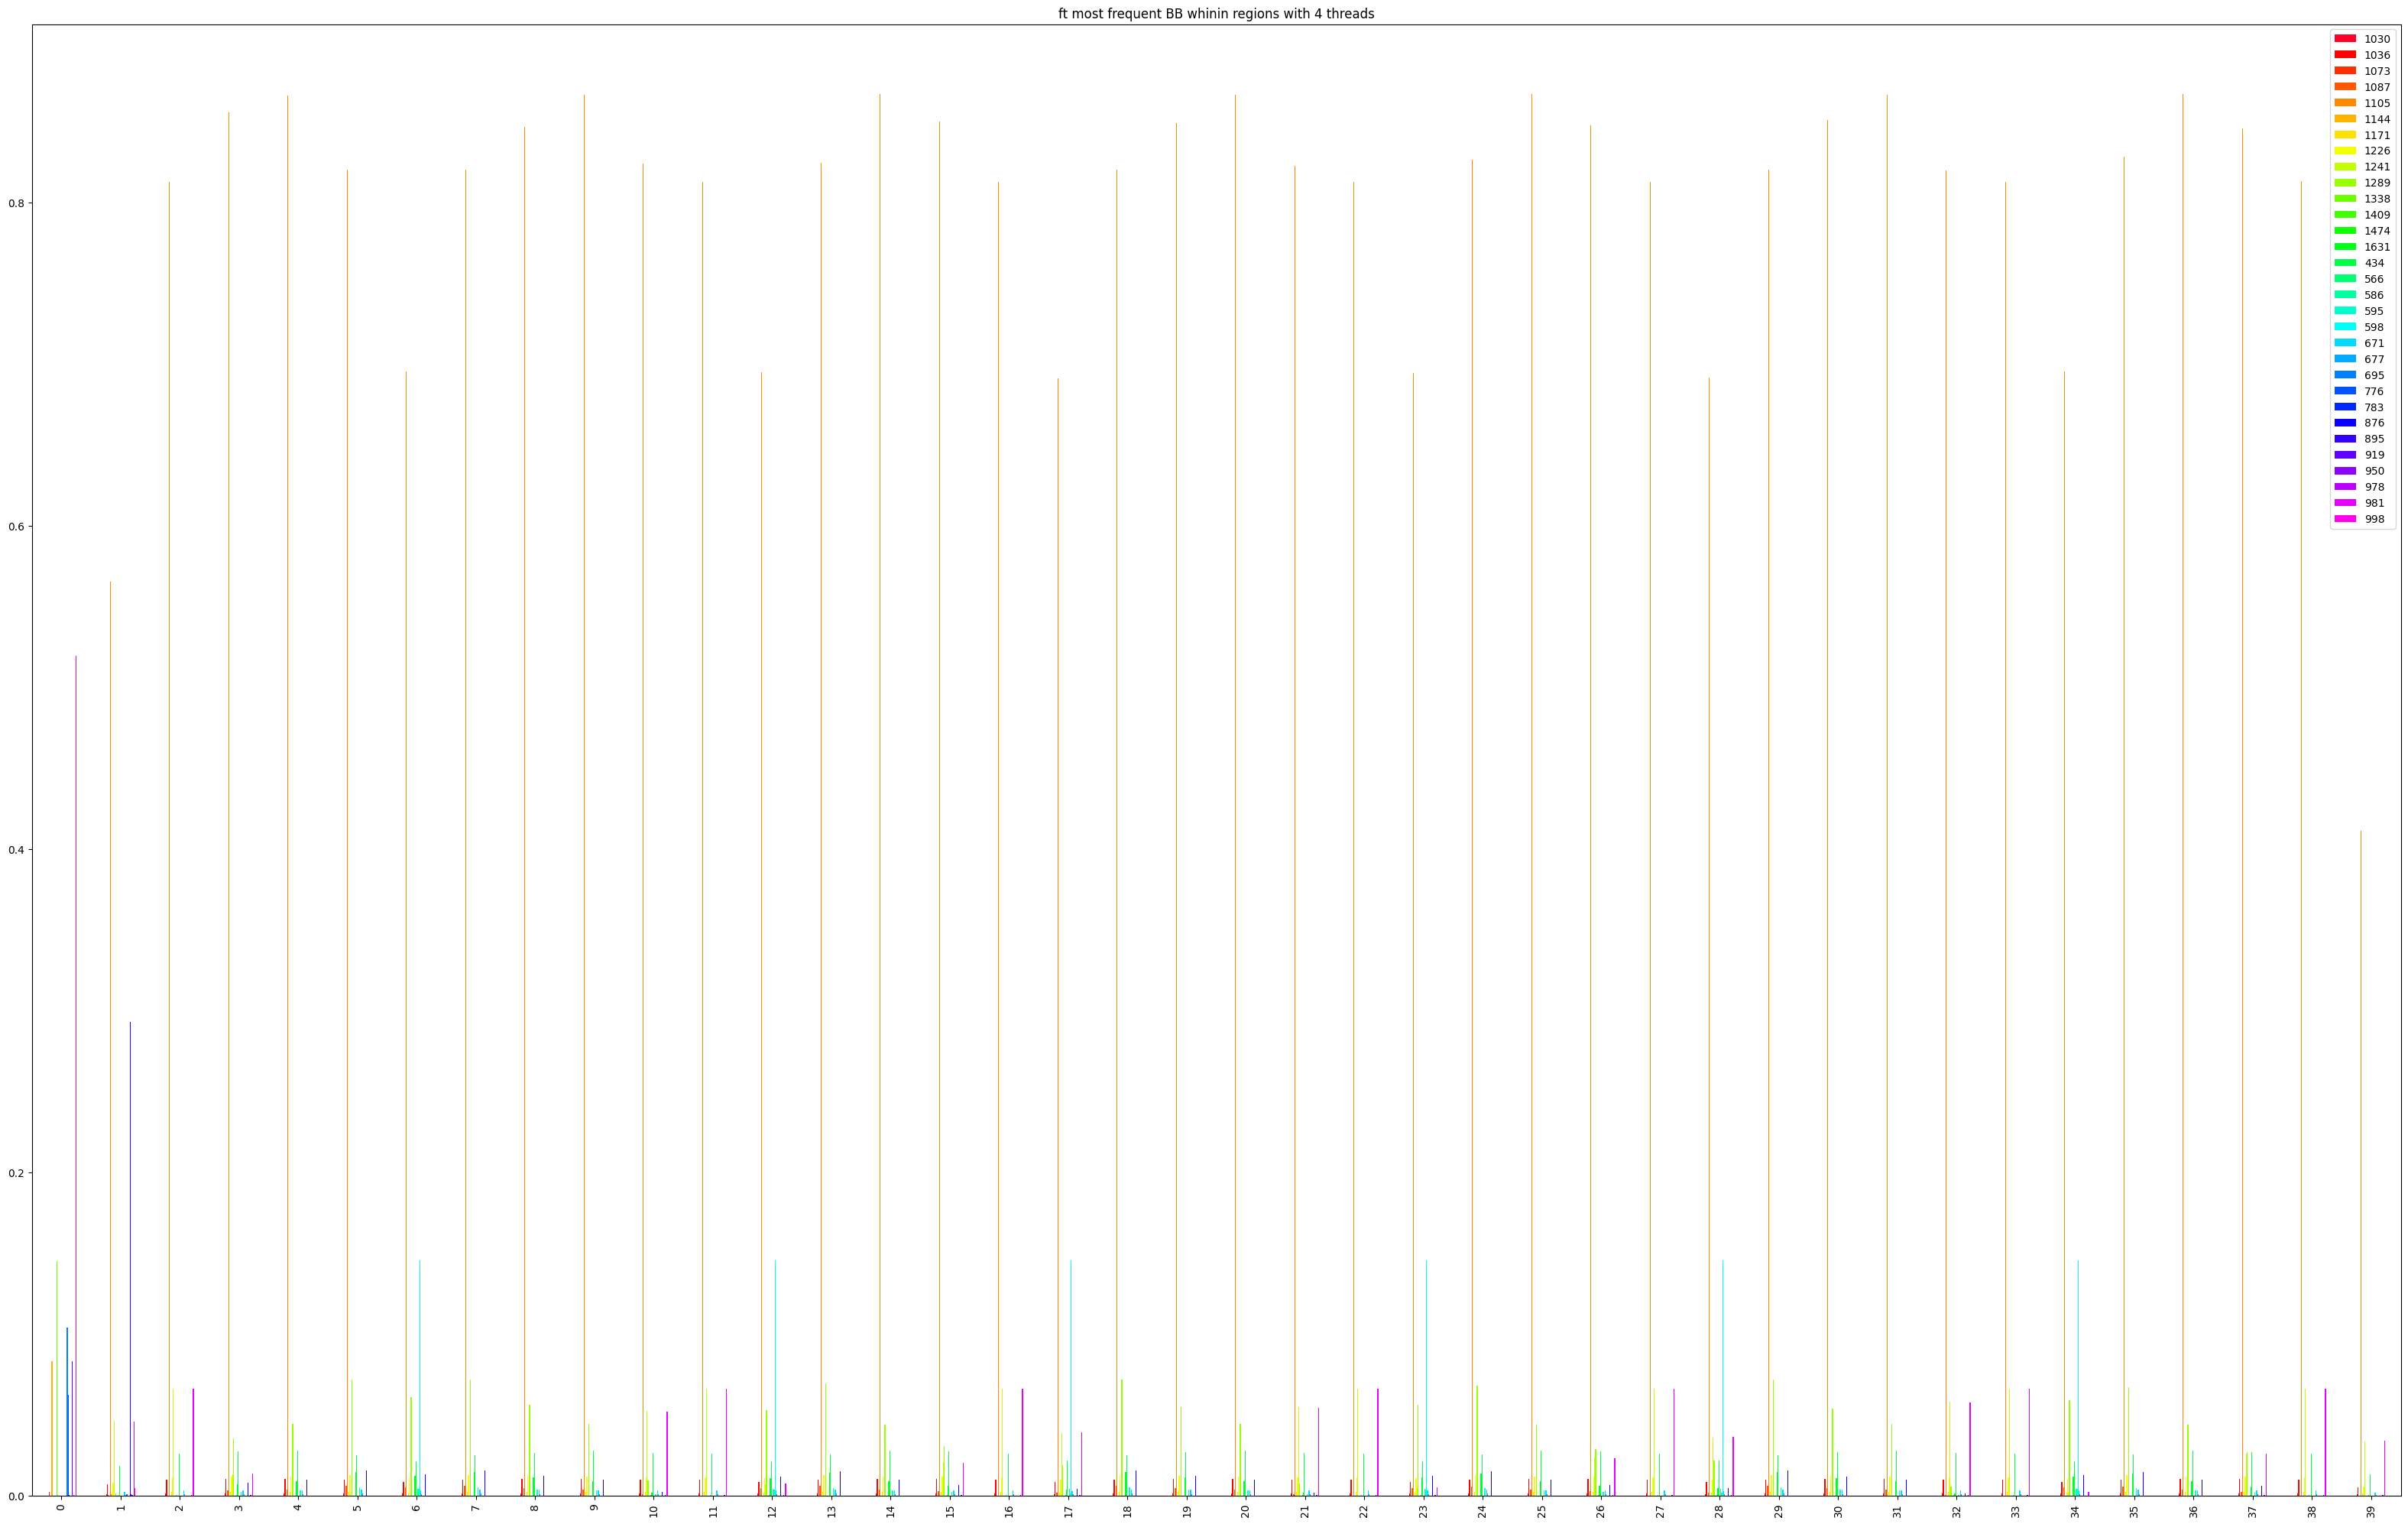

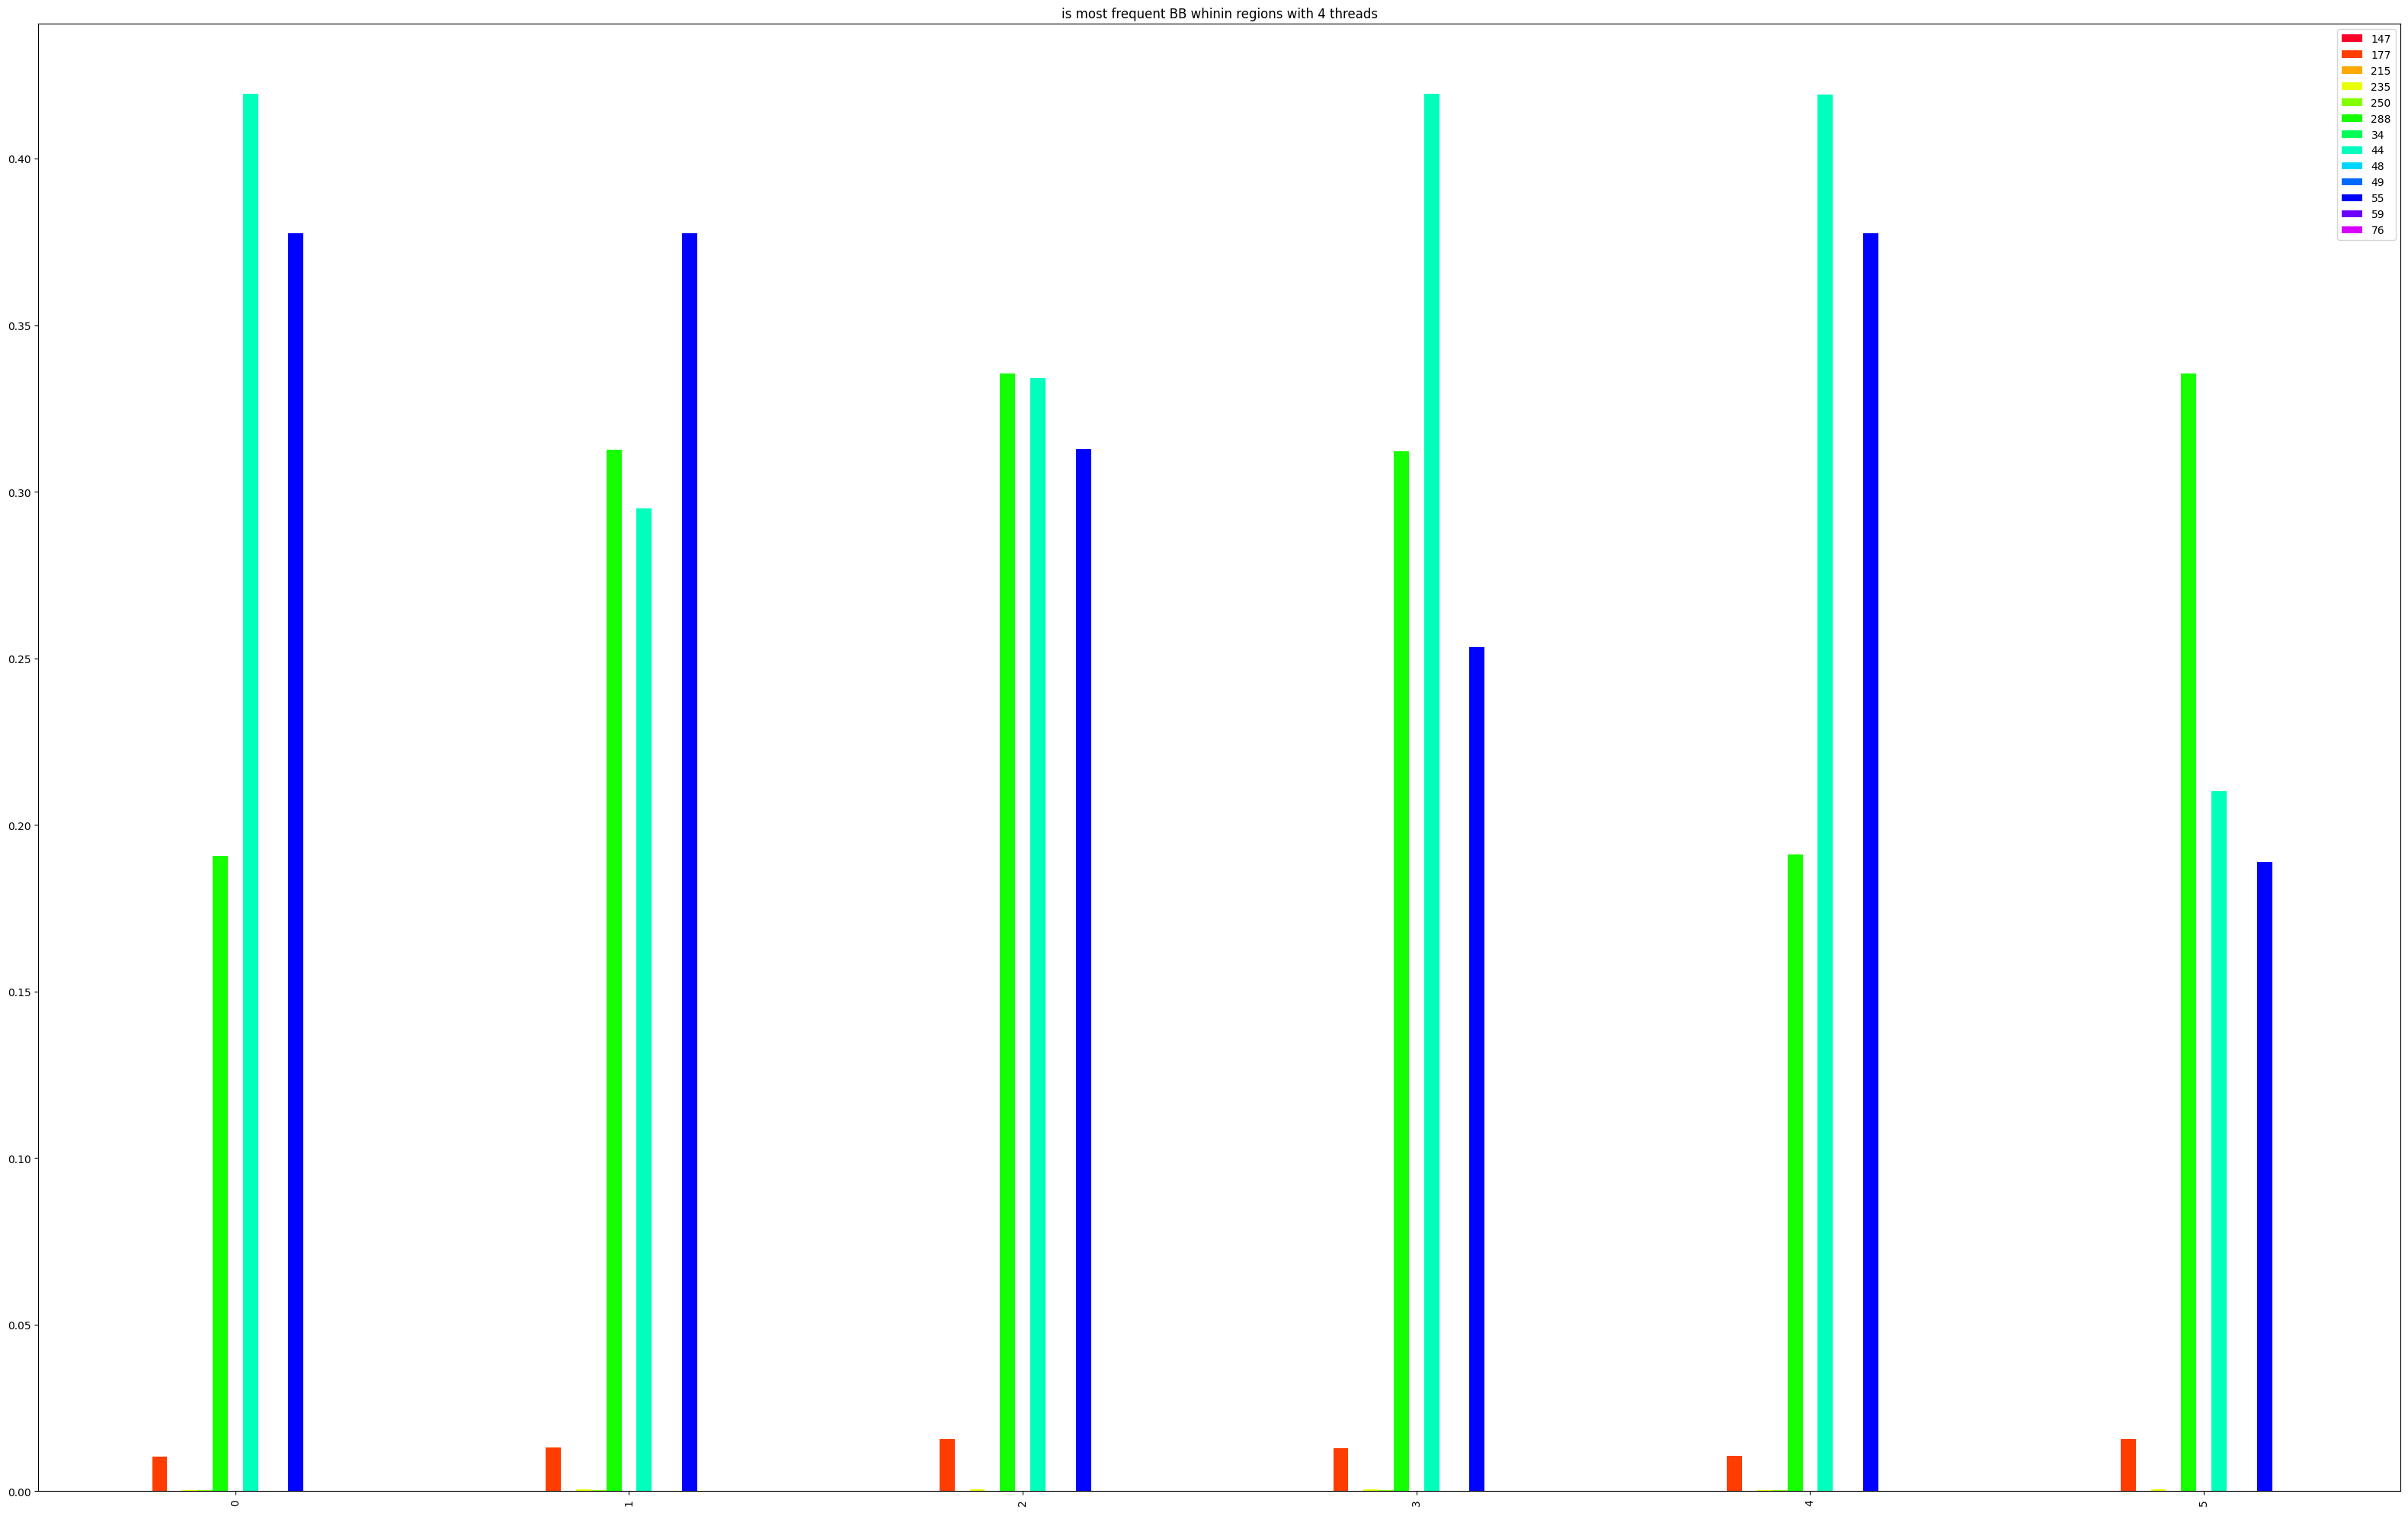

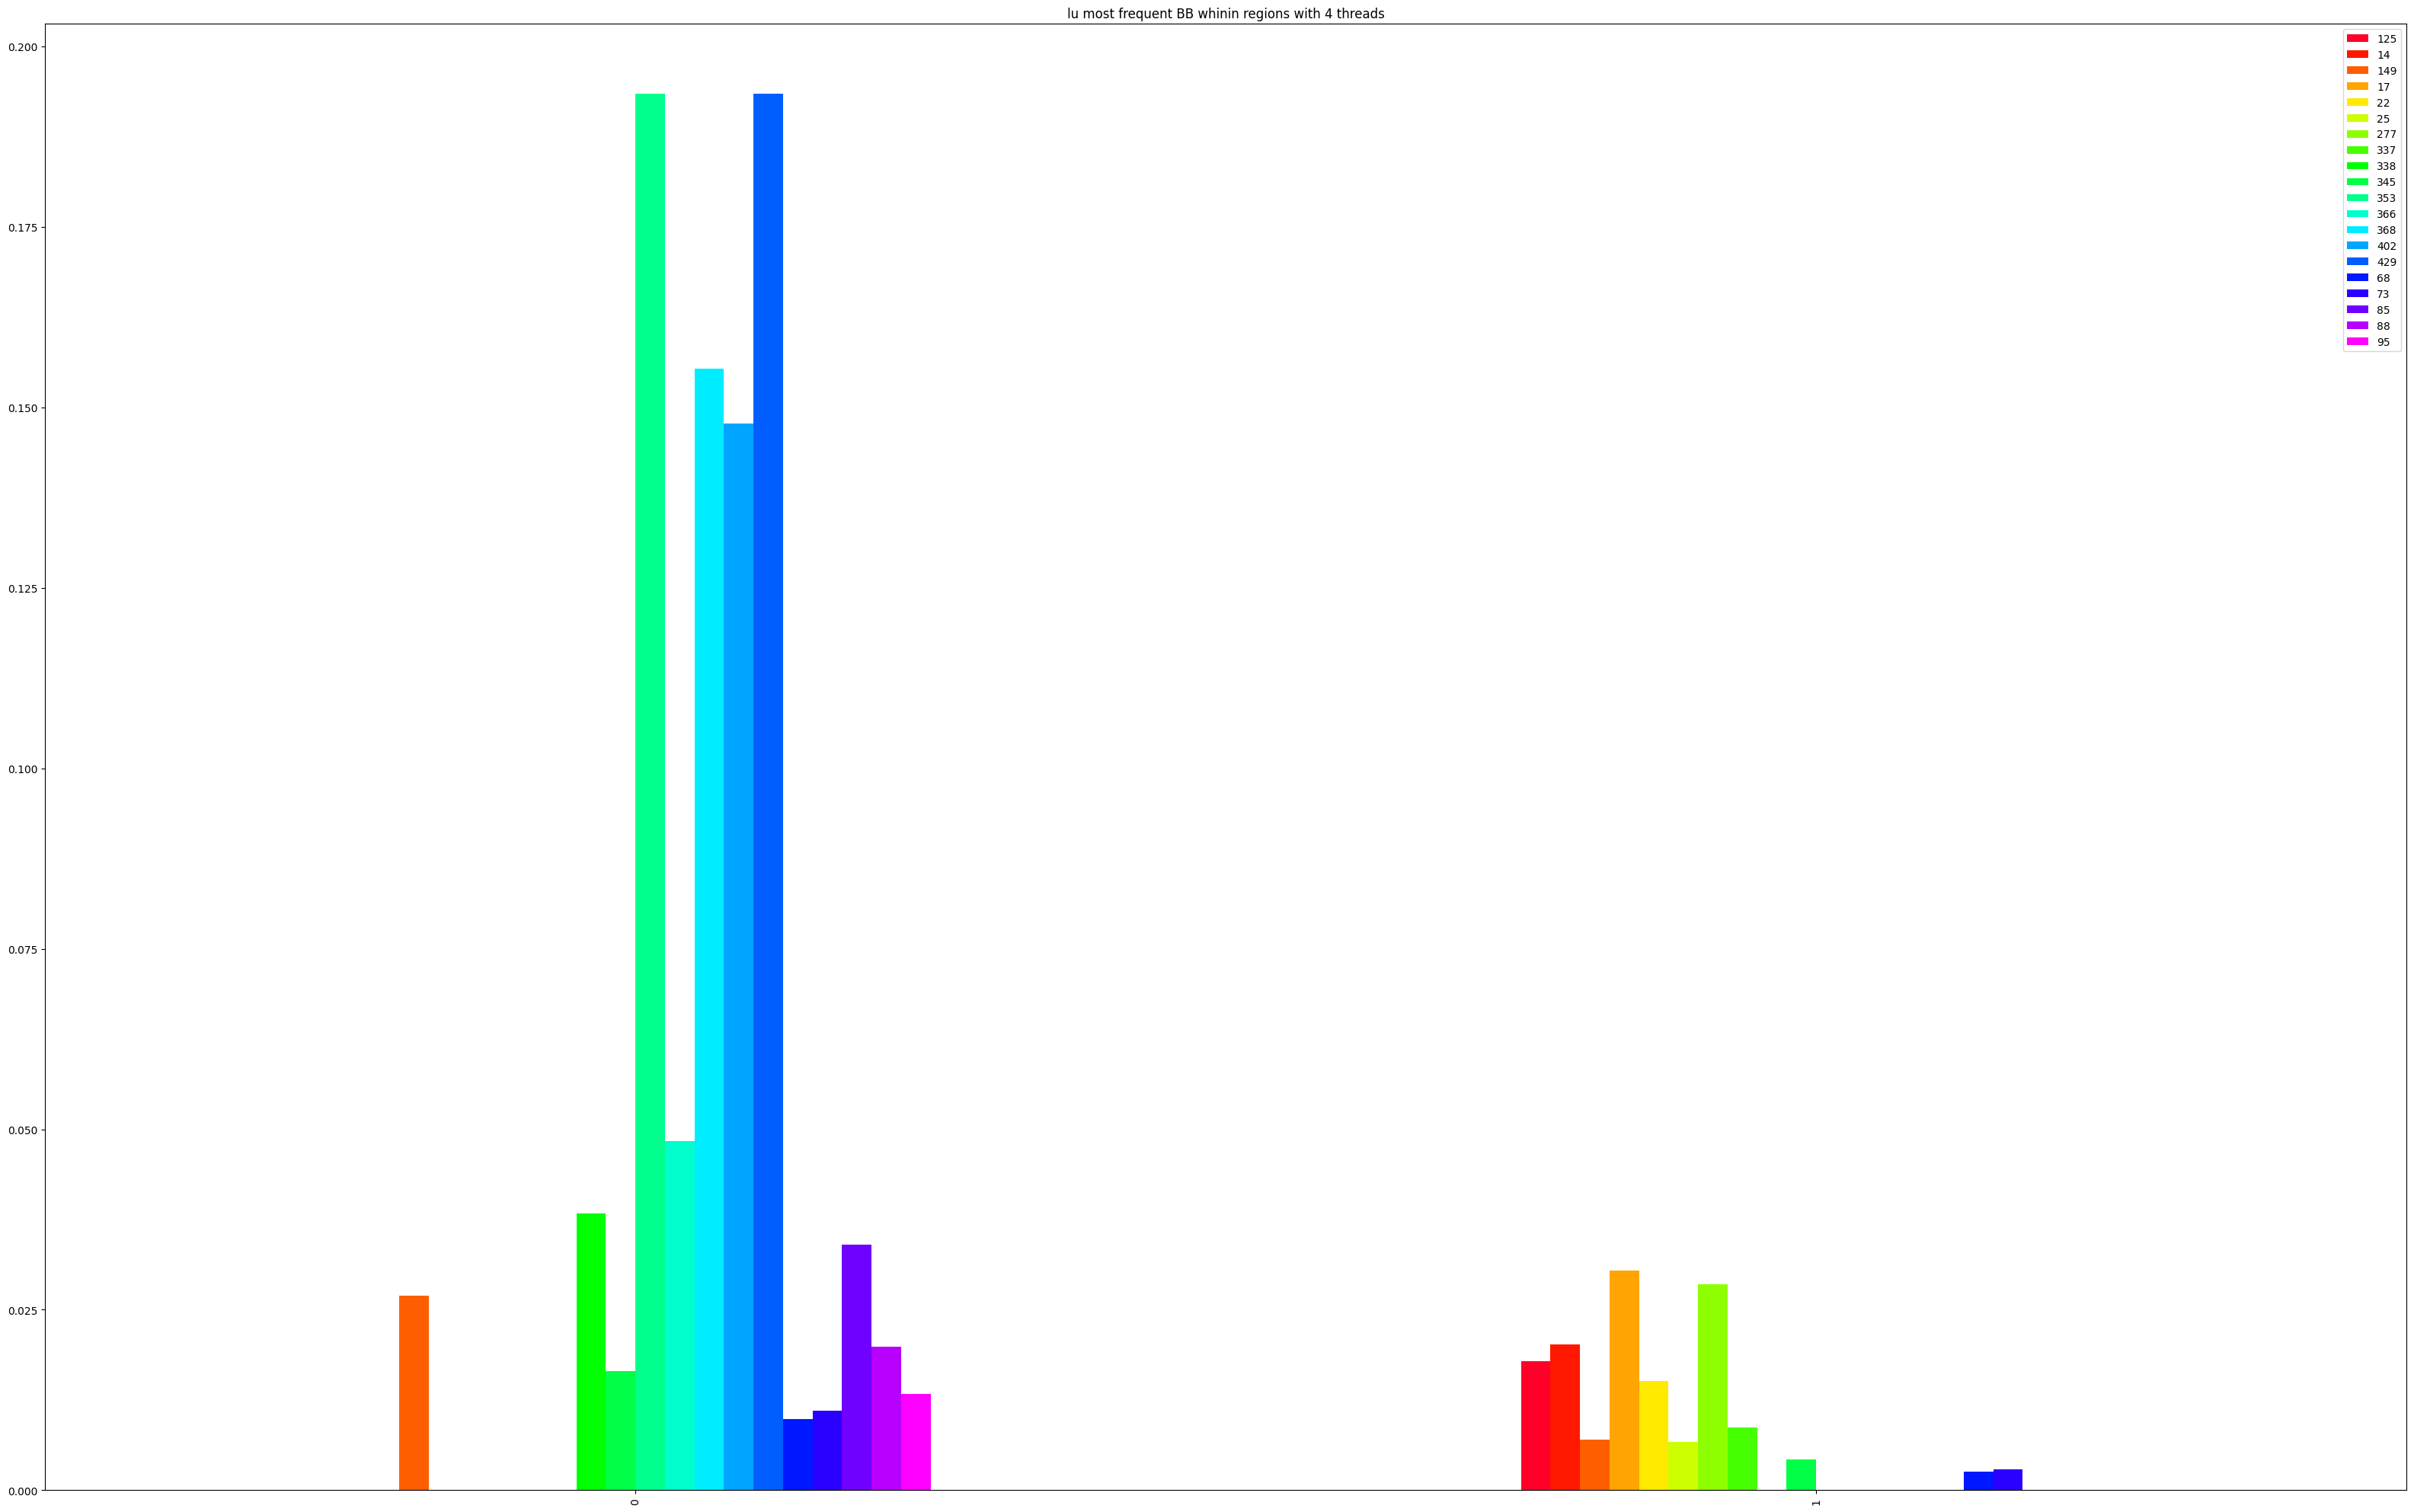

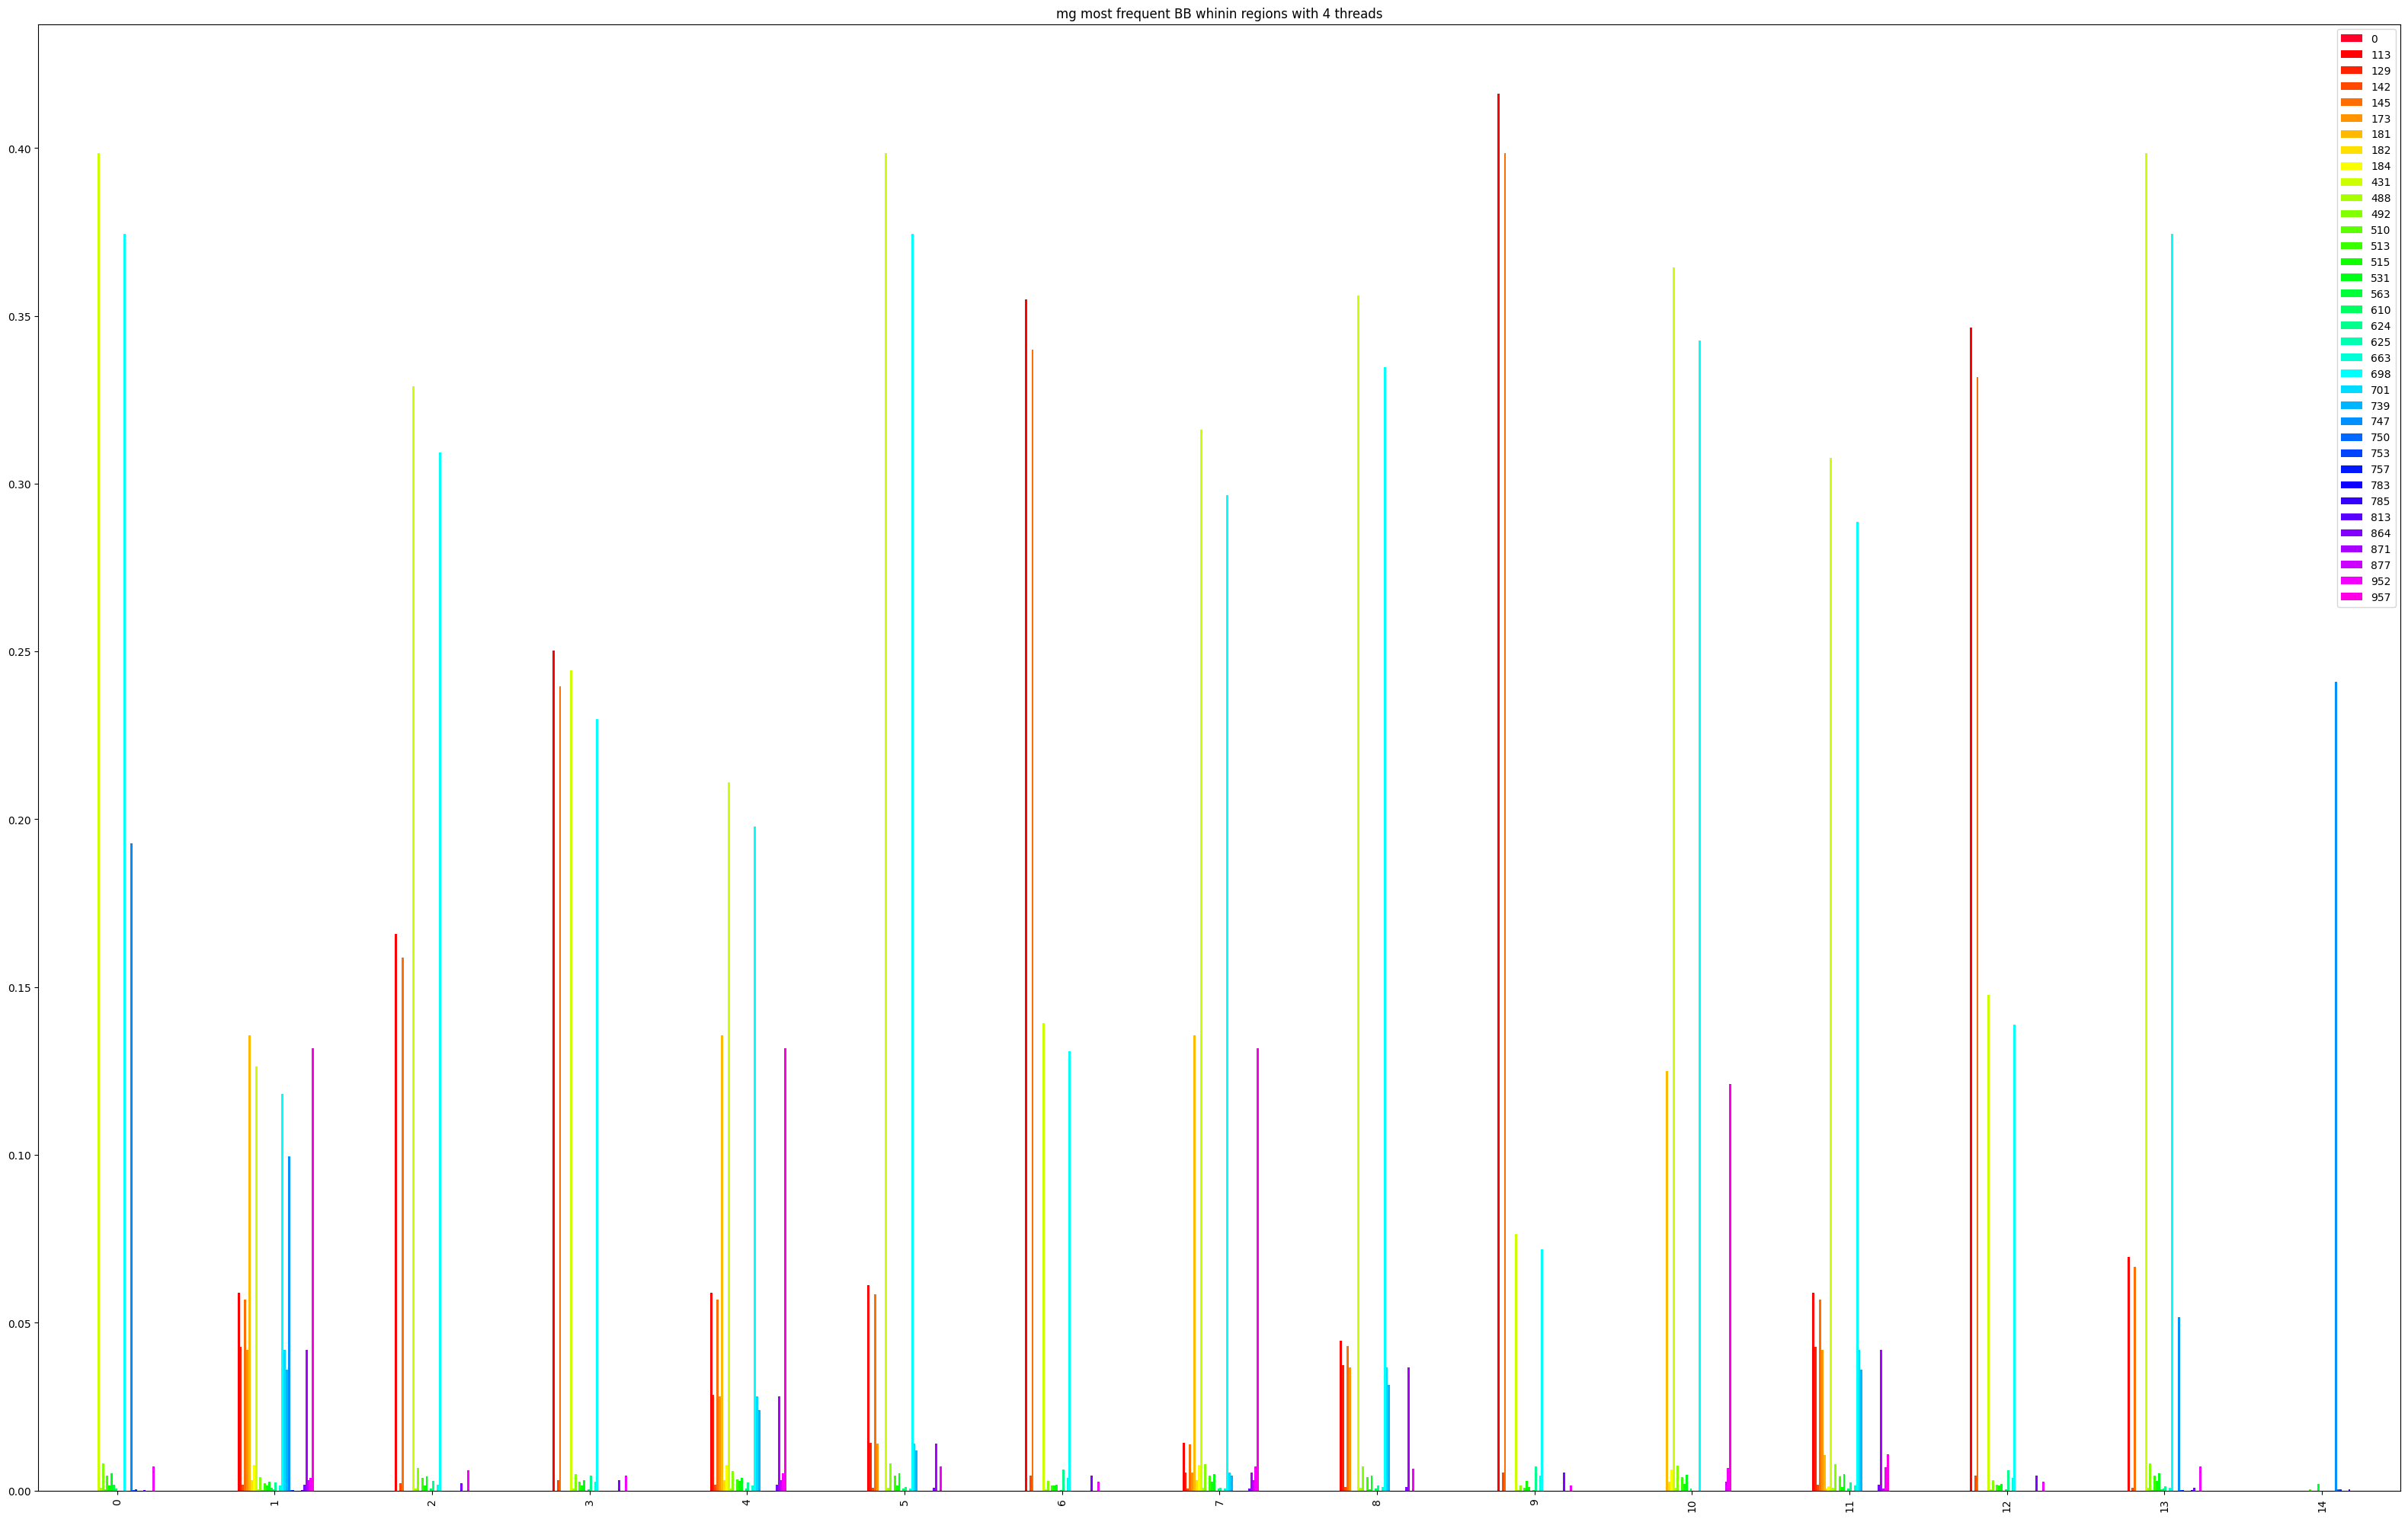

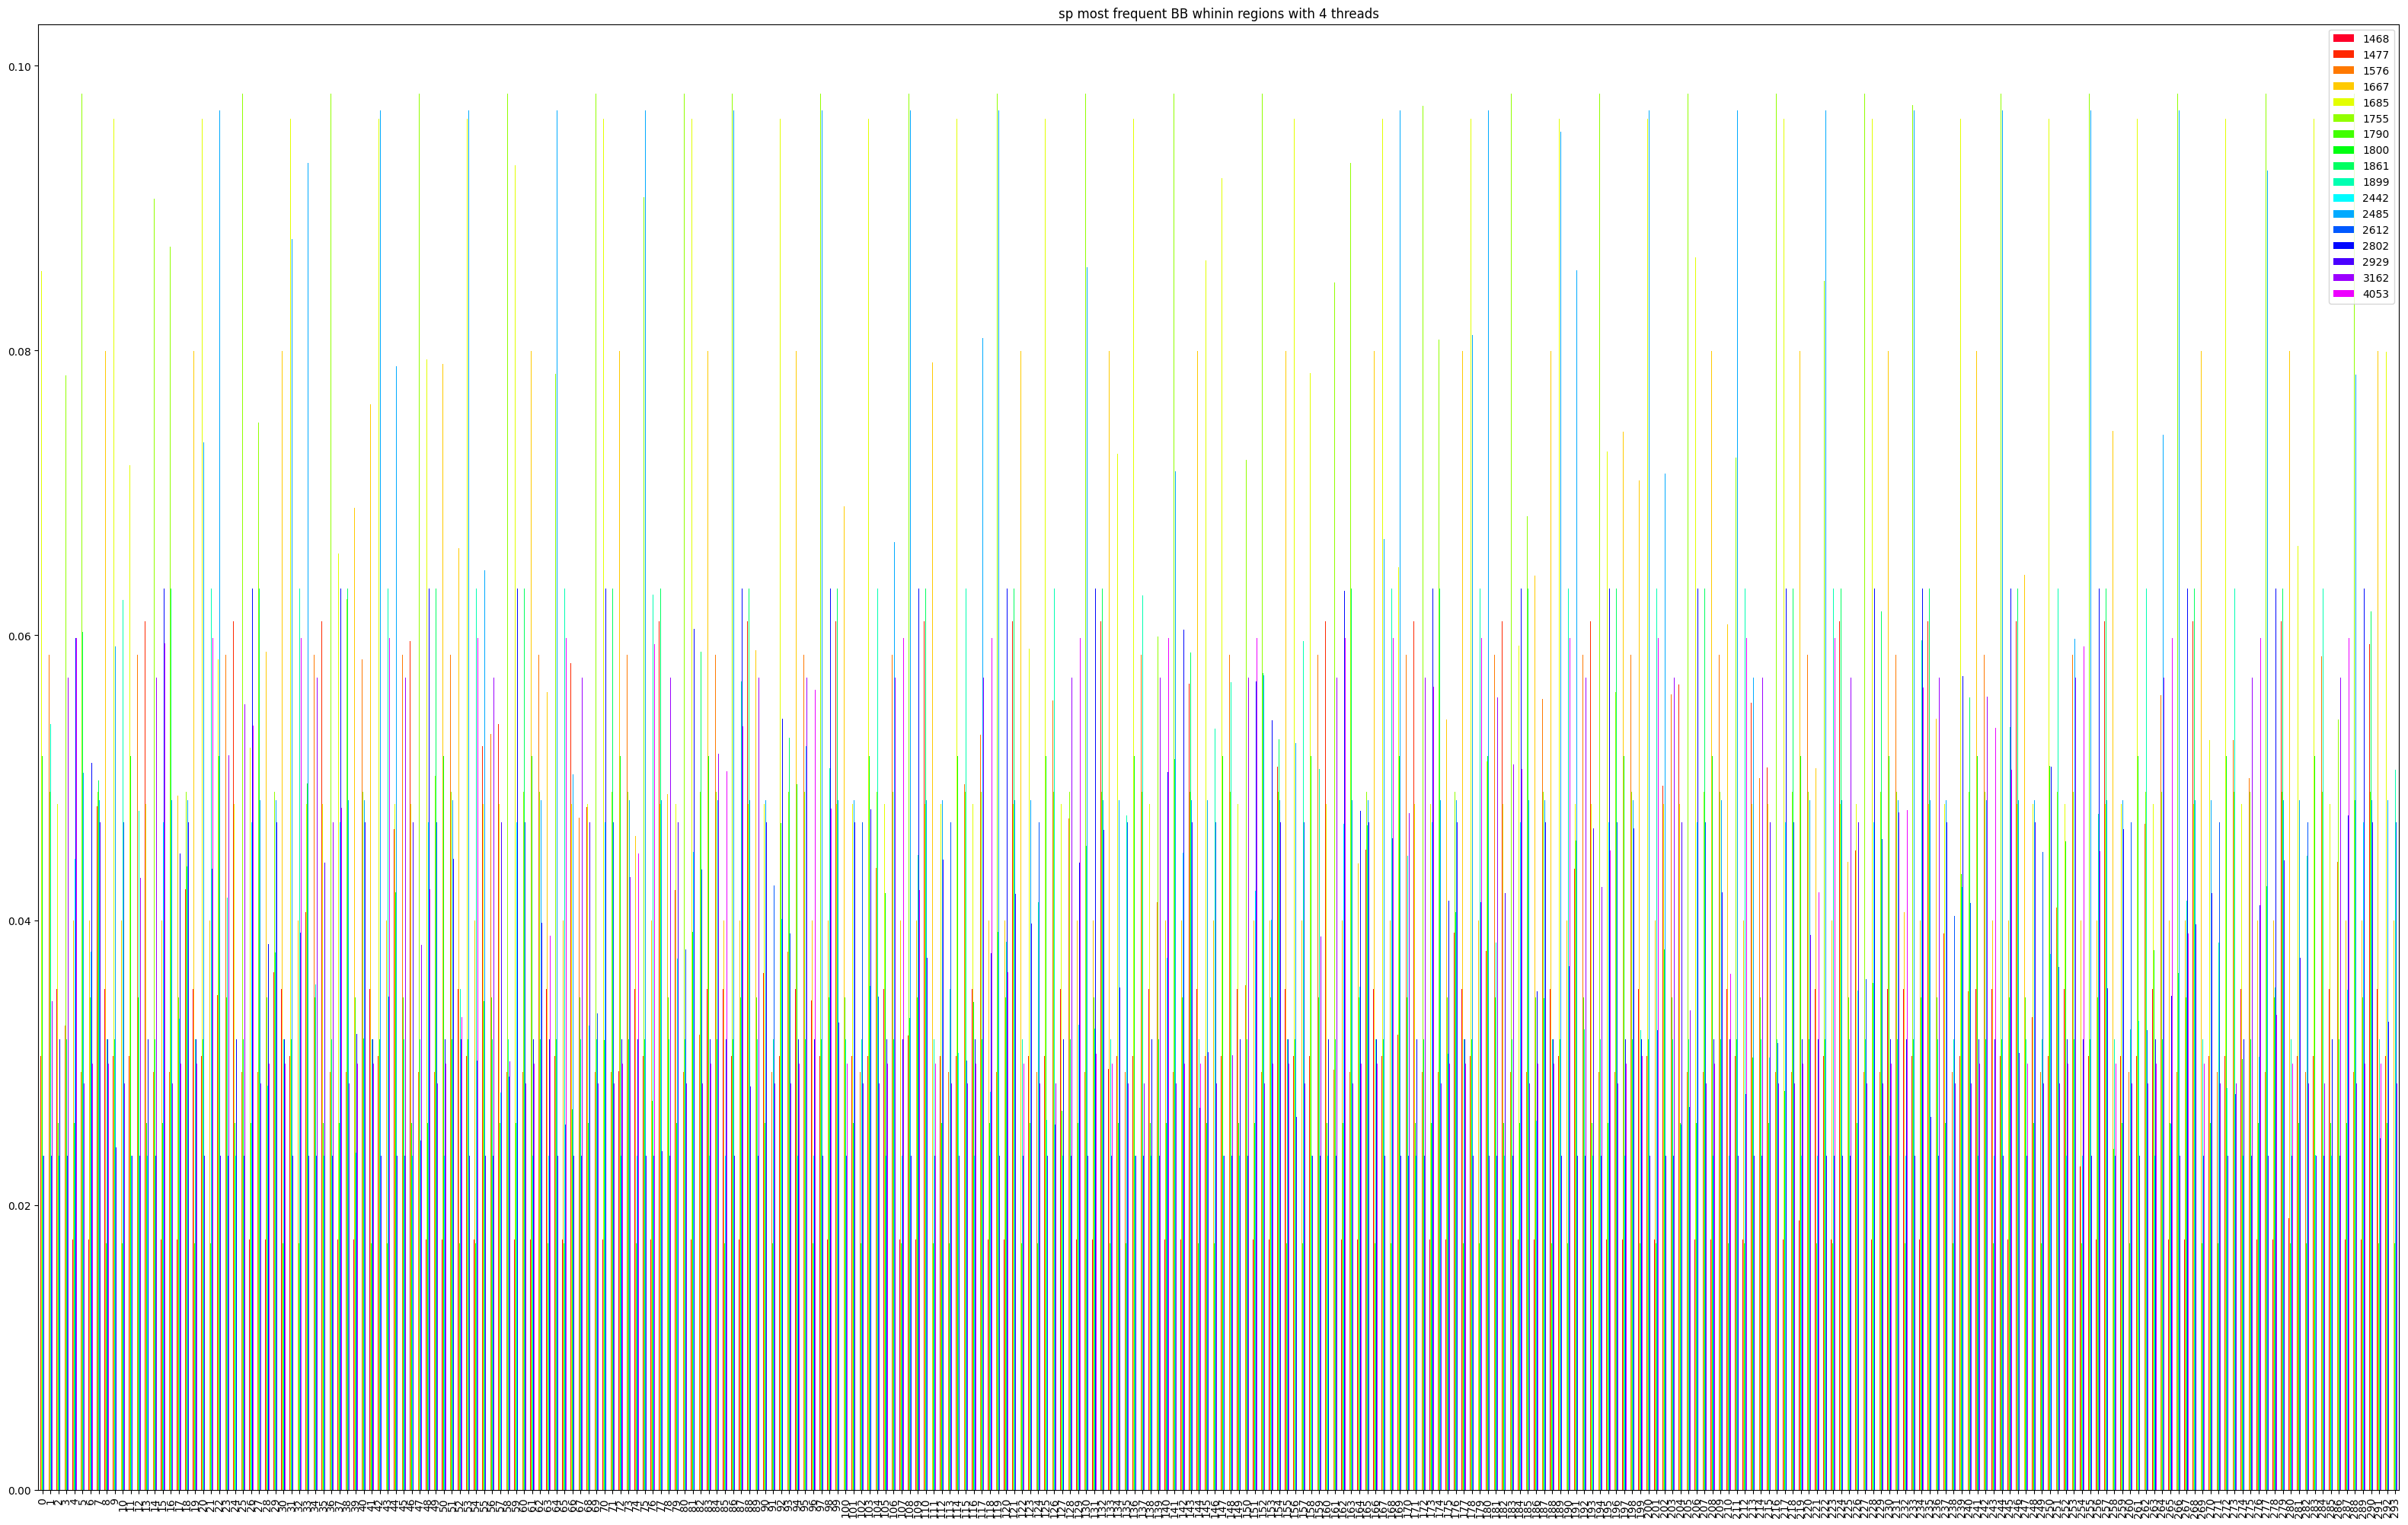

In [43]:
for bench in benchmarks:
    show_highest_ten_bbf("arm","4", bench)

### all highest frequent bbf for arm 1 thread

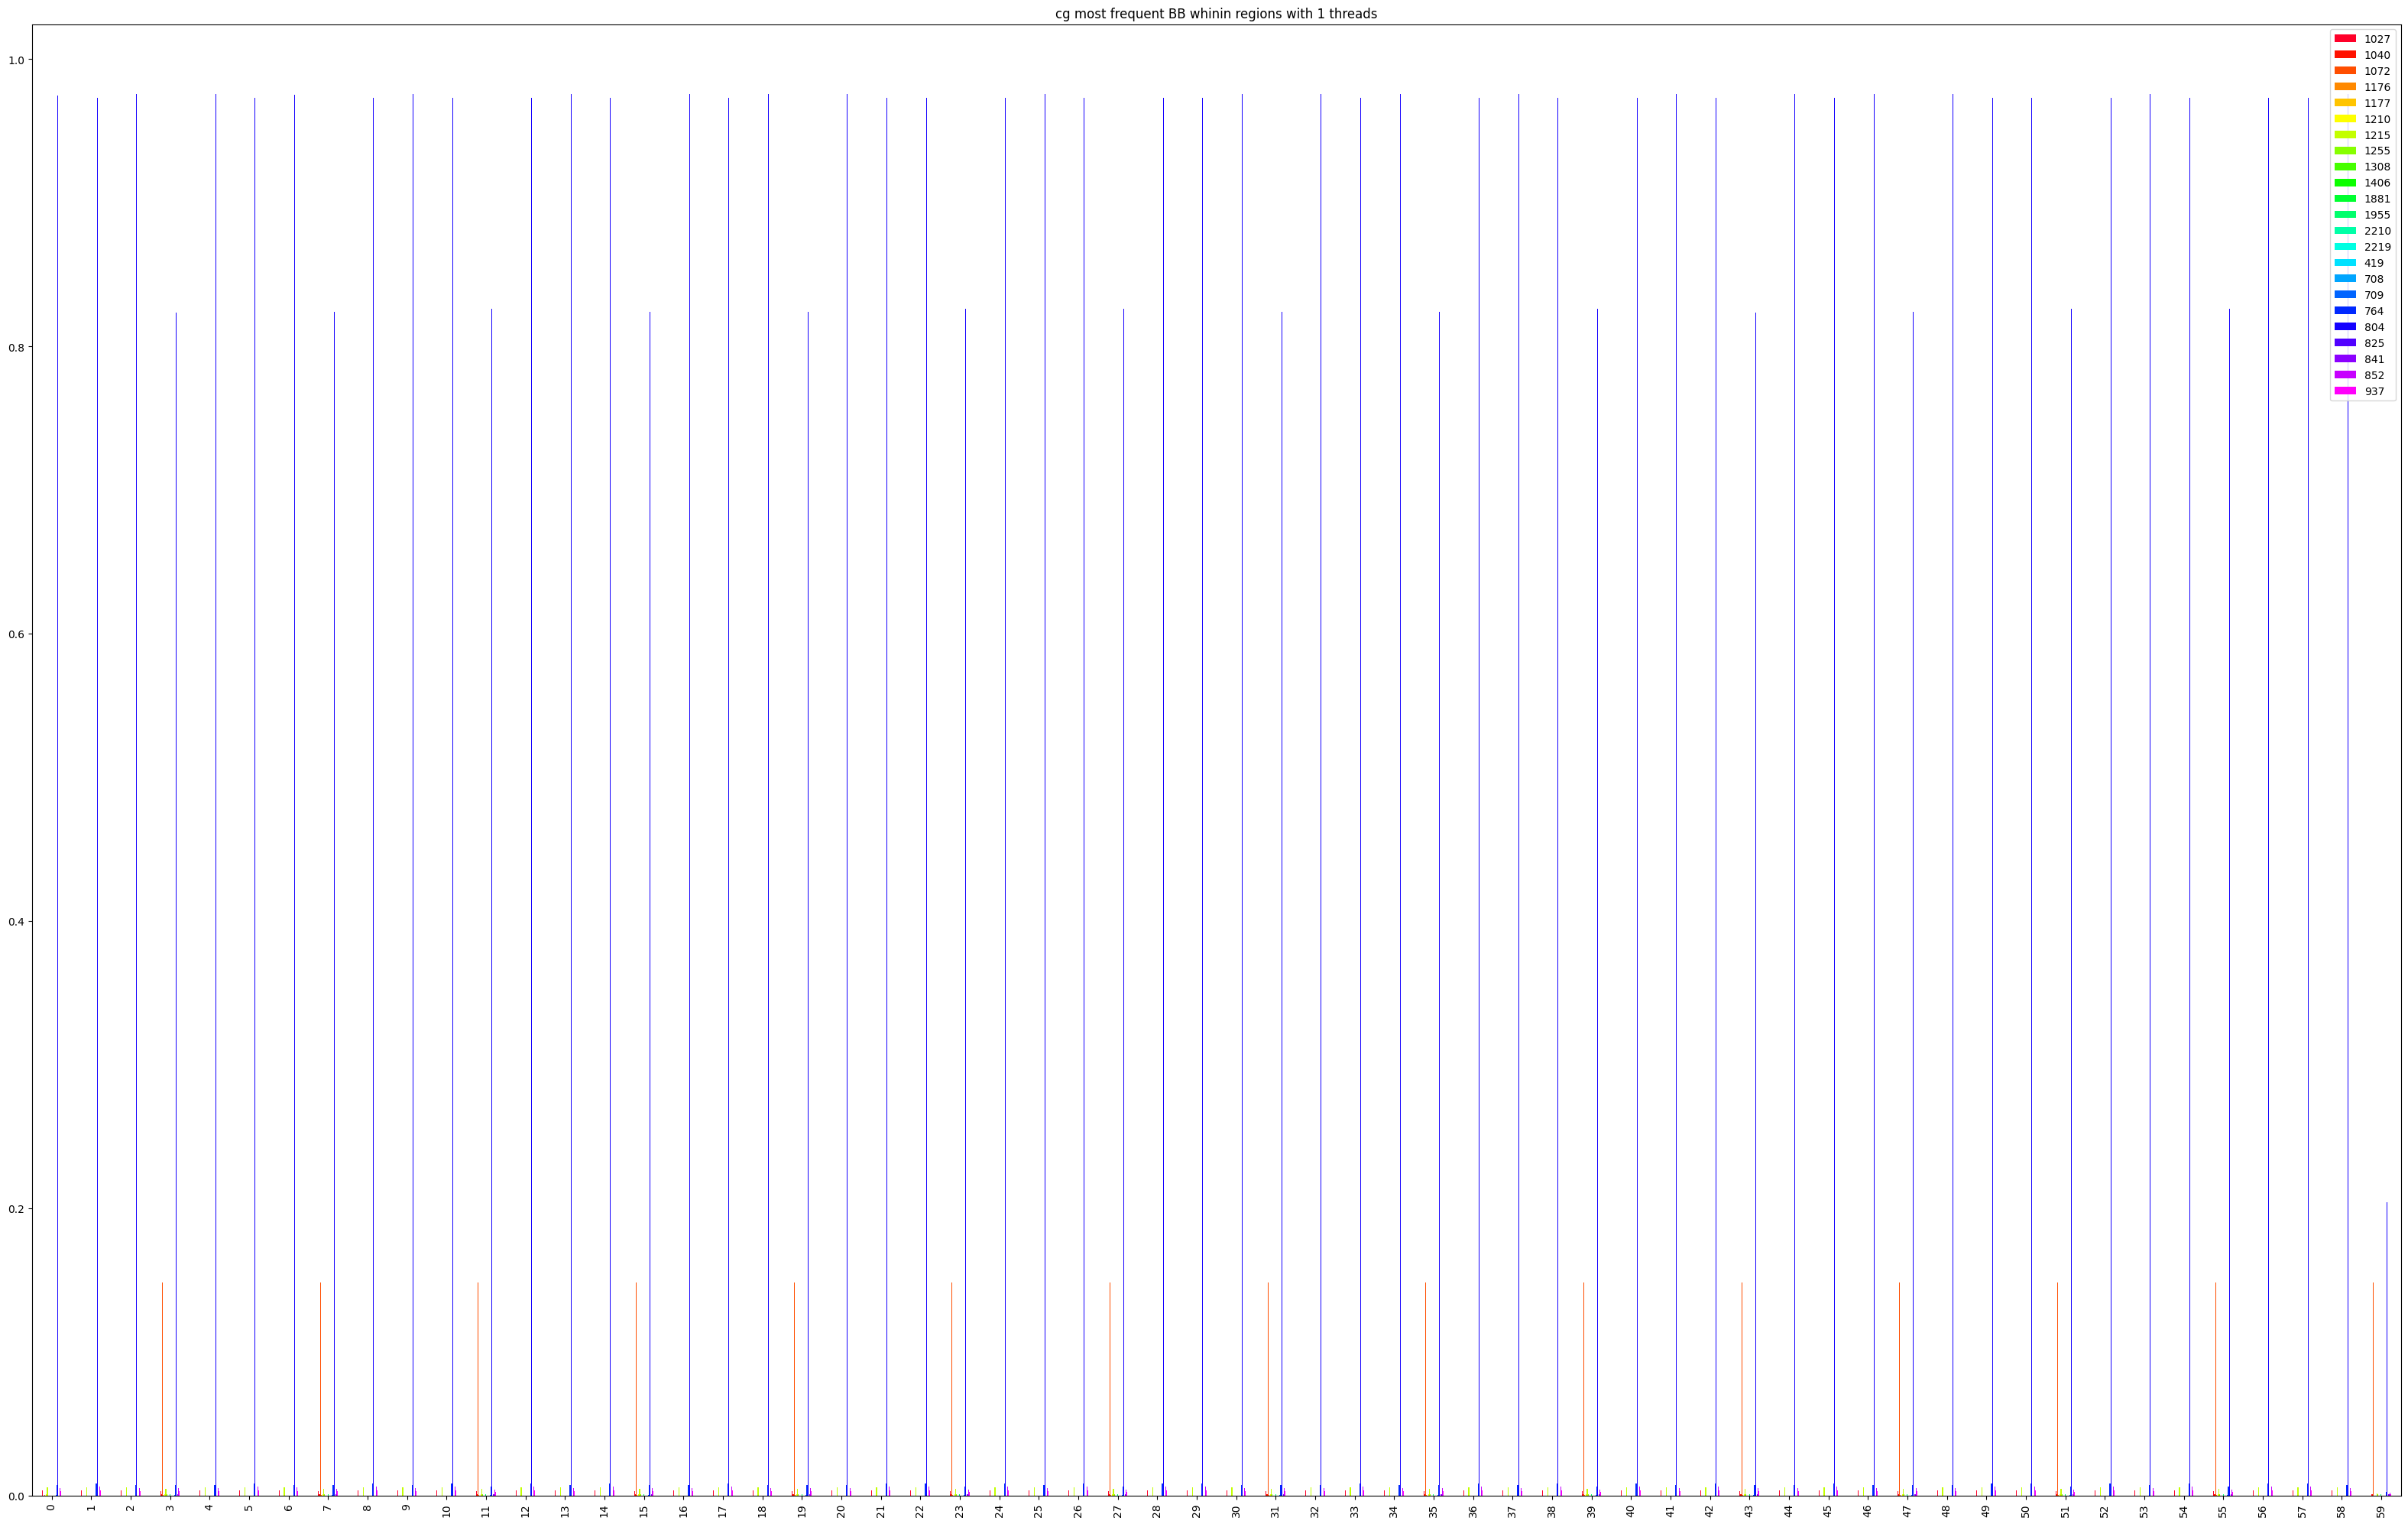

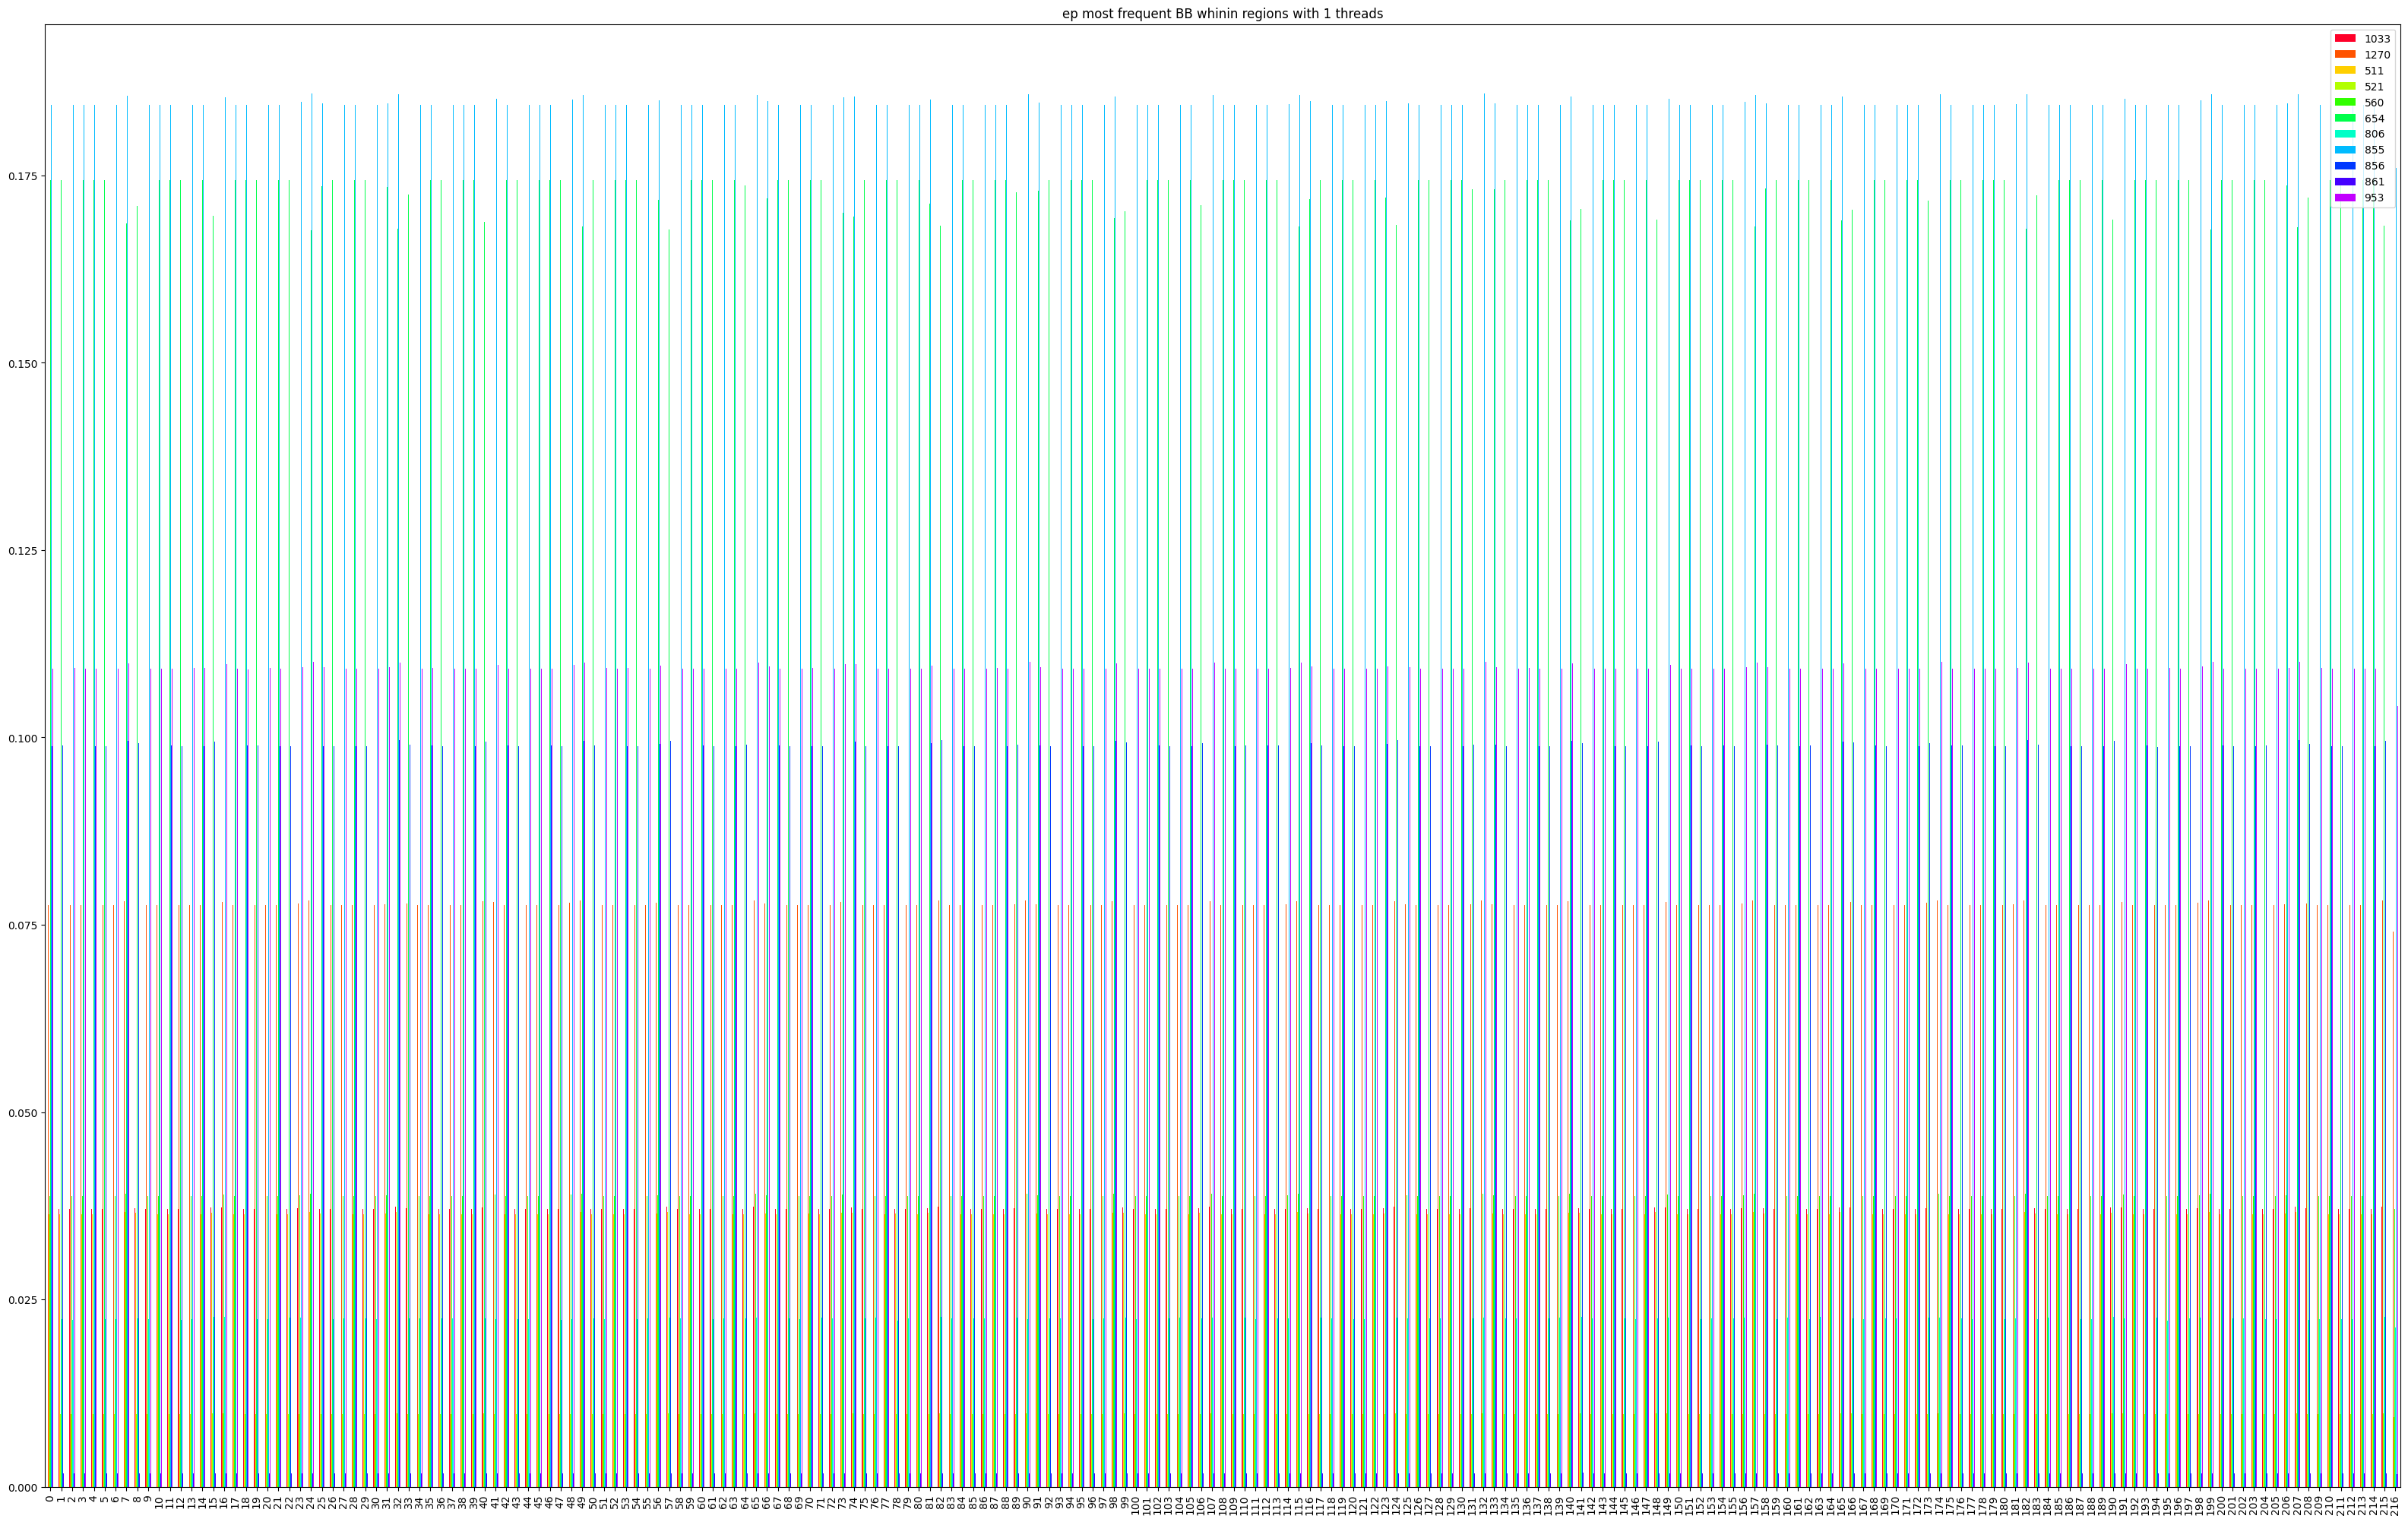

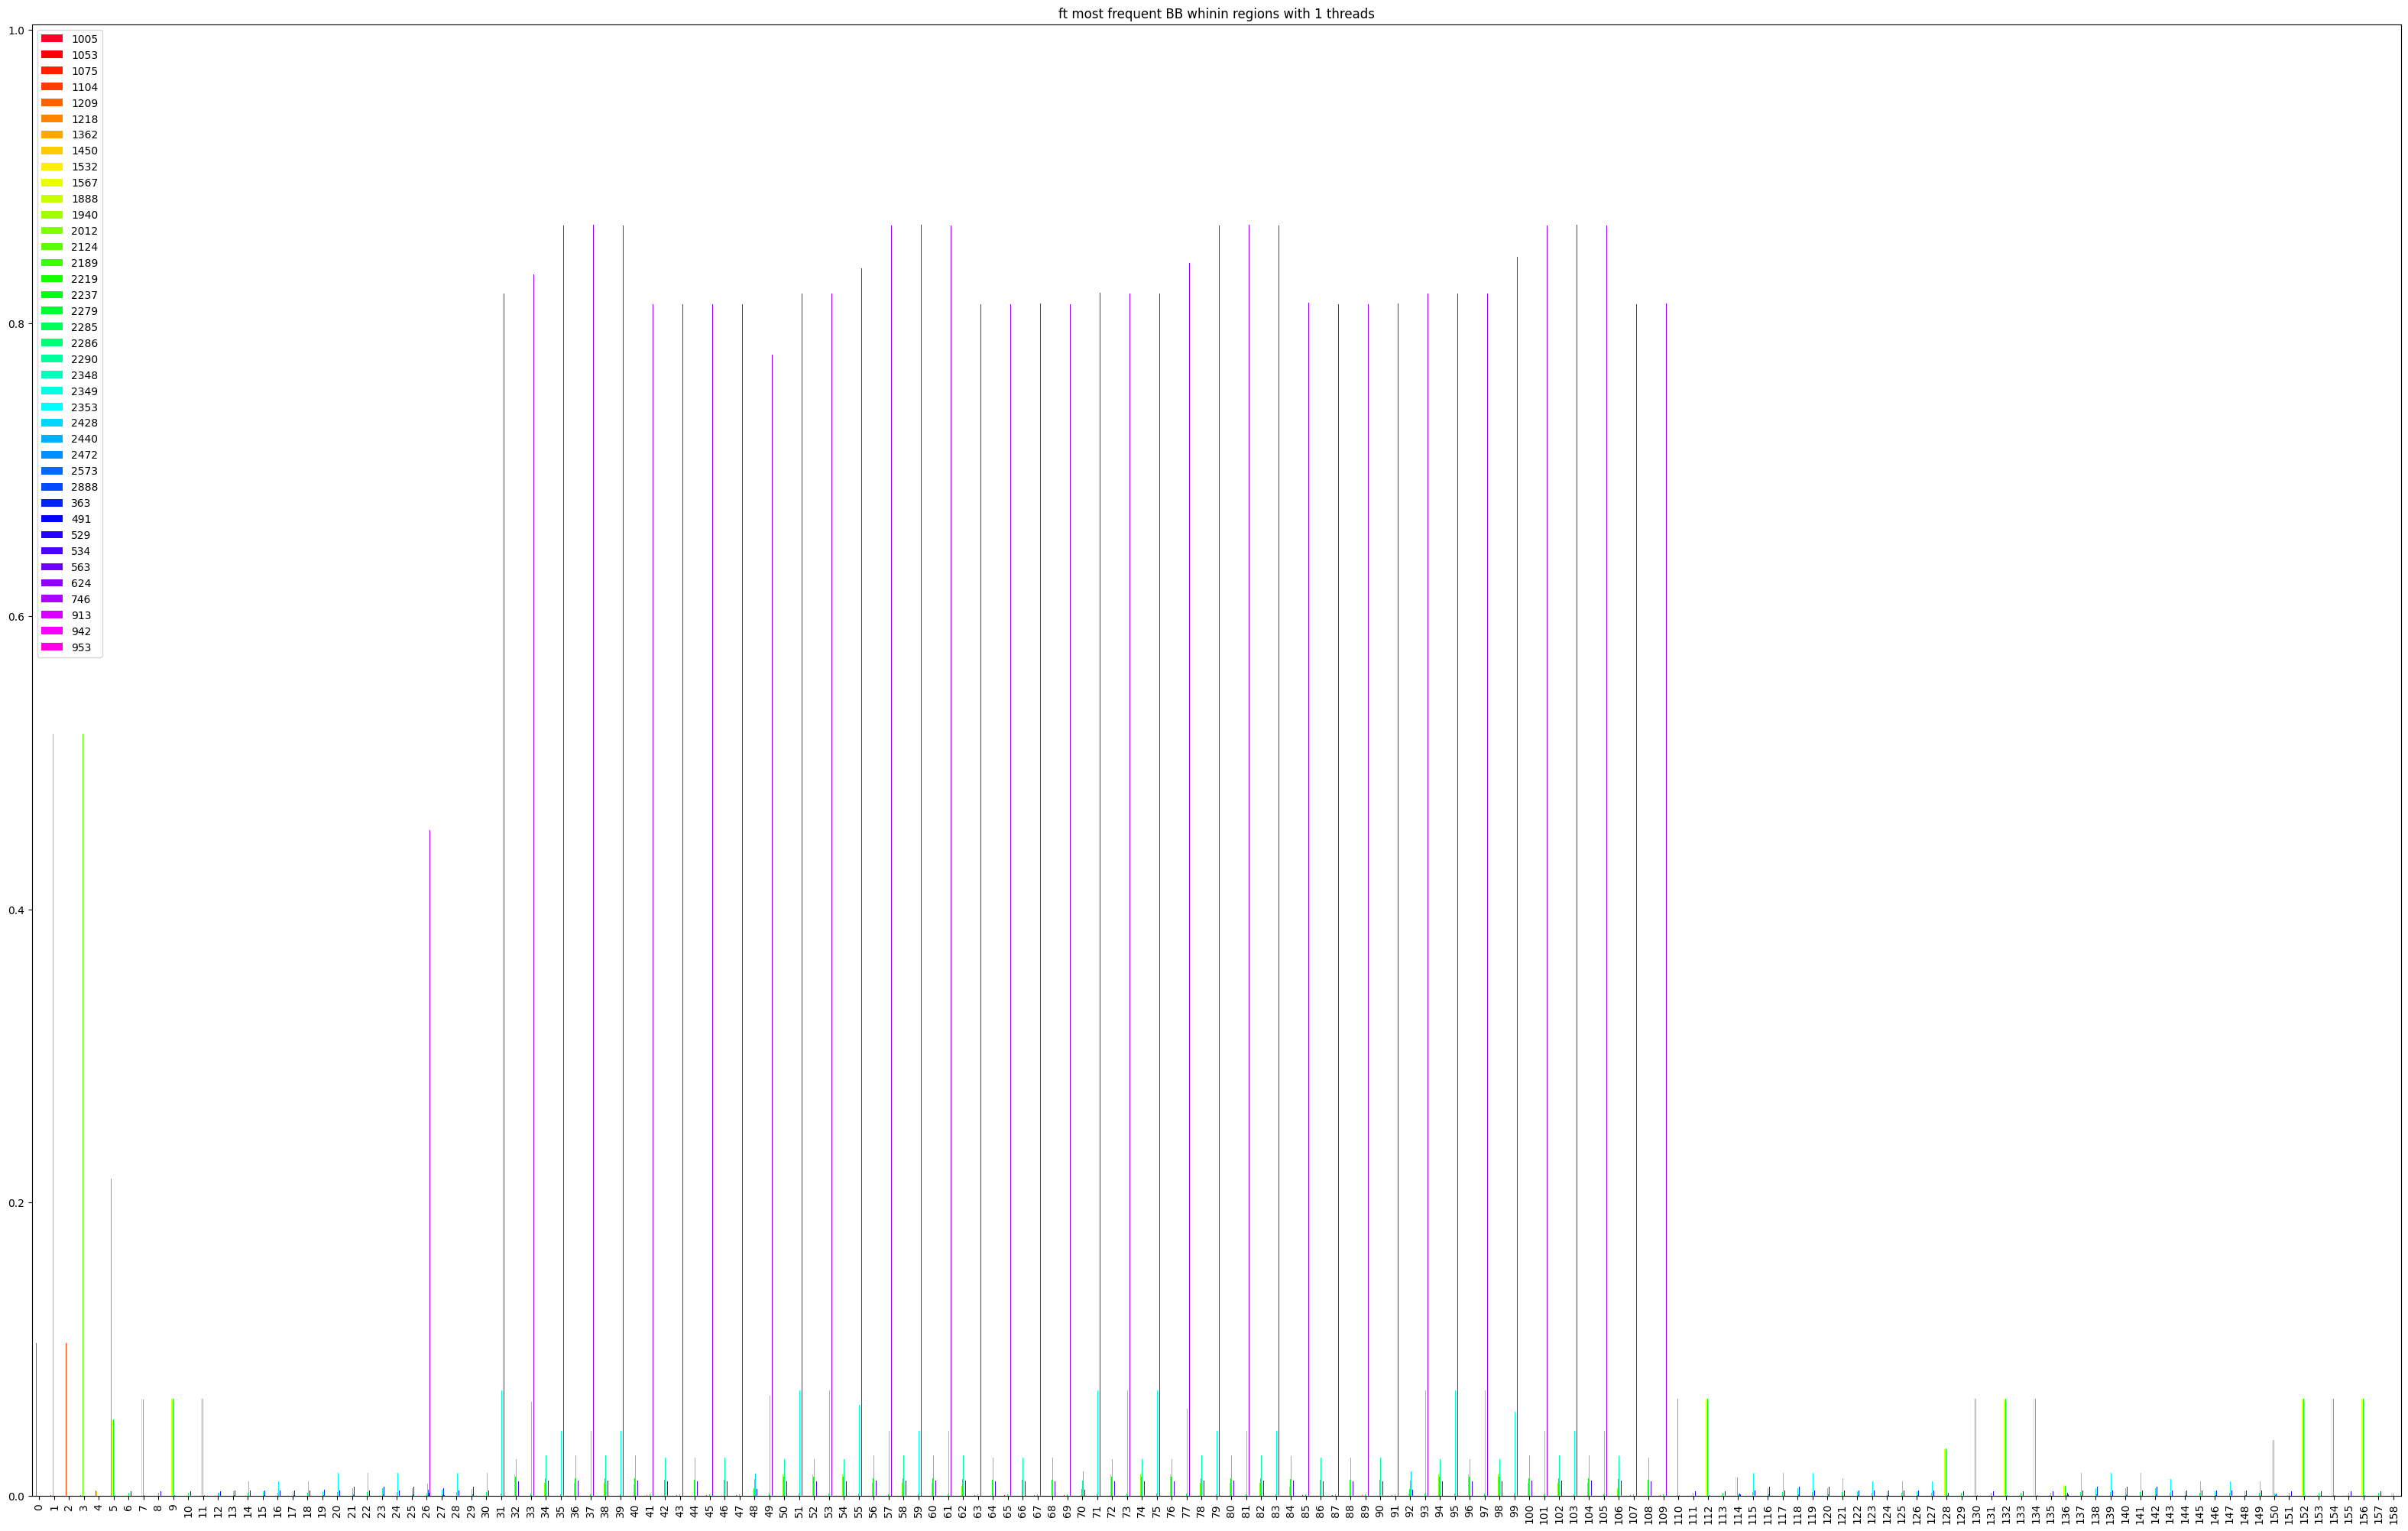

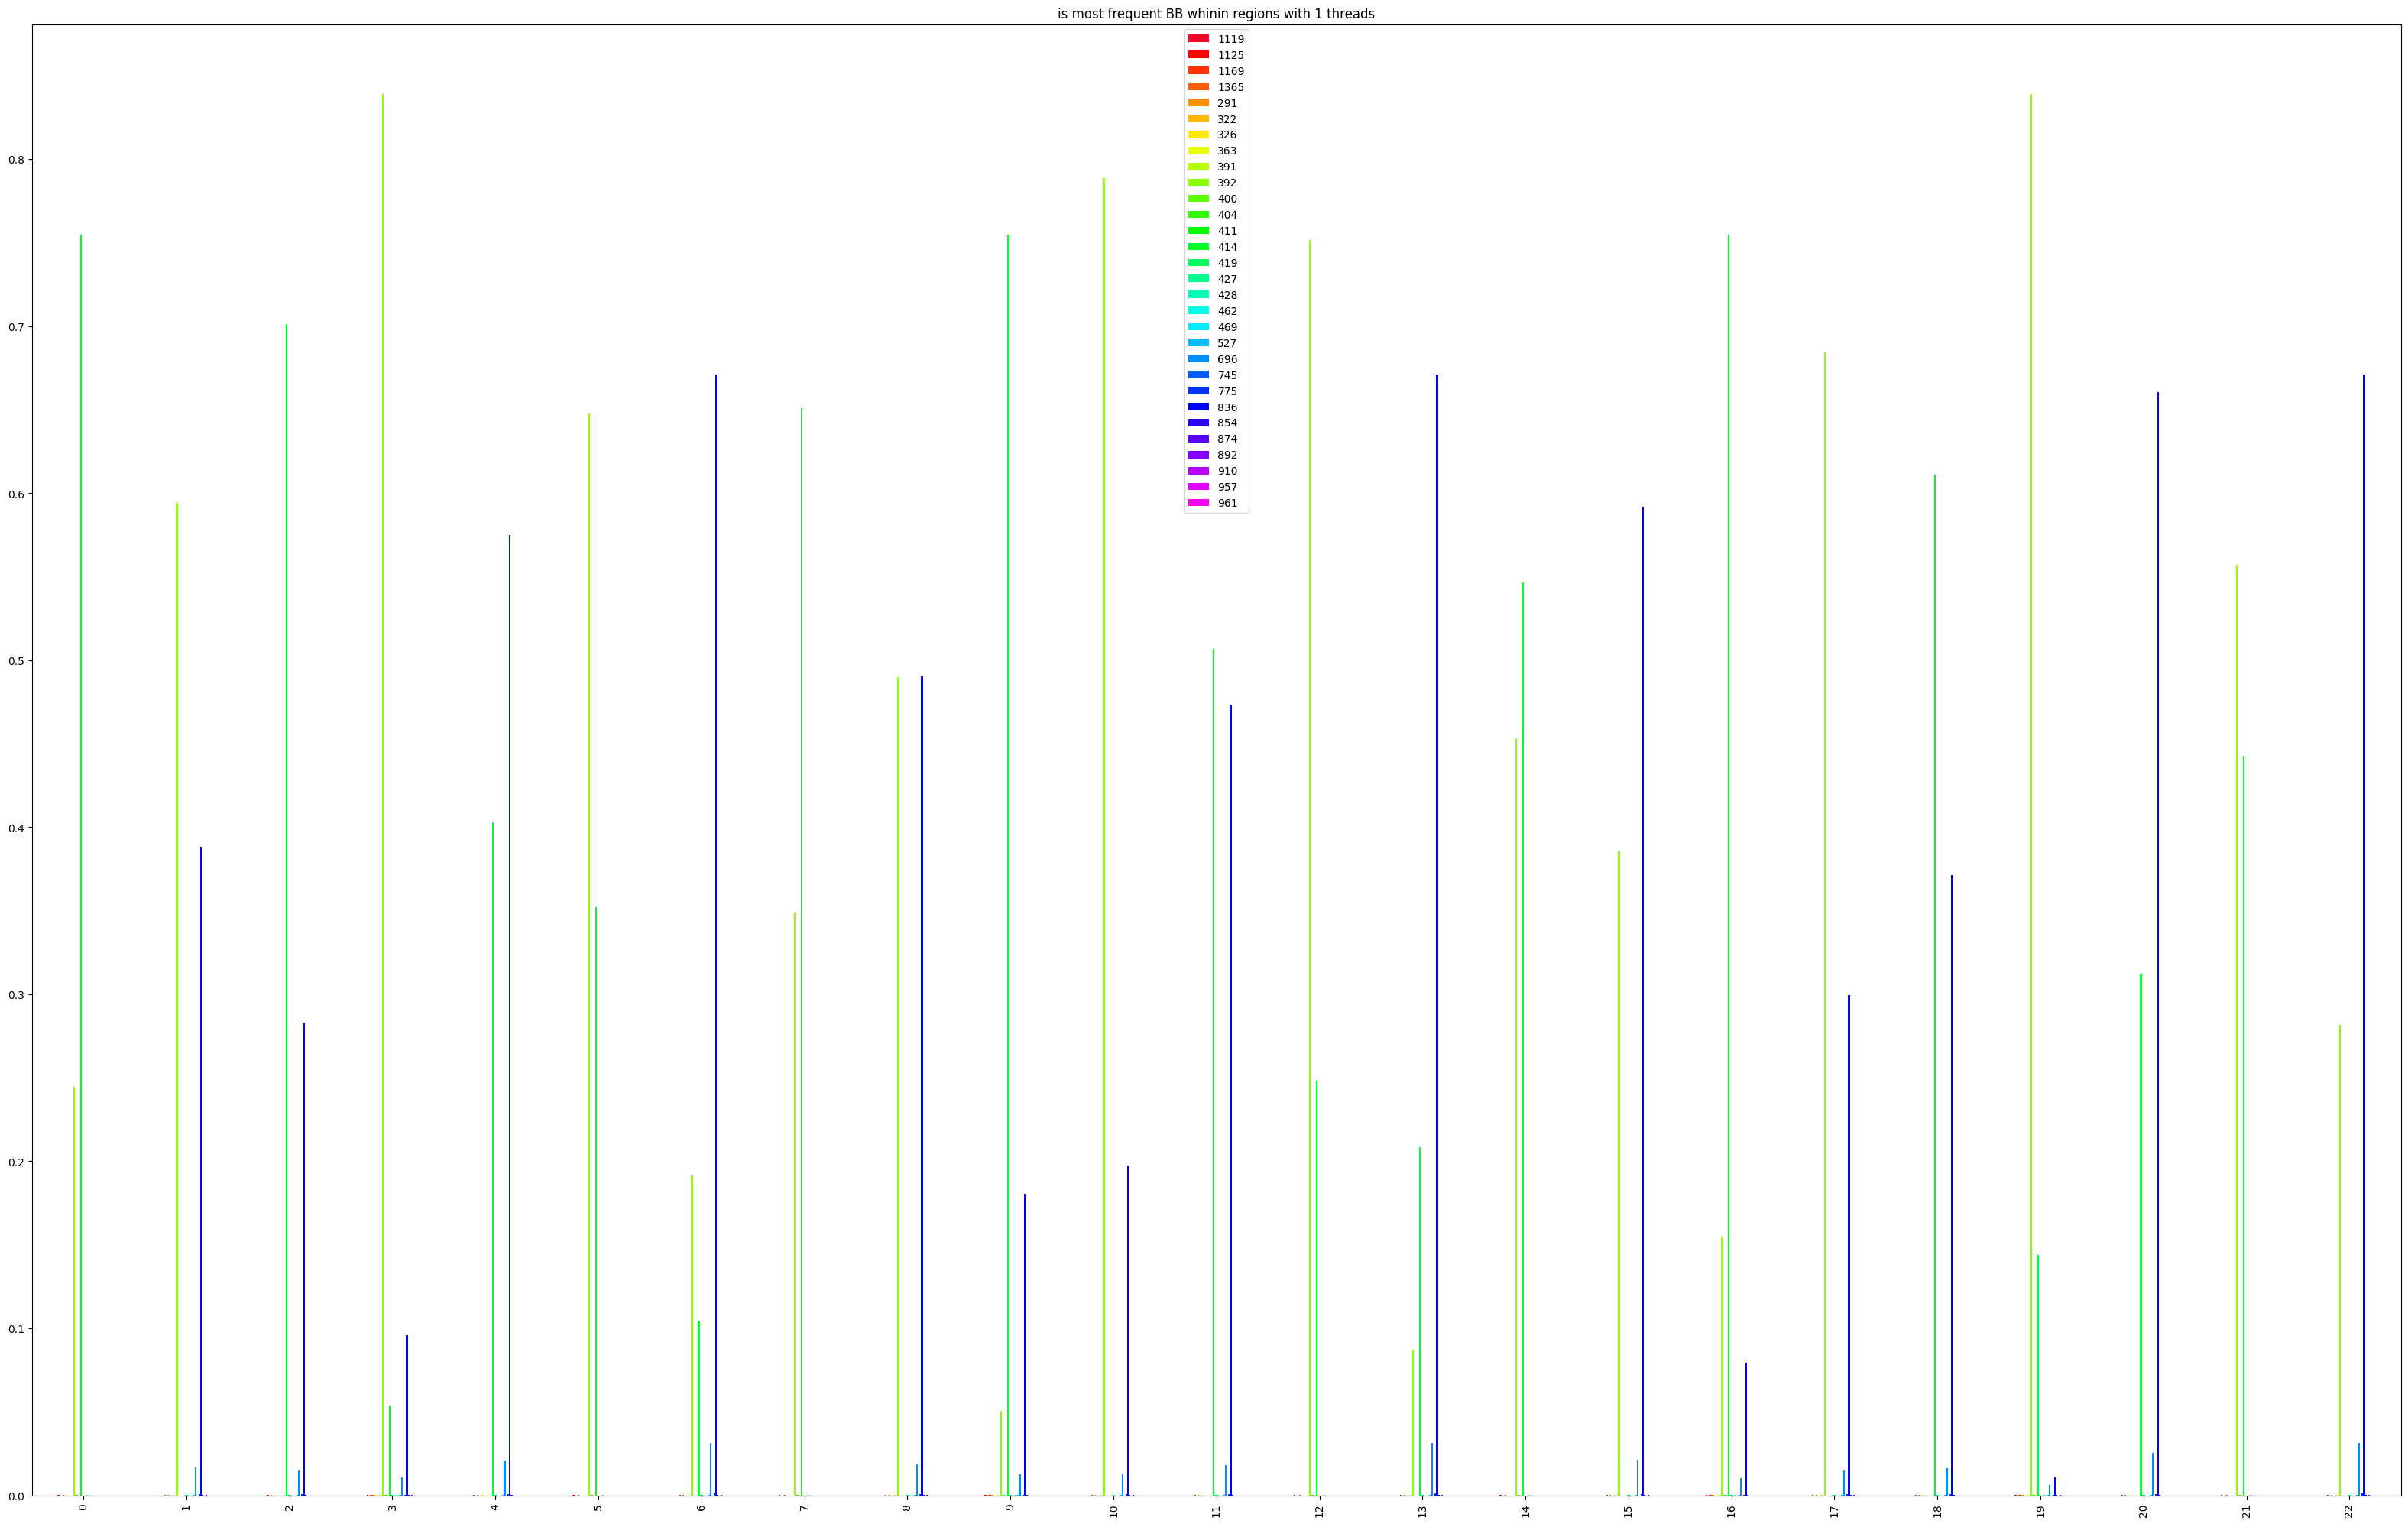

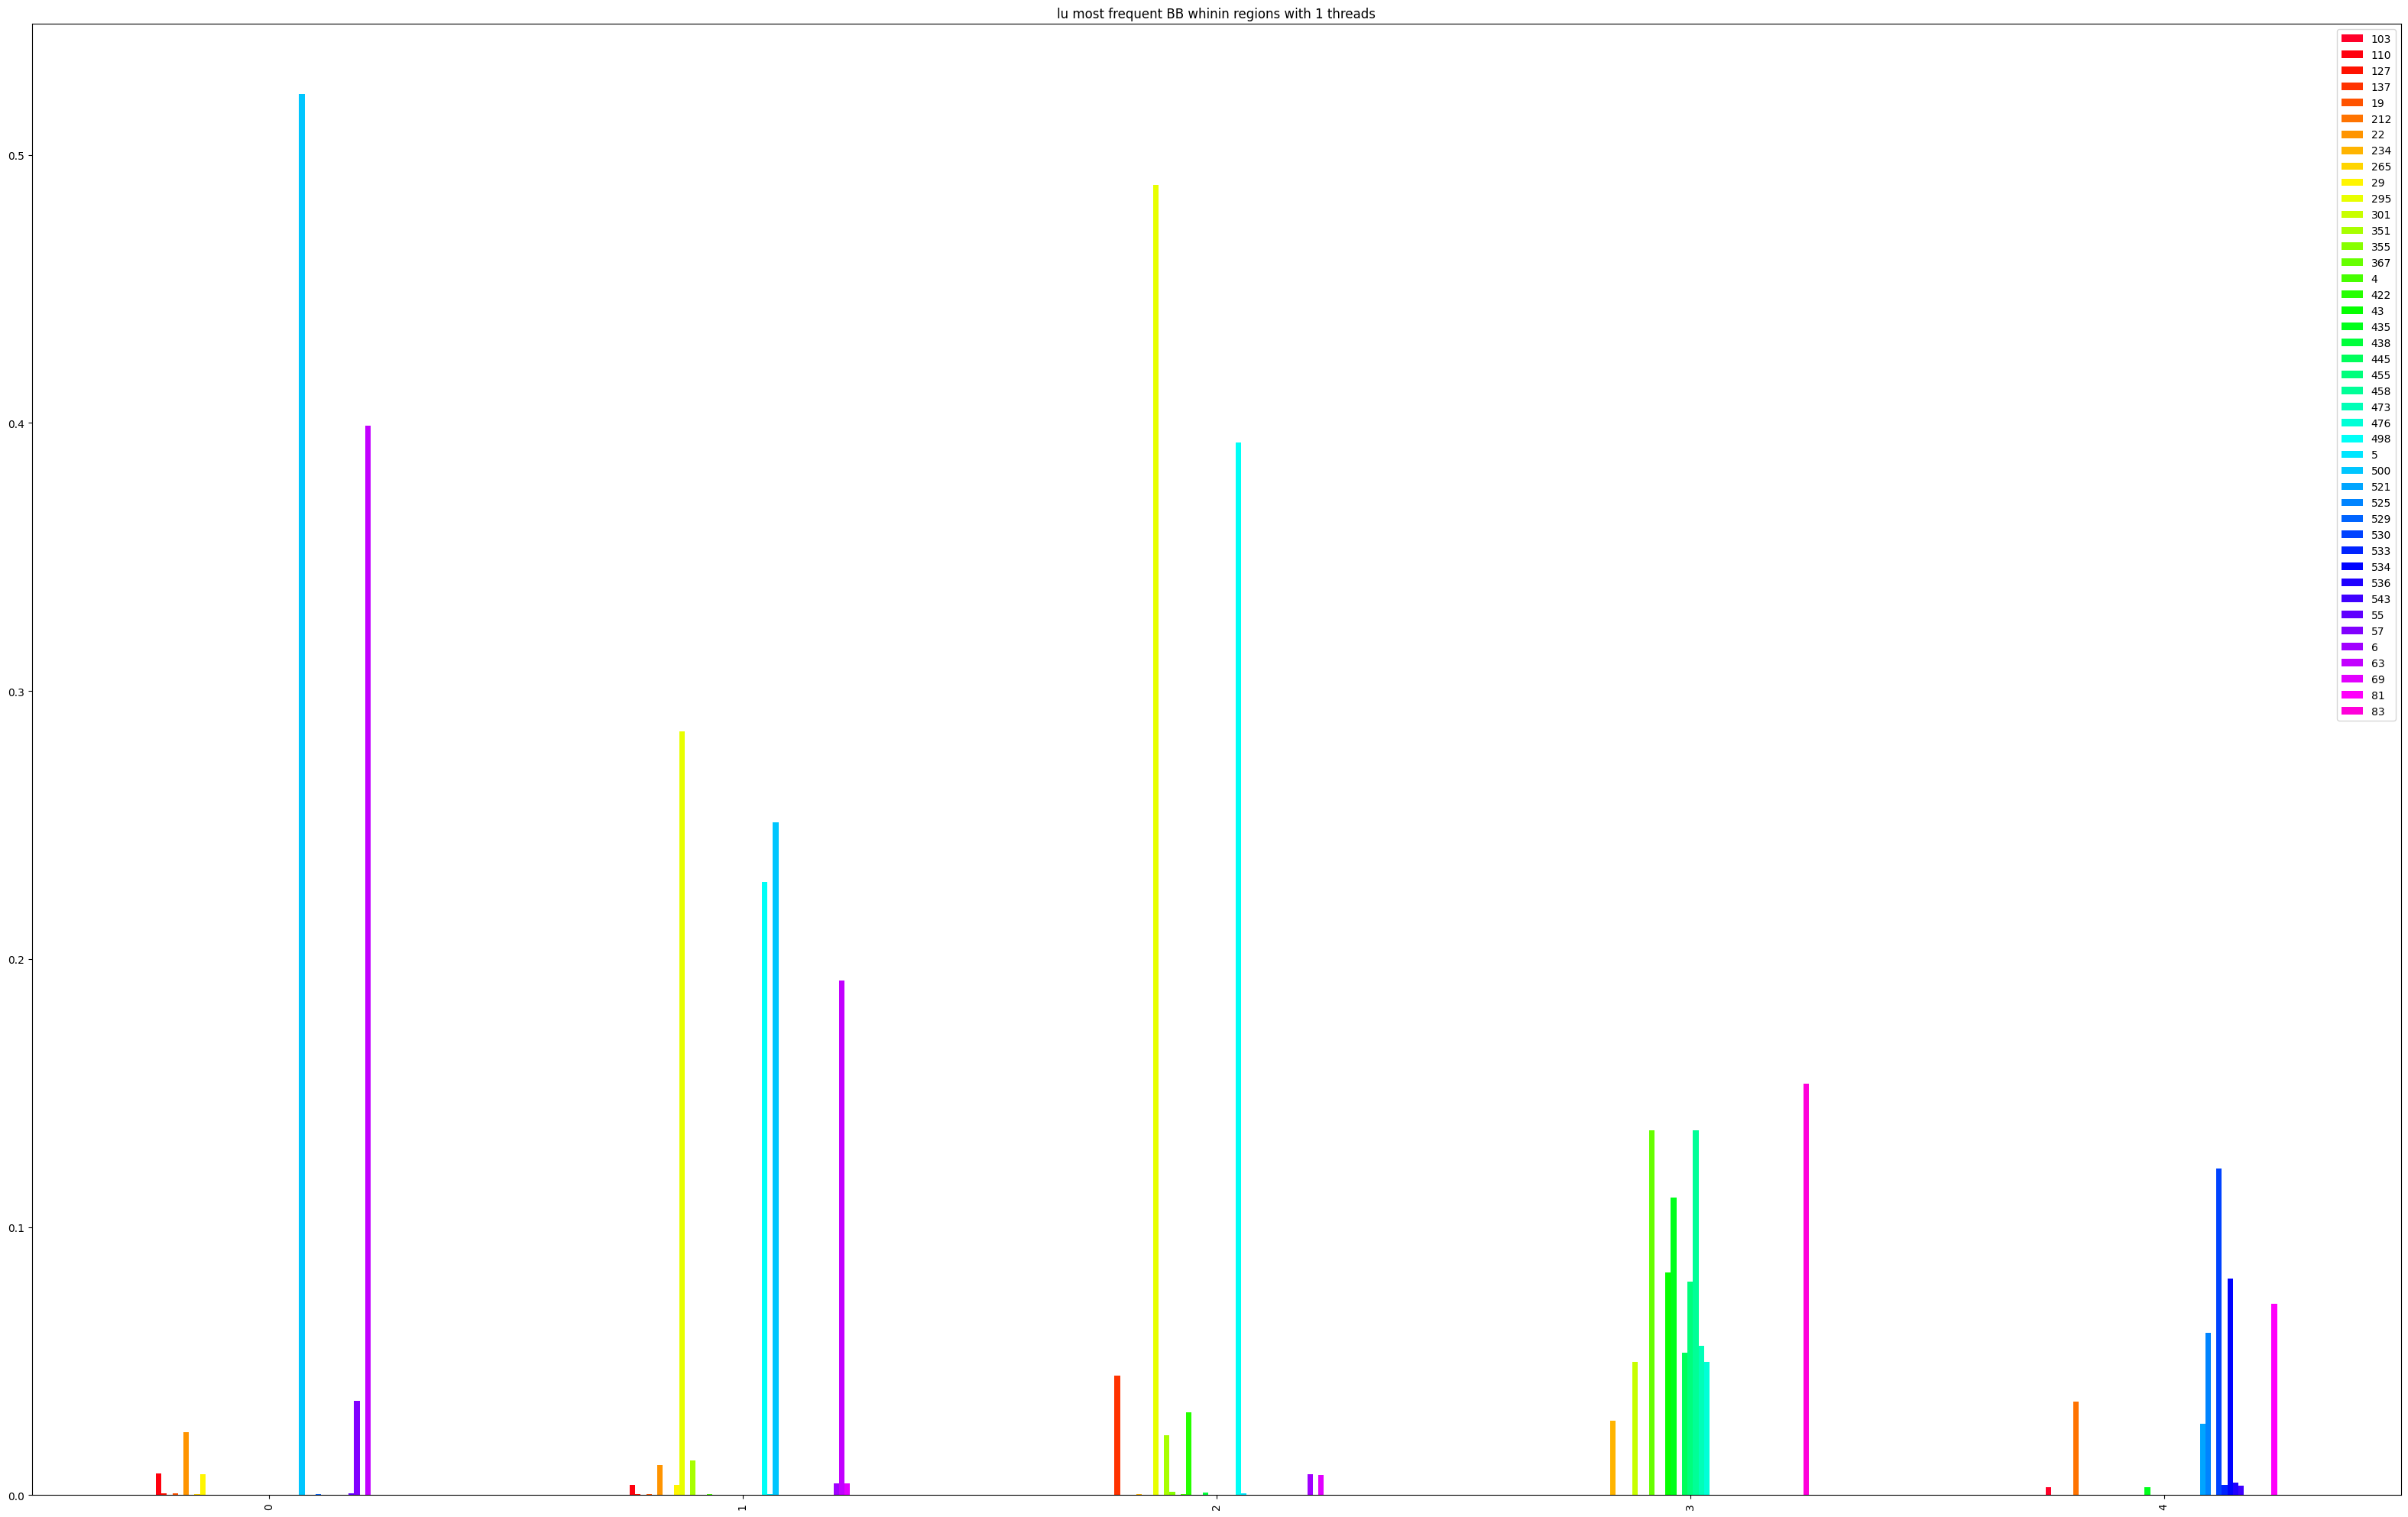

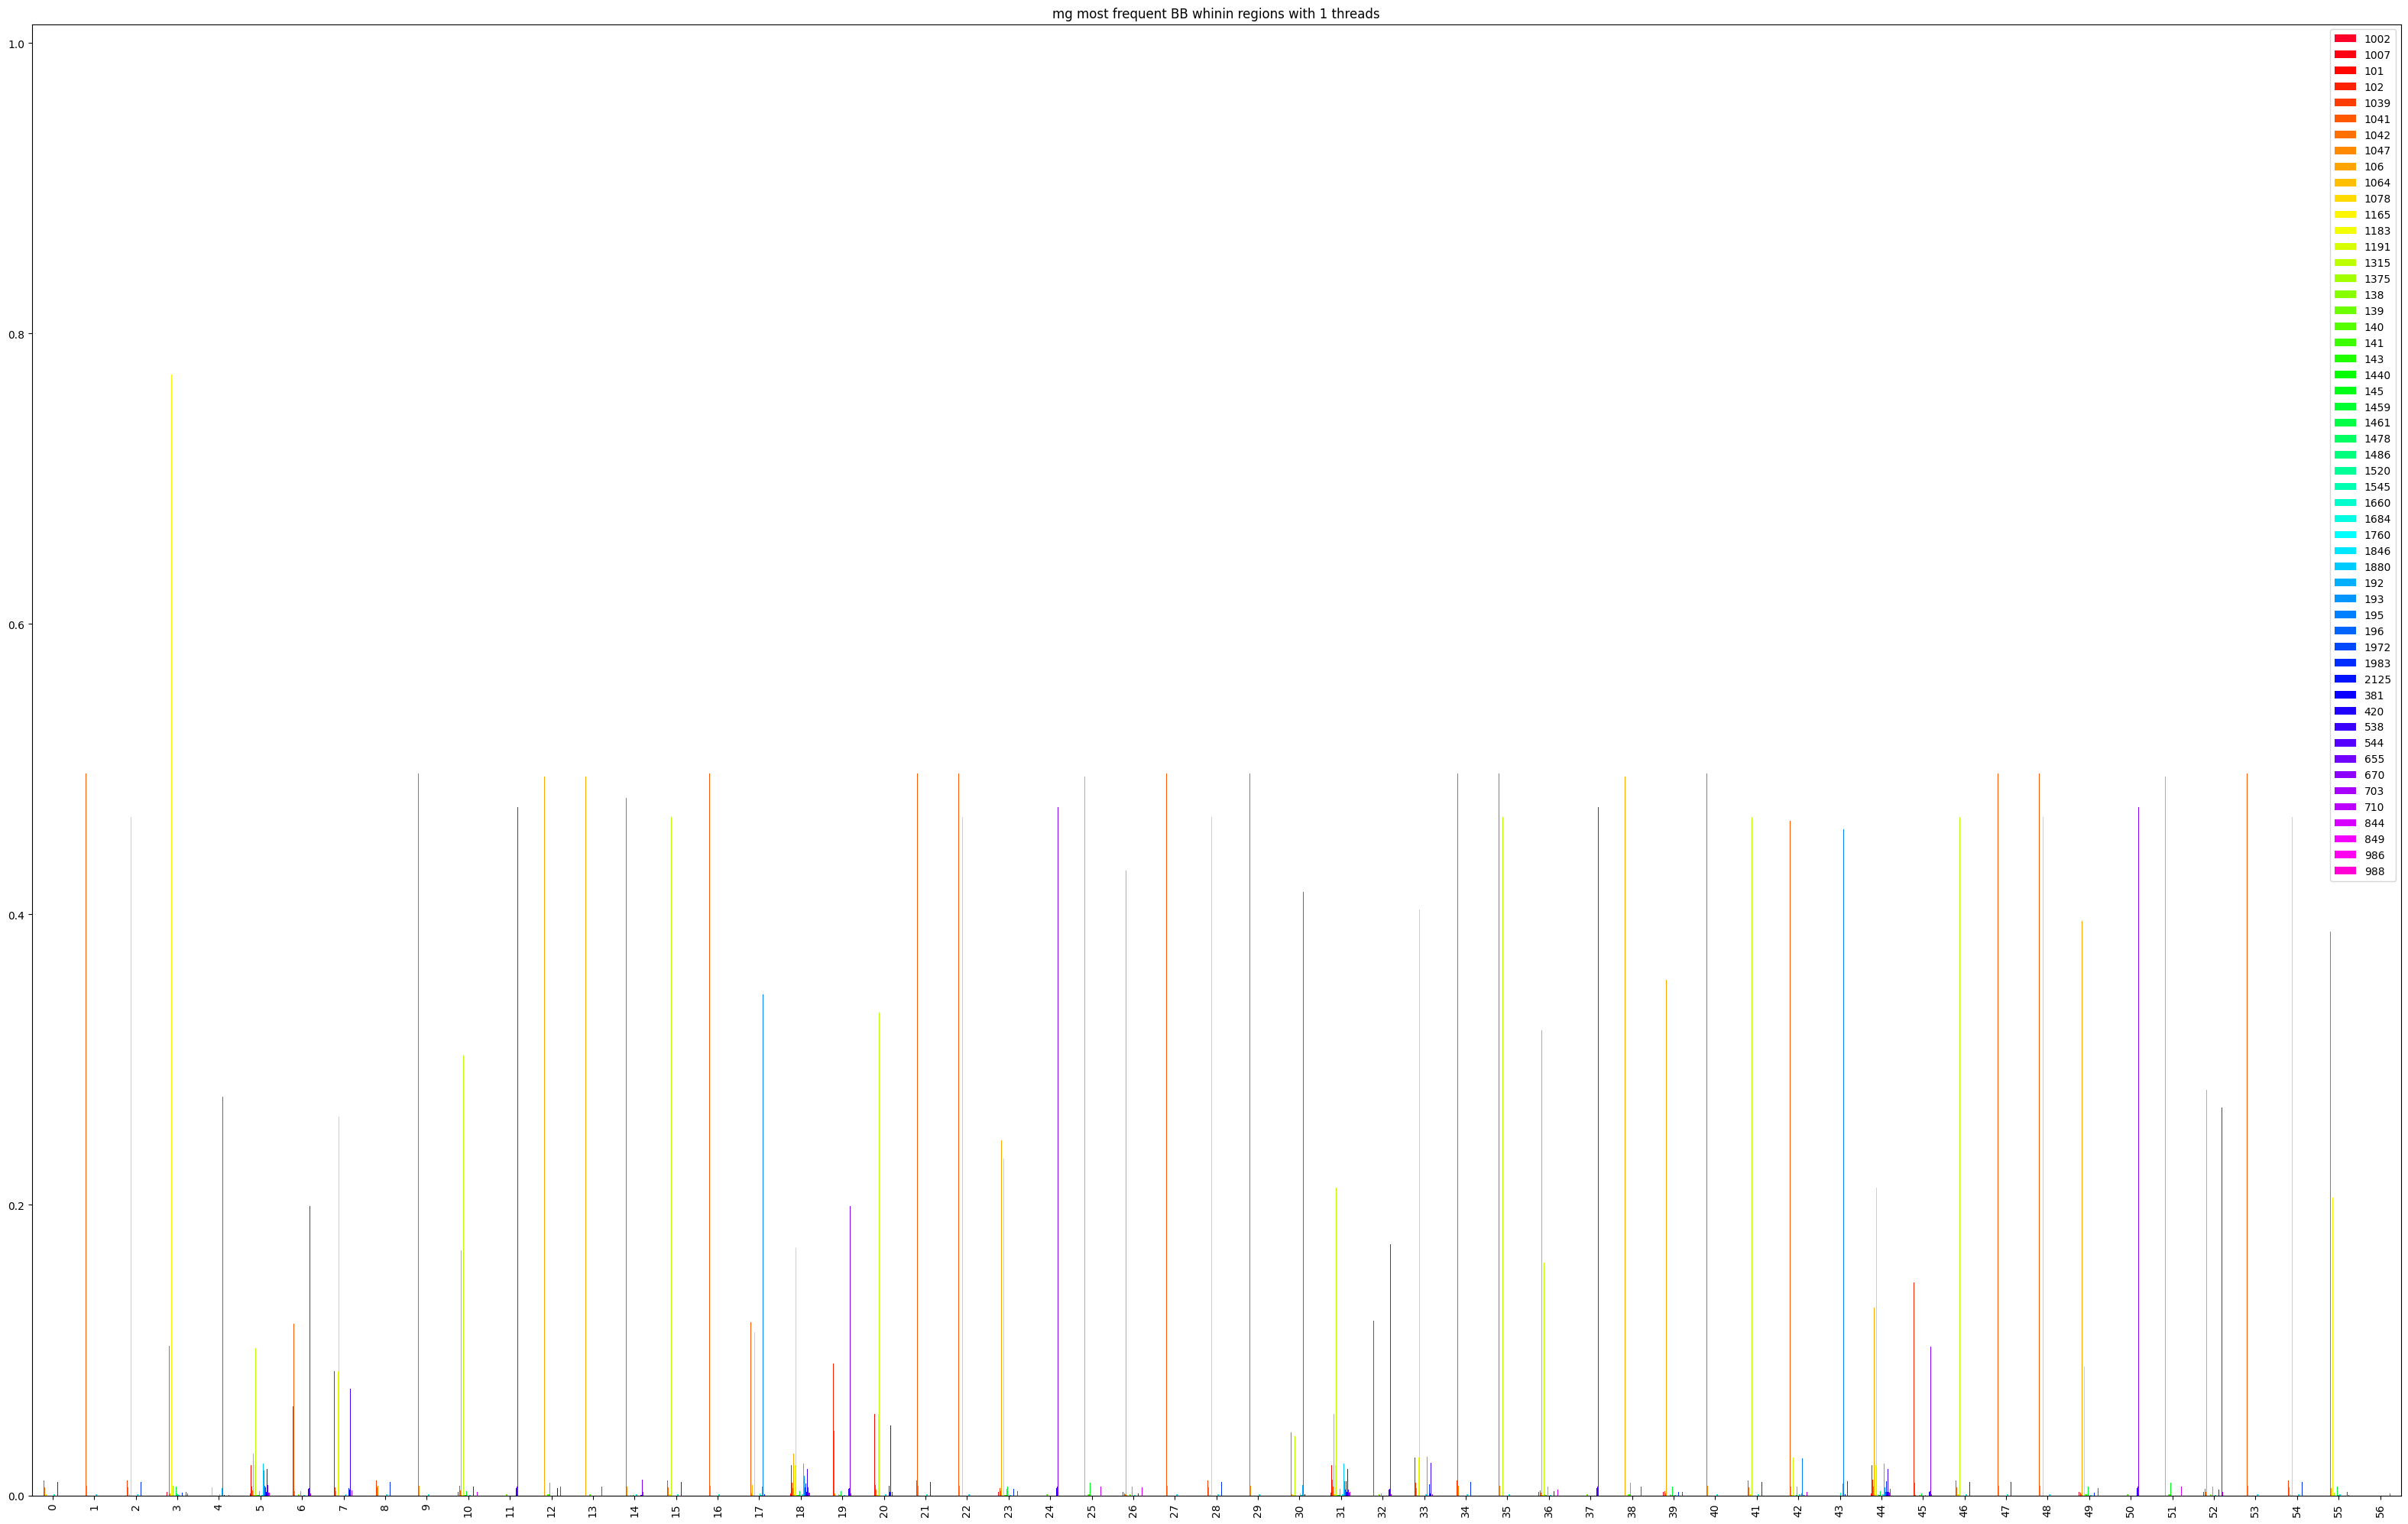

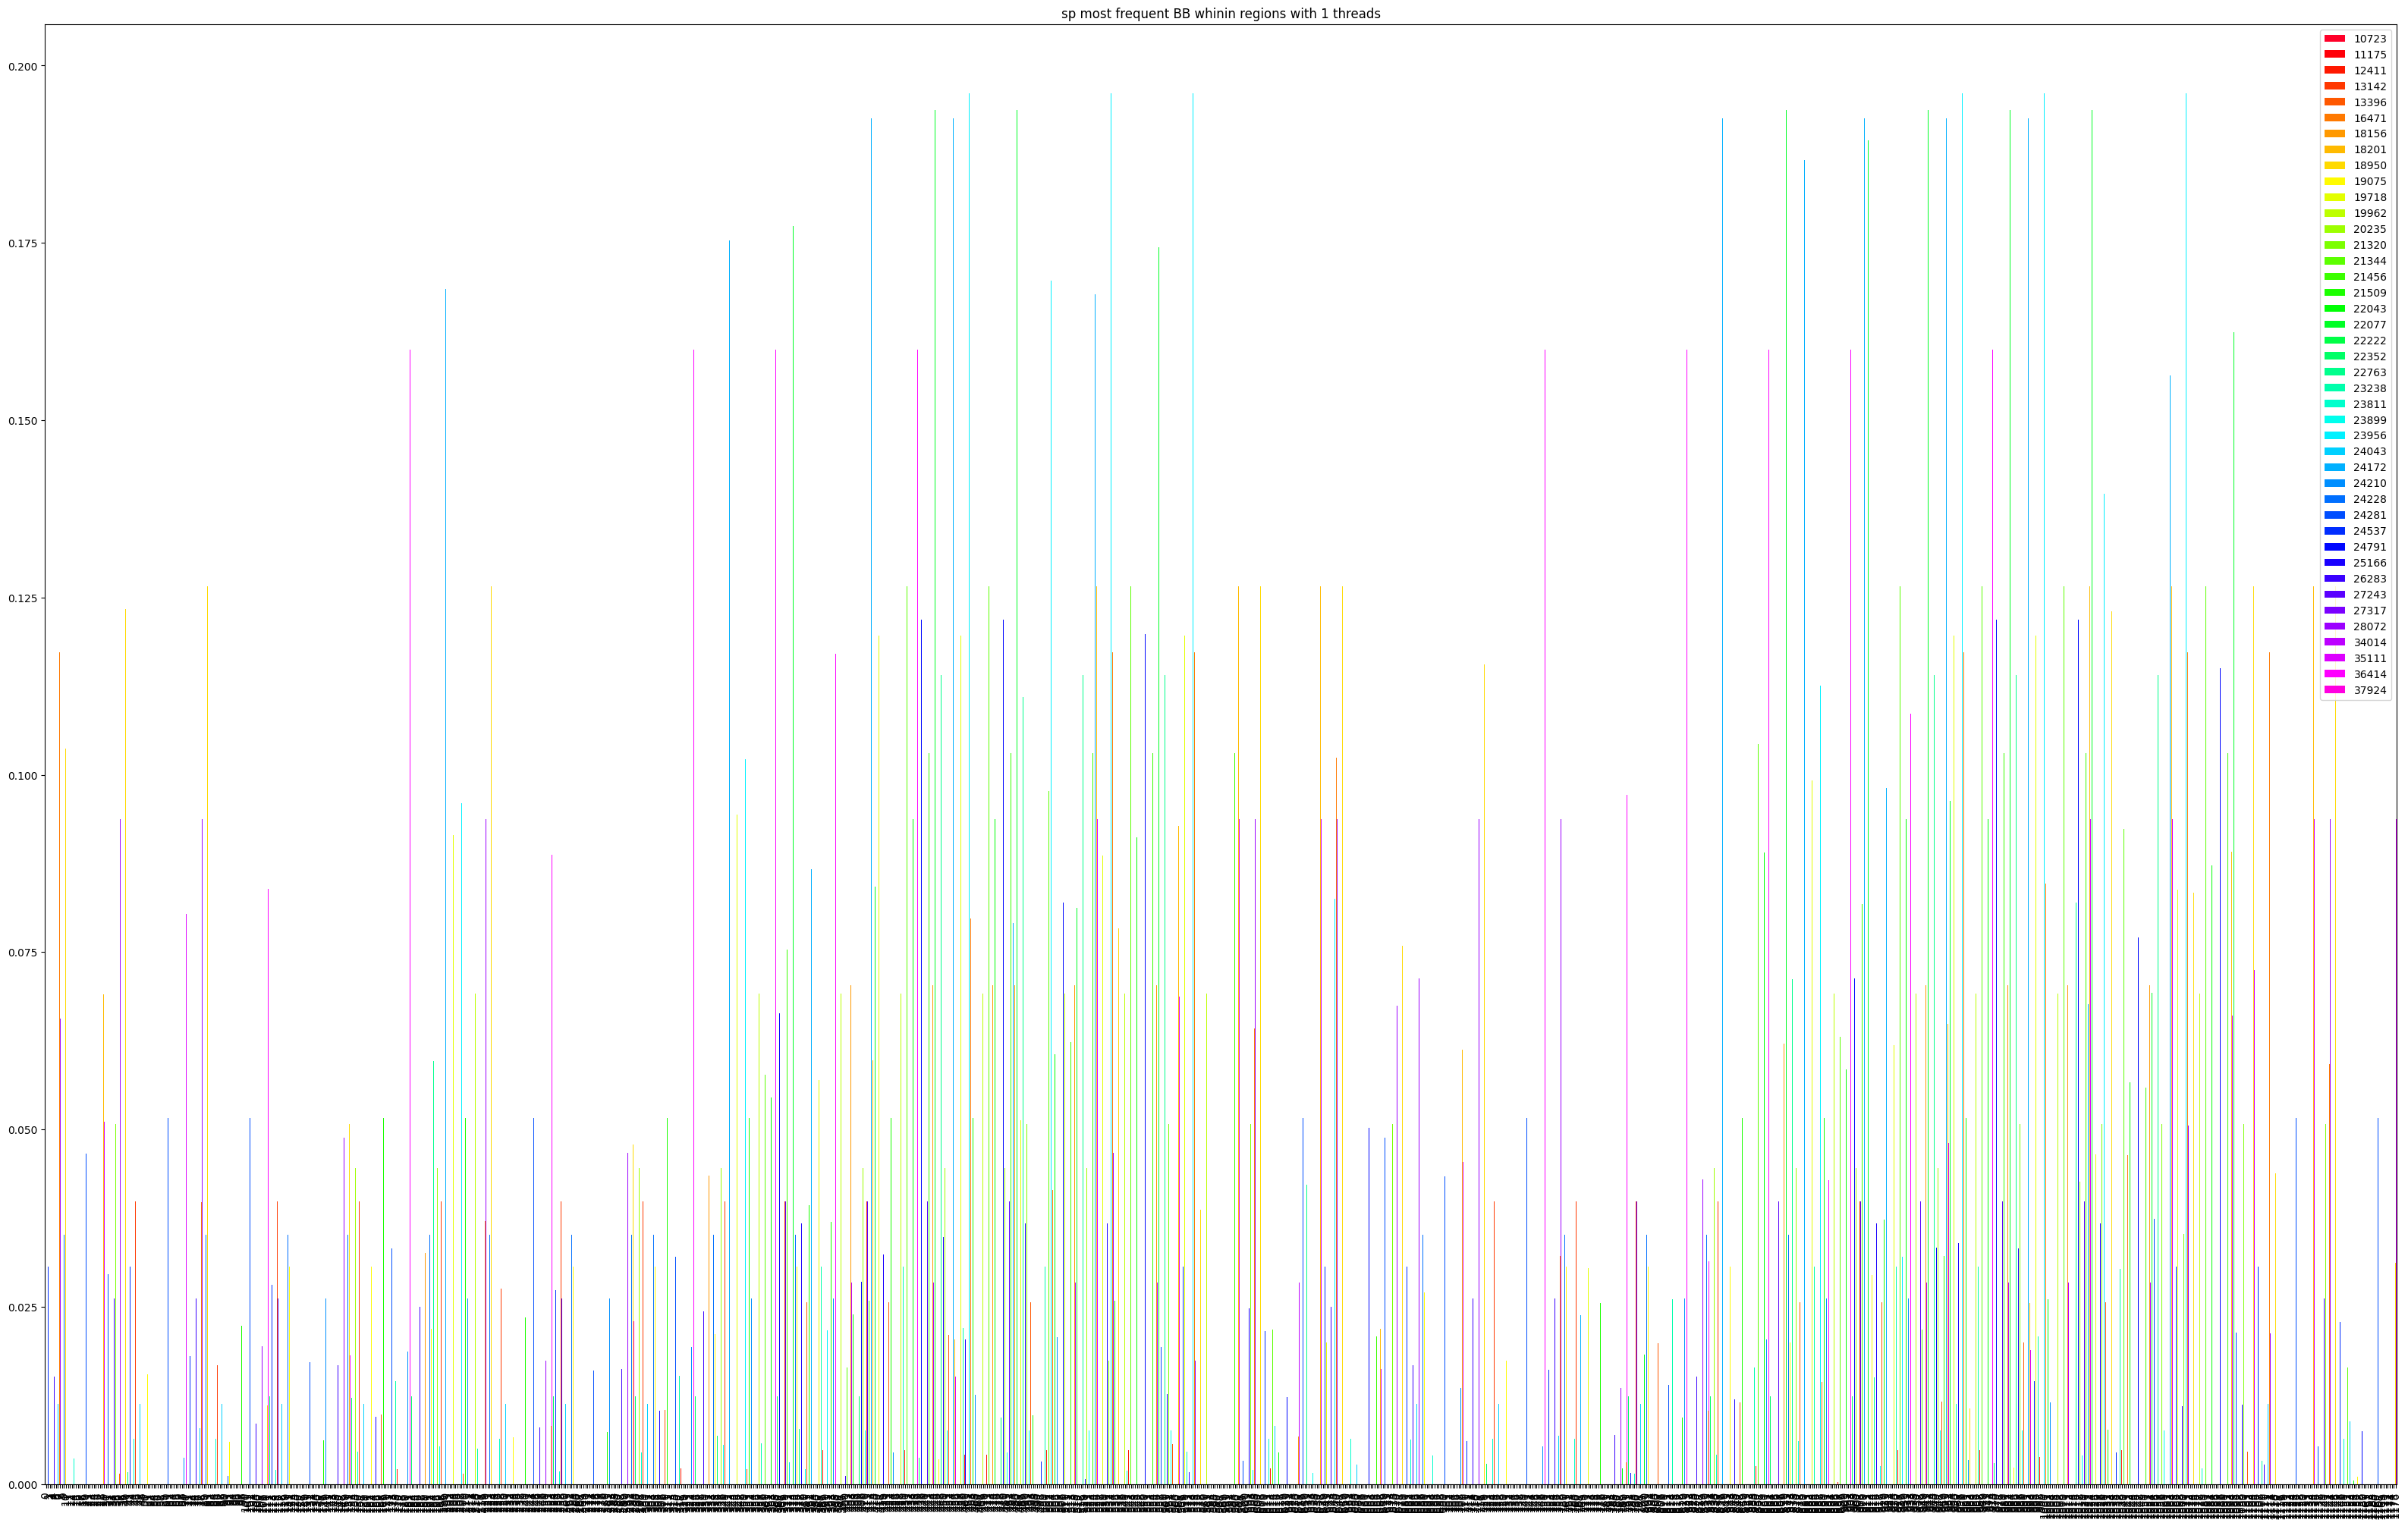

In [44]:
for bench in benchmarks:
    show_highest_ten_bbf("arm","1",bench)

### merge 4 regions into 1 region for 1 thread stats

working on cg-Minor-1-l2-256kB
working on cg-Minor-1-l2-2MB
working on cg-O3-1-l2-256kB
working on cg-O3-1-l2-2MB
working on cg-Timing-1-l2-256kB
working on cg-Timing-1-l2-2MB


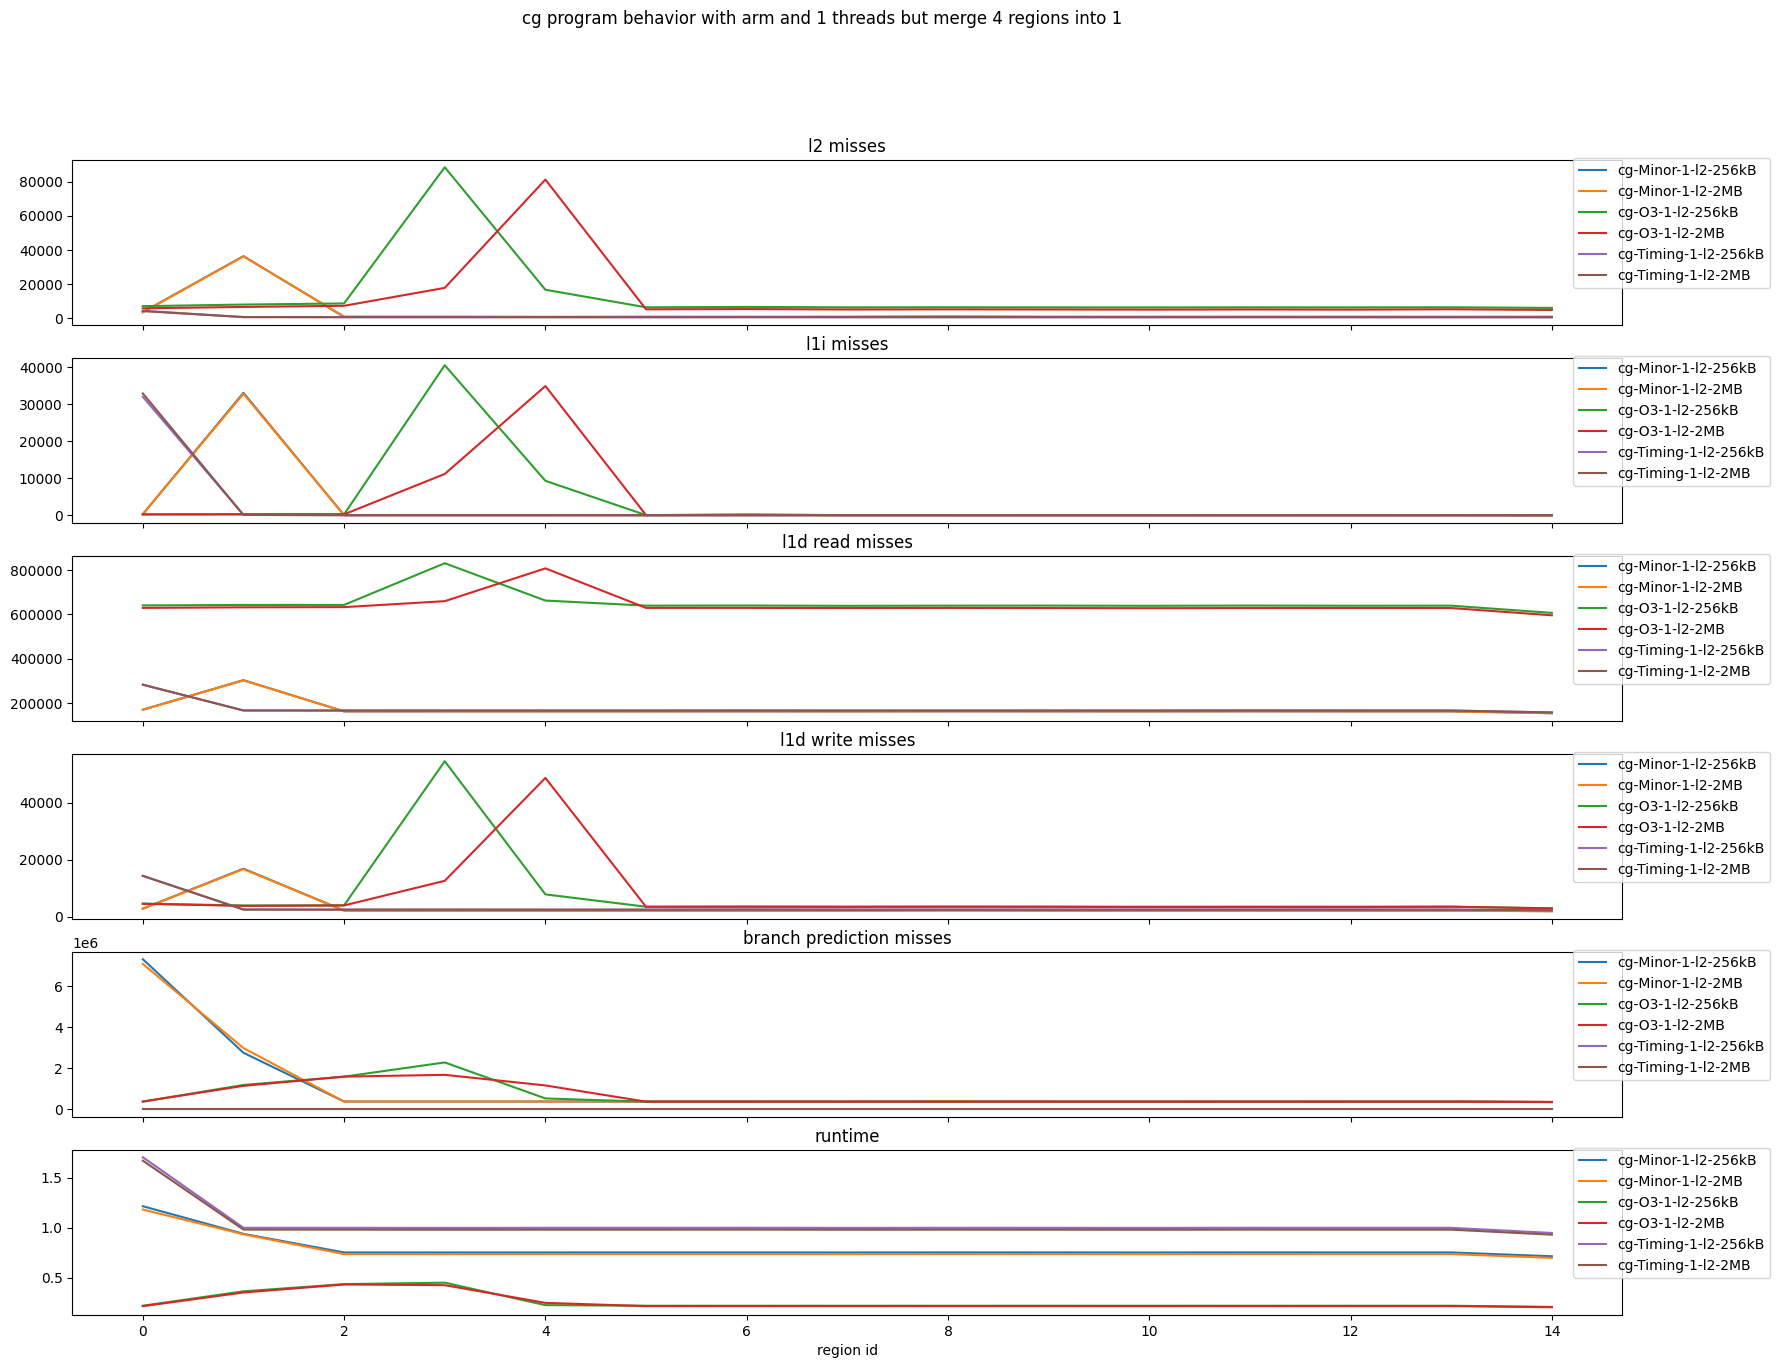

working on ep-Minor-1-l2-256kB
working on ep-Minor-1-l2-2MB
working on ep-O3-1-l2-256kB
working on ep-O3-1-l2-2MB
working on ep-Timing-1-l2-256kB
working on ep-Timing-1-l2-2MB


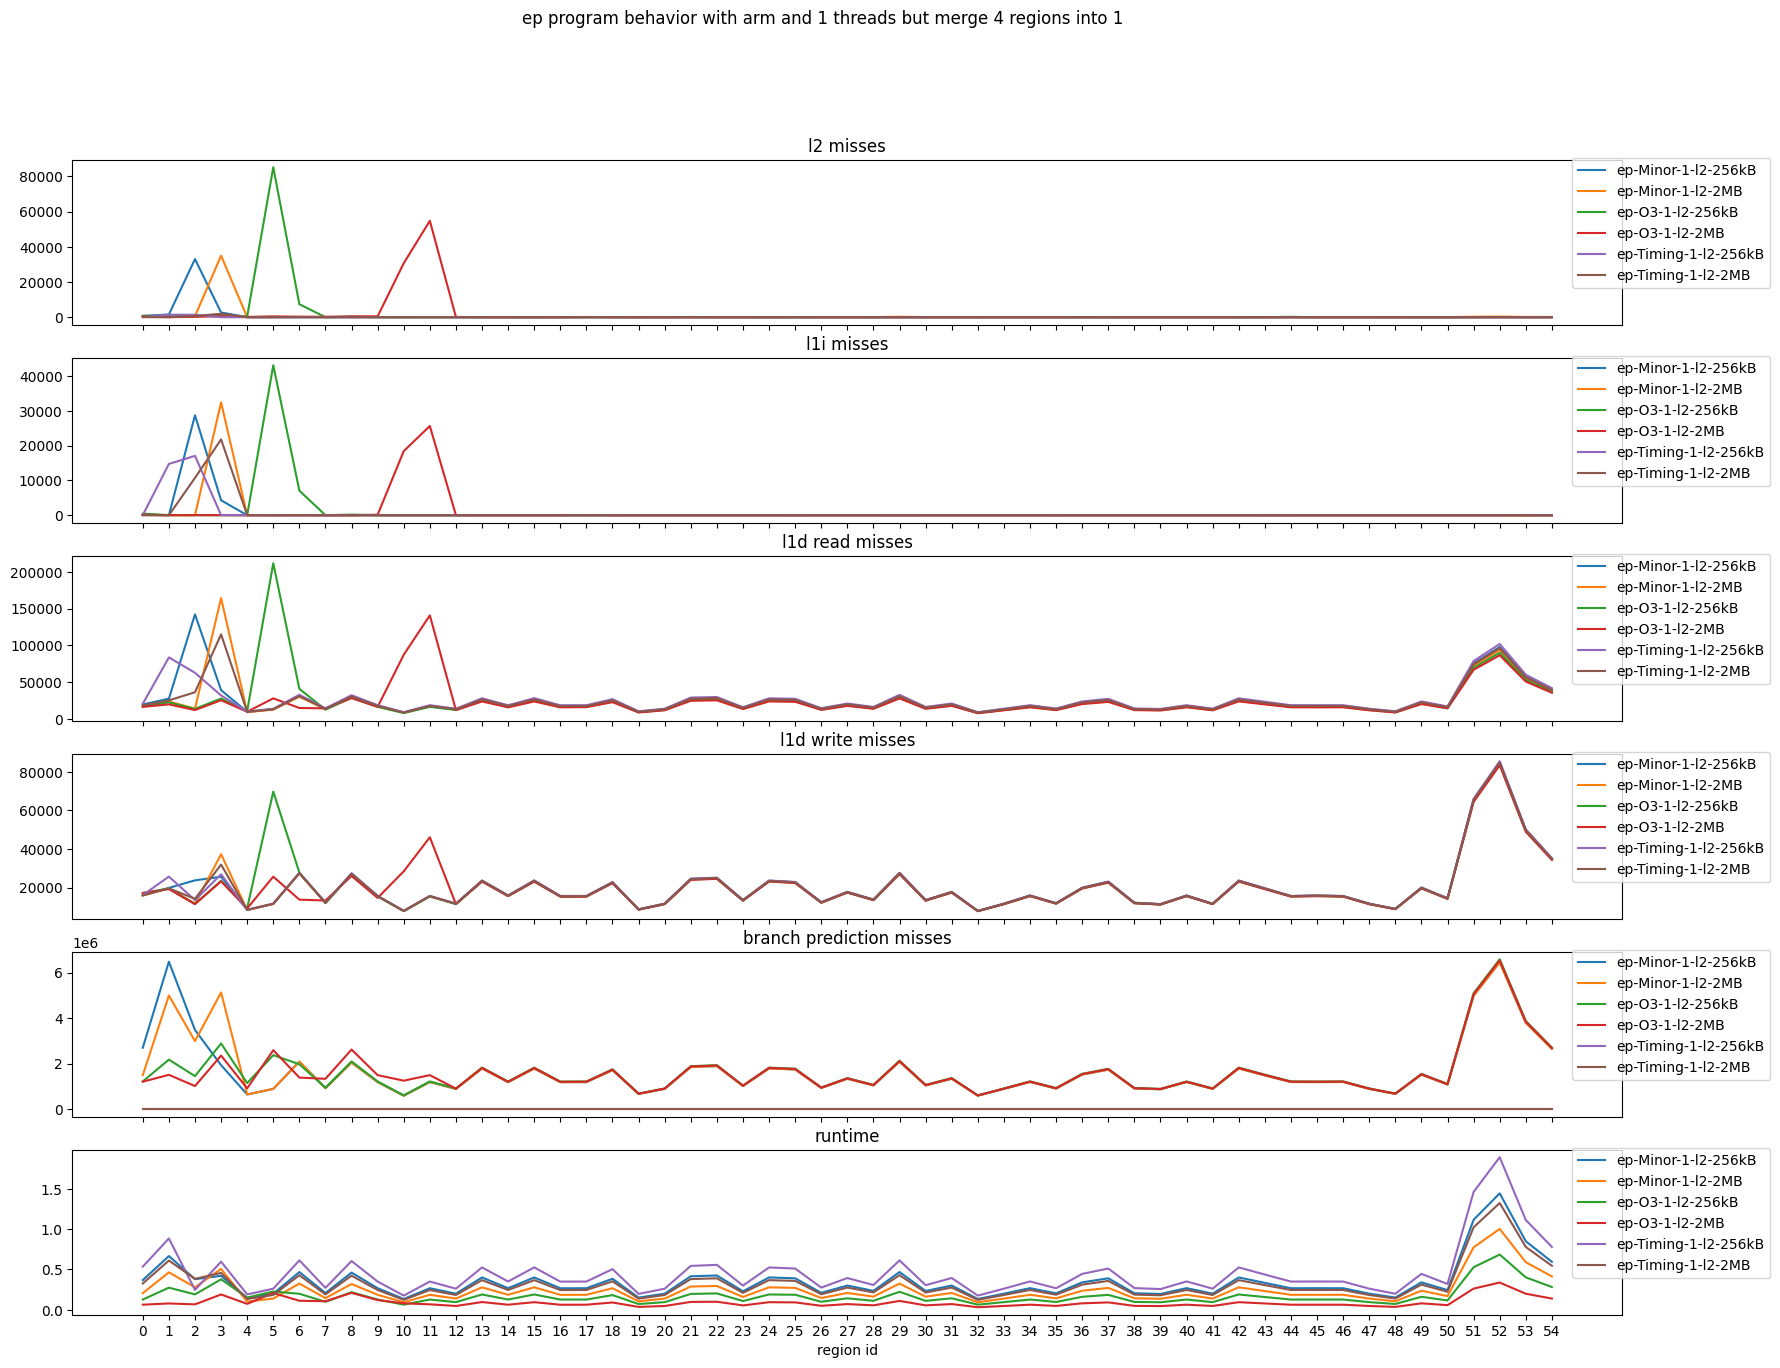

working on ft-Minor-1-l2-256kB
working on ft-Minor-1-l2-2MB
working on ft-O3-1-l2-256kB
working on ft-O3-1-l2-2MB
working on ft-Timing-1-l2-256kB
working on ft-Timing-1-l2-2MB


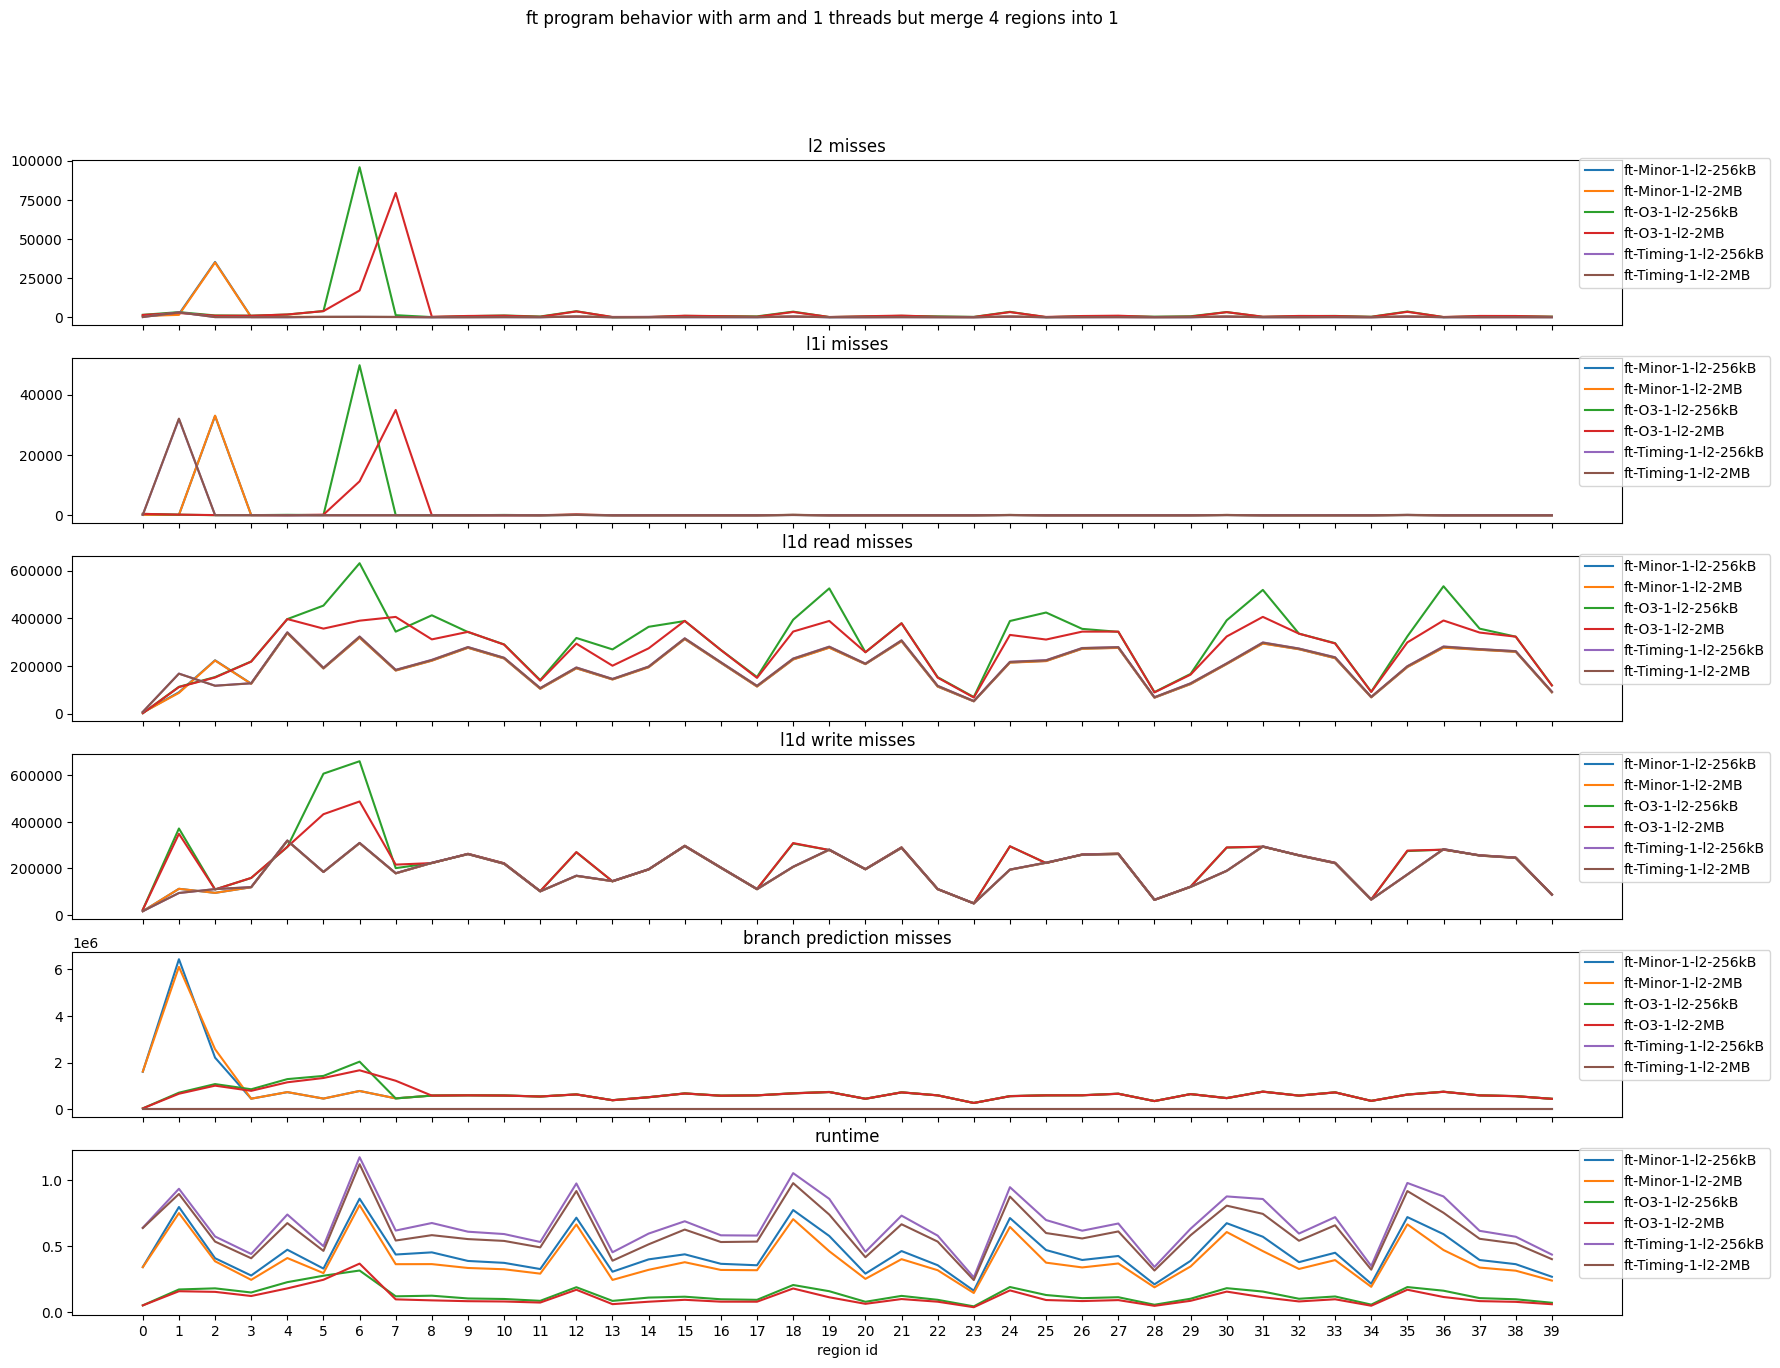

working on is-Minor-1-l2-256kB
working on is-Minor-1-l2-2MB
working on is-O3-1-l2-256kB
working on is-O3-1-l2-2MB
working on is-Timing-1-l2-256kB
working on is-Timing-1-l2-2MB


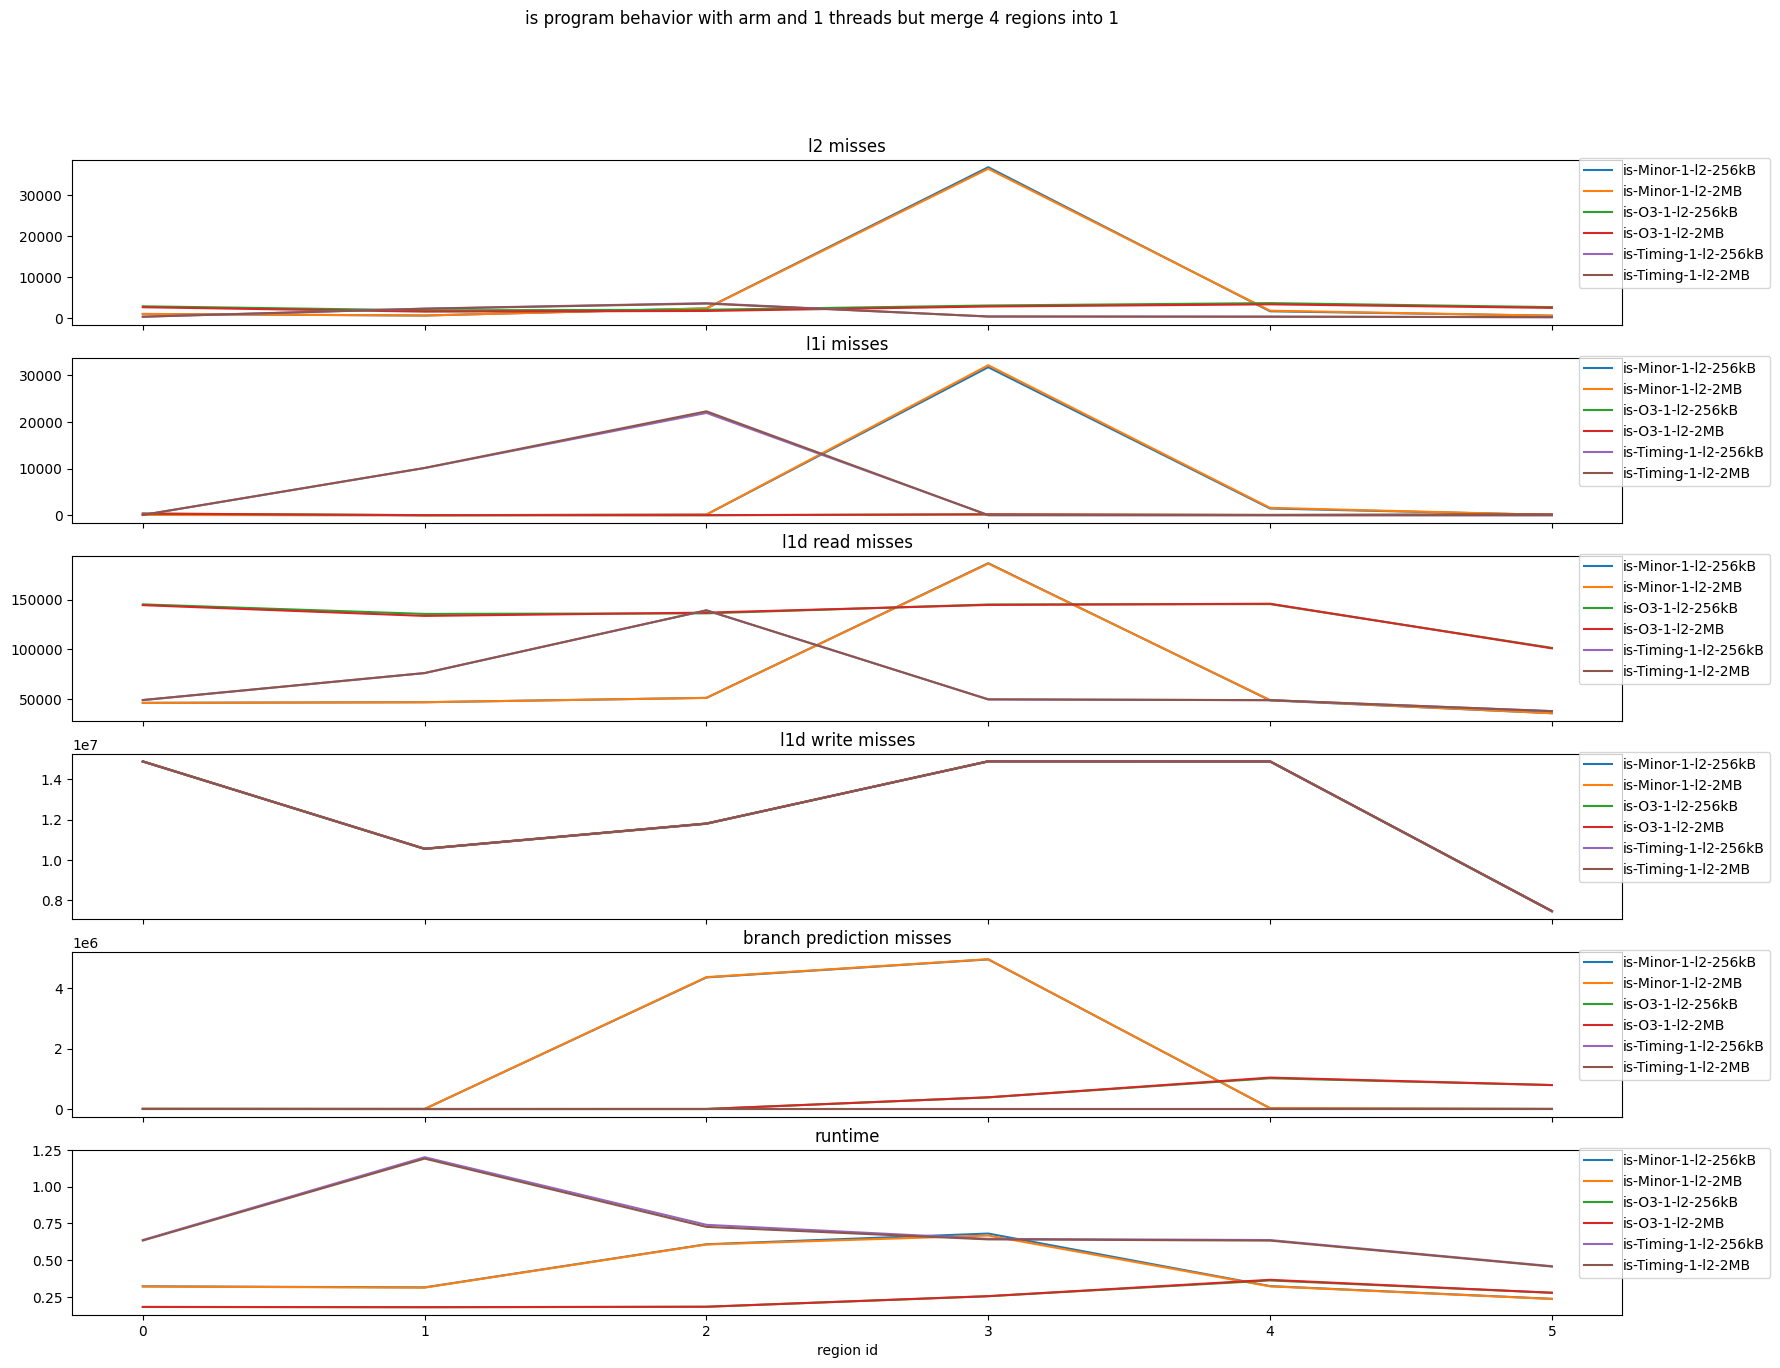

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


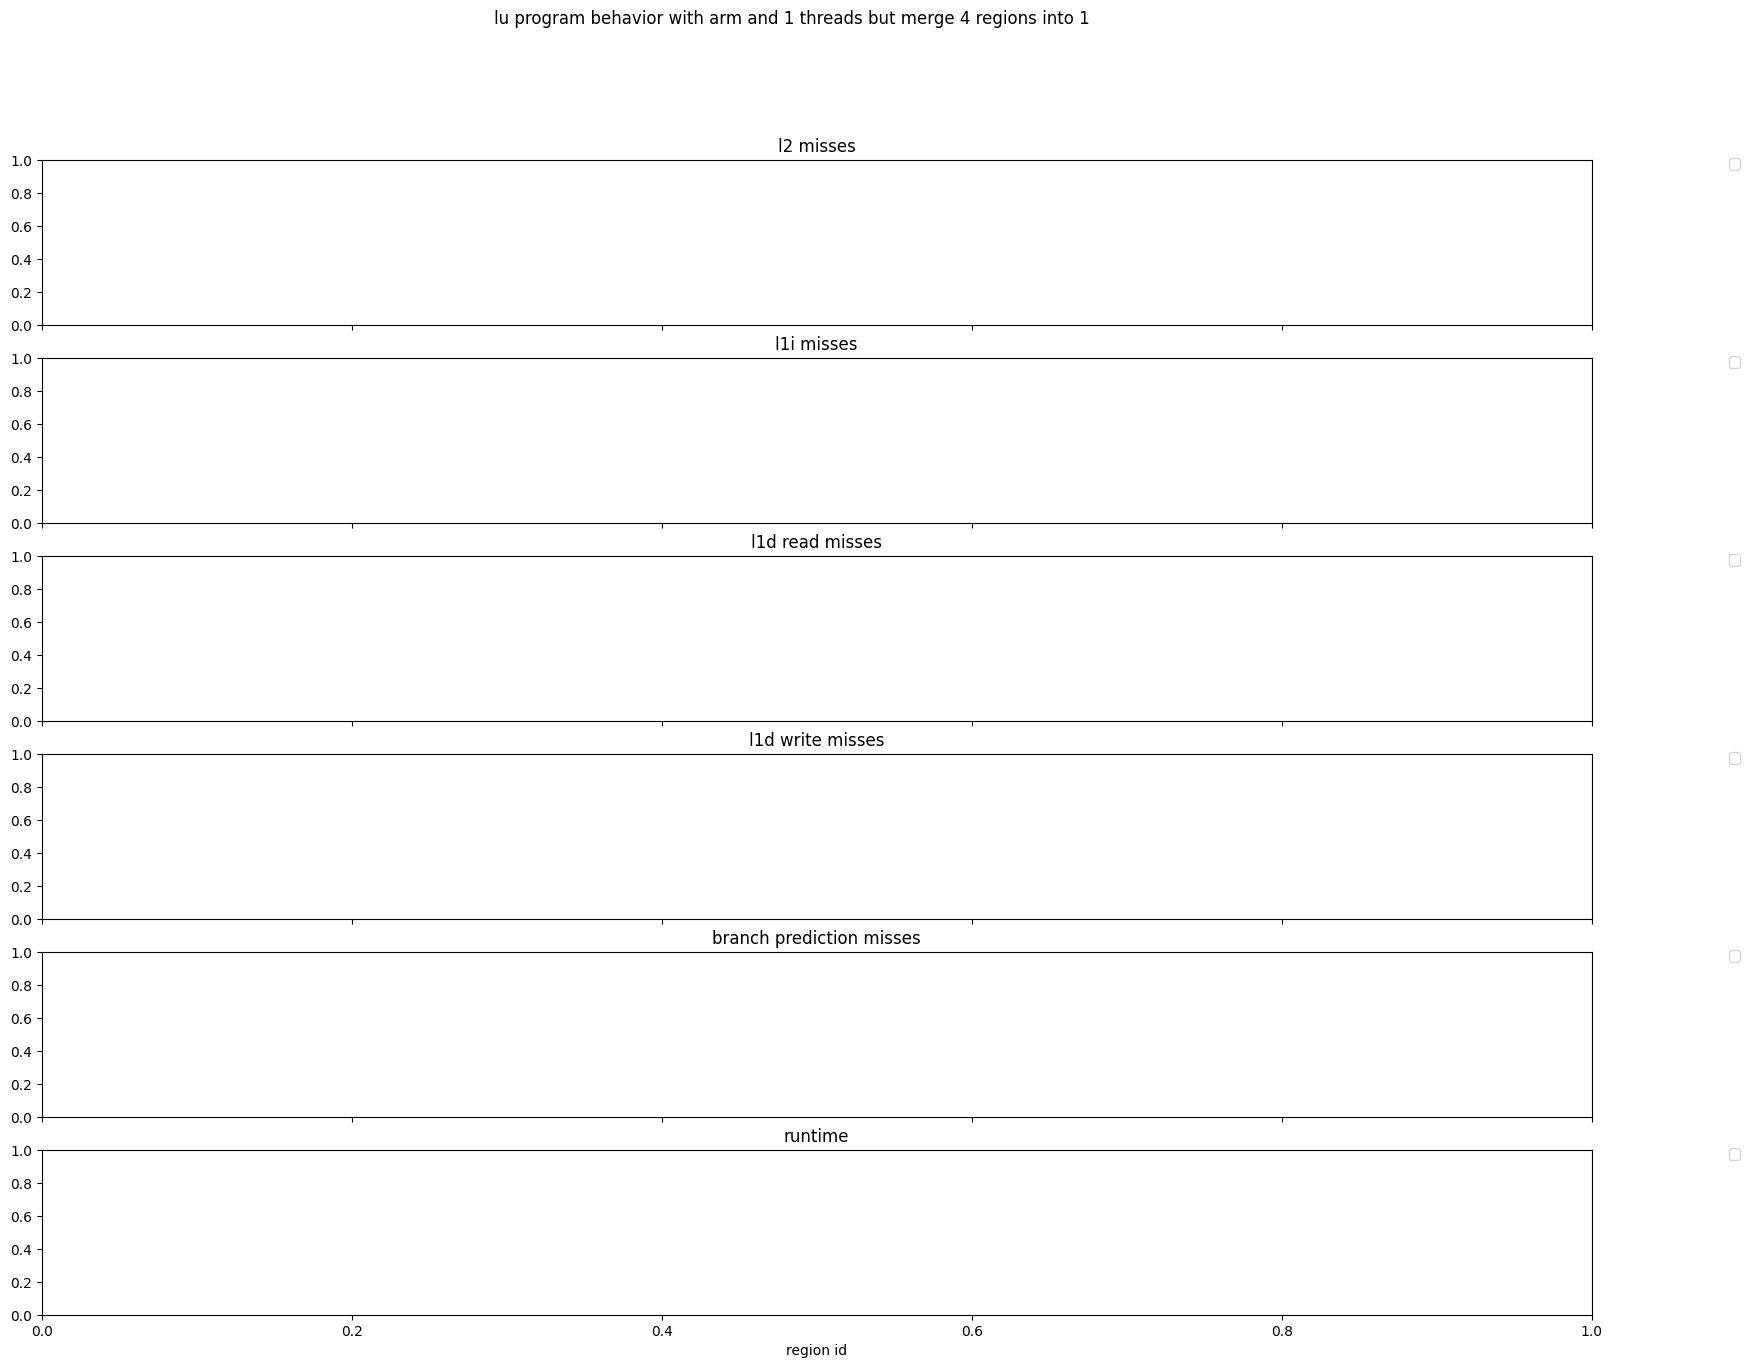

working on mg-Minor-1-l2-256kB
working on mg-Minor-1-l2-2MB
working on mg-O3-1-l2-256kB
working on mg-O3-1-l2-2MB
working on mg-Timing-1-l2-256kB
working on mg-Timing-1-l2-2MB


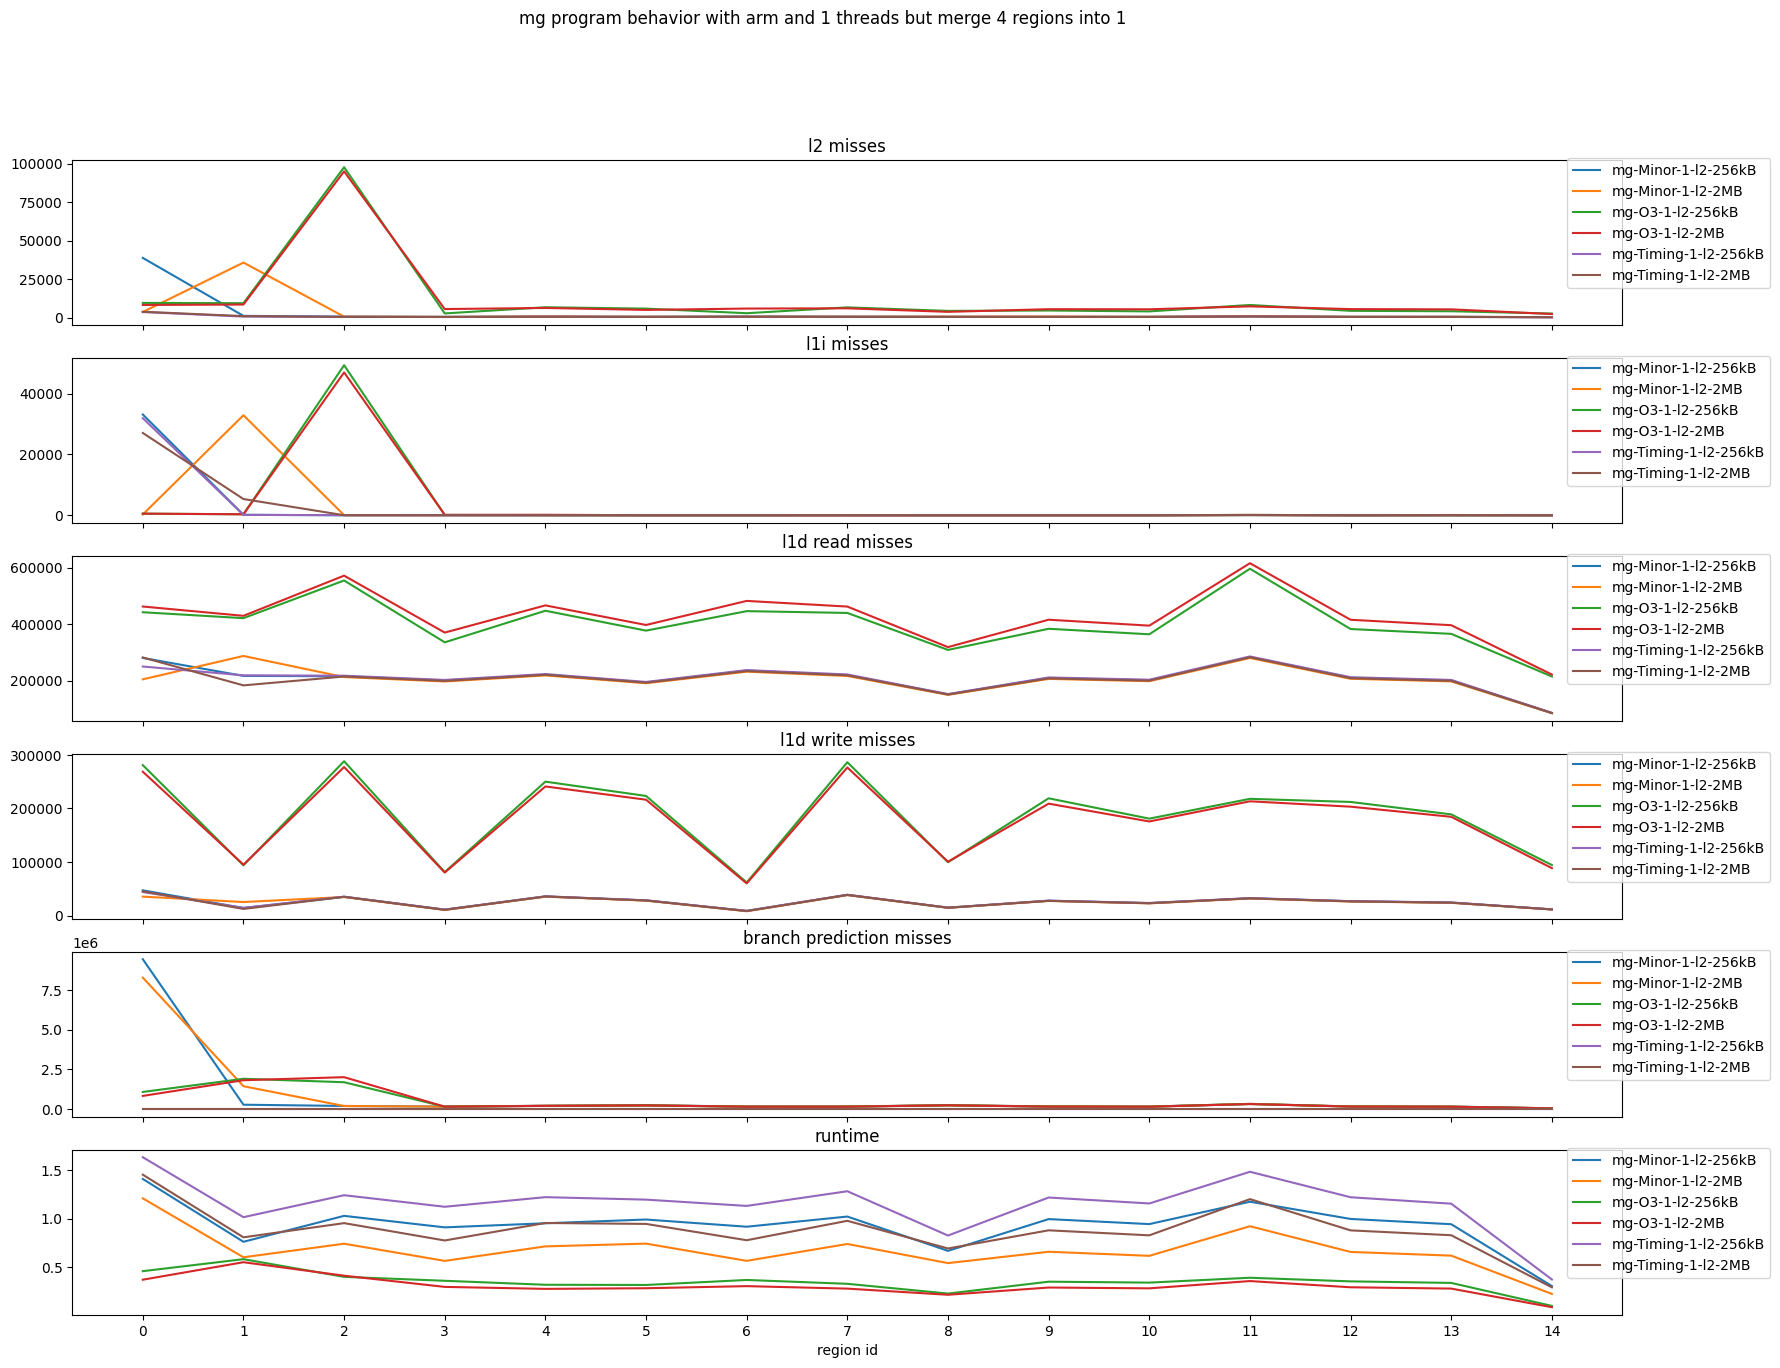

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


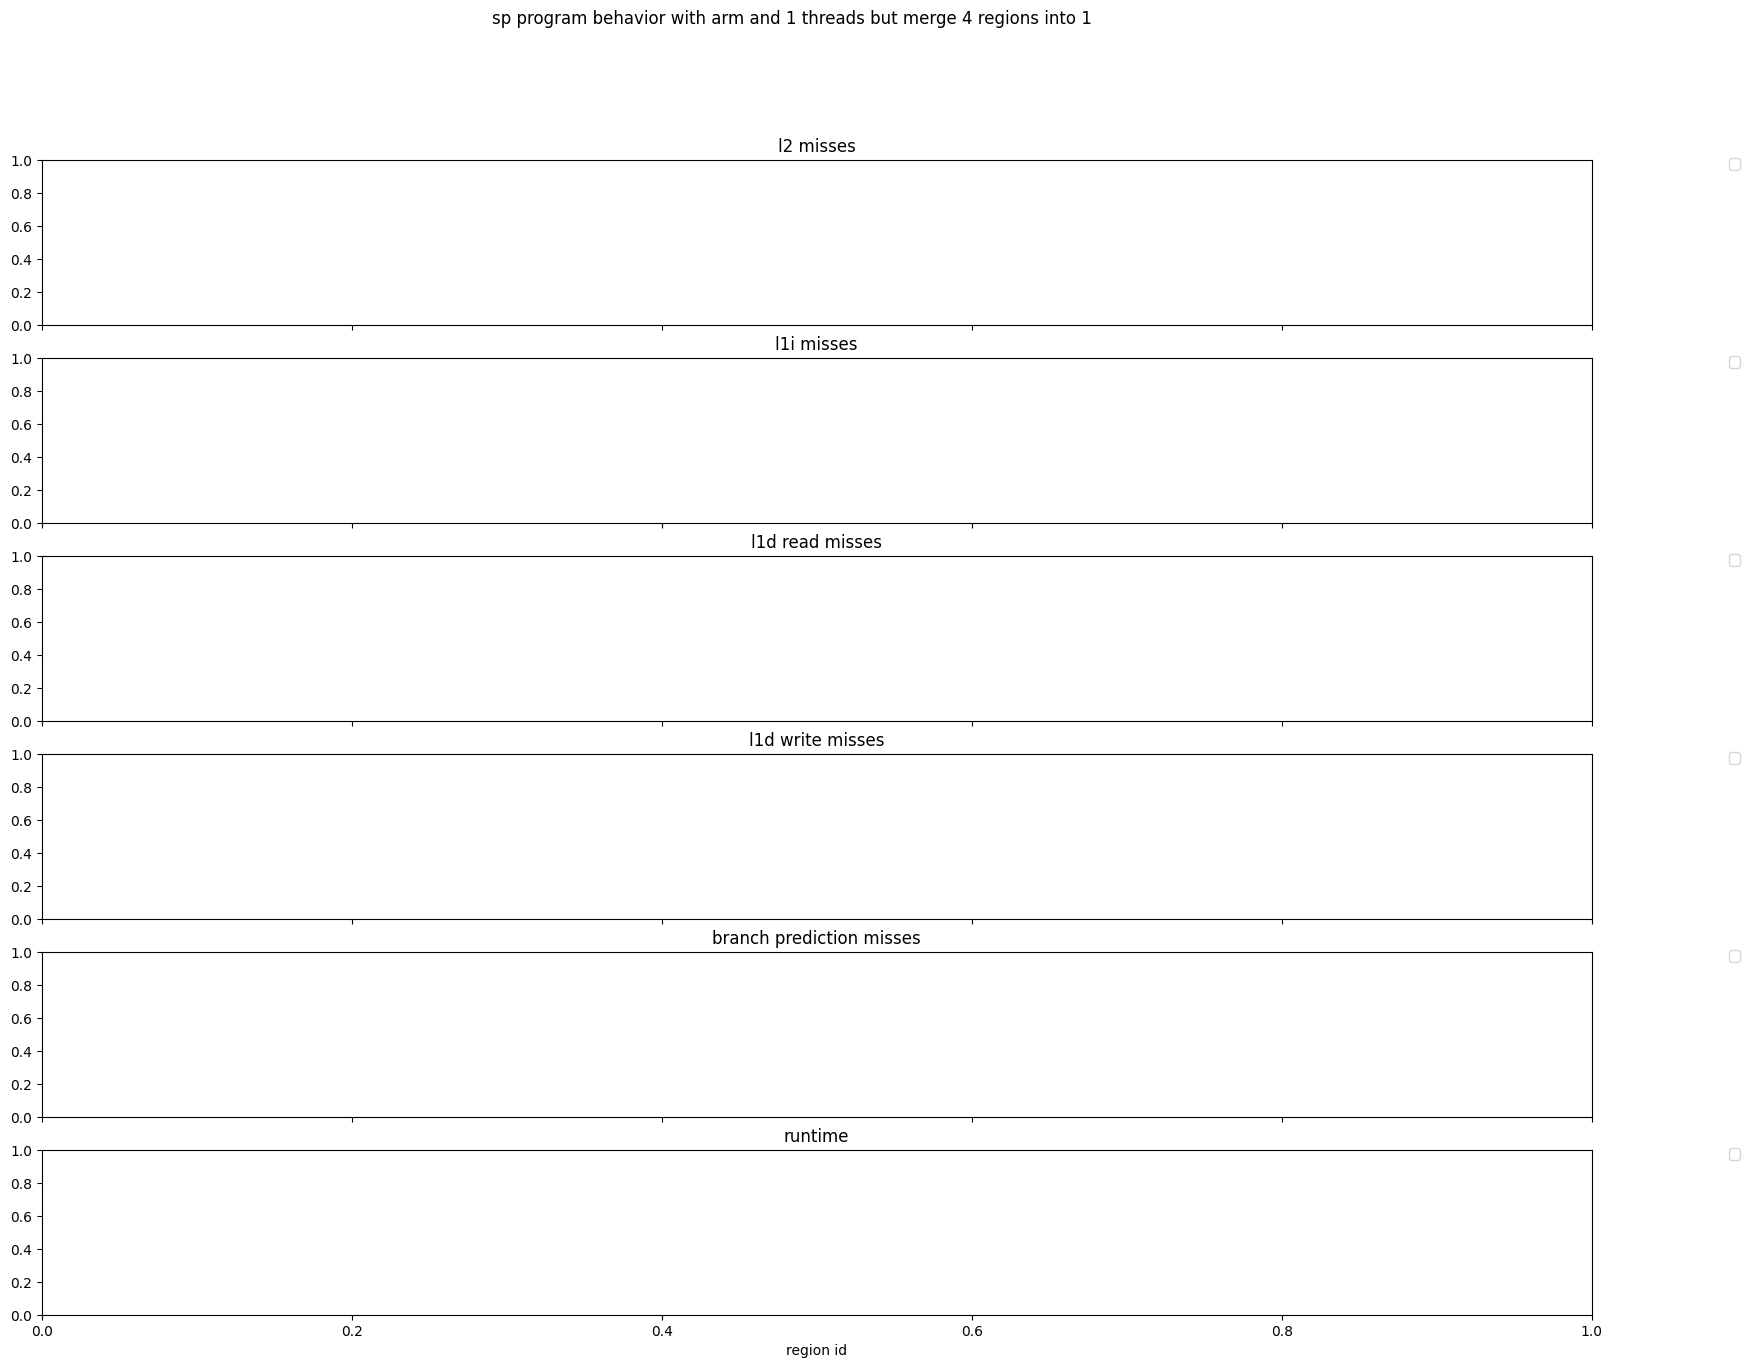

In [49]:
for bench in benchmarks:
    show_one_set_for_multiple_config_merge_single_thread_stats_to_4_threads("arm",bench)